<h1><center> Decomposing XANES measurements using the Rising Sun Envelope Method</center> </h1>

This is a Supplementary Jupyter-notebook to the paper __*"The Rising Sun Envelope Method: an automatic and accurate peak location technique for XANES measurements"*, by R. Monteiro, I. Miyazato, and K. Takahashi.__

>__Remark:__ We have decided to not put any function in modules for a didactic purpose; in this way people can understand how each function works and how they have been implemented. 

The Initial part of the code does the following: 
1. We open all csv files in the folders (see "what files", below). Each file contains $E$ and $\mu(E)$
2. Save all the entries to columns of a pandas vector "data", where we alternate $E$ and $\mu(E)$ (the files do not necessarily have the same length)
3. define a materials vector, on which we perform a decomposition

>__Remark:__ we run this code in both Linux and Mac, with Python 3. Unfortunately Macs give some warning when dealing with PS images, so we rerun the code and gitted it once more. 

In [1]:
## Packages
import csv
import numpy as np
#import seaborn
%matplotlib inline
import matplotlib.pyplot as plt
### To do normalization
from sklearn.preprocessing import normalize
import pandas as pd
import multiprocessing 
import time

### To do normalization
from sklearn.preprocessing import normalize

# To prevent weird, long warning
import warnings
warnings.filterwarnings(action="ignore",message="internal issue")

# where we are saving stuff
import os
PROJECT_DIR =  os.getcwd()#os.path.dirname(os.path.realpath(__file__))
NOTEBOOK = "XANES_figures"
IMAGES = os.path.join(PROJECT_DIR,"figures",NOTEBOOK)

## A save figures function
def figure_save(figure_name, tight_layout=True, figure_extension="eps",resolution=300):
    path = os.path.join(IMAGES,figure_name.replace(" ", "_")+"."+figure_extension)
    print("Saving figure as ",figure_name.replace(" ", "_"))
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path,format=figure_extension,dpi=resolution)

Let's read the data

In [2]:
## For Fe data --- List all the csv files in the directory
import glob
what_files = glob.glob(PROJECT_DIR+"/Xanes/*.csv")

data=pd.DataFrame([])

for name_of_file in what_files:
    # read  first row with name of components
    aux = pd.read_csv(name_of_file,delimiter=',') 
    
    ## Concatenate them all
    data = pd.concat([data,aux],axis=1)

Now we read the organize it:

In [3]:
names = list(data.columns)[1:]
### These are the dictionaries where we will save numpy arrays
raw_materials, E, A={}, {}, {}

data_val = data.values
numb_files = len(what_files)

for i in range(1,data.shape[1]):
    name = names[i-1]
    E[name] = np.reshape(data_val[:,0],(1,-1))
    raw_materials[name] = np.reshape(data_val[:,i],(1,-1))    

The elements we are dealing with are

In [4]:
names

['Fe foil', 'Fe2O3', 'Fe3O4', 'FeO']

Let's plot them

Saving figure as  XANES_some_examplesFe_foil


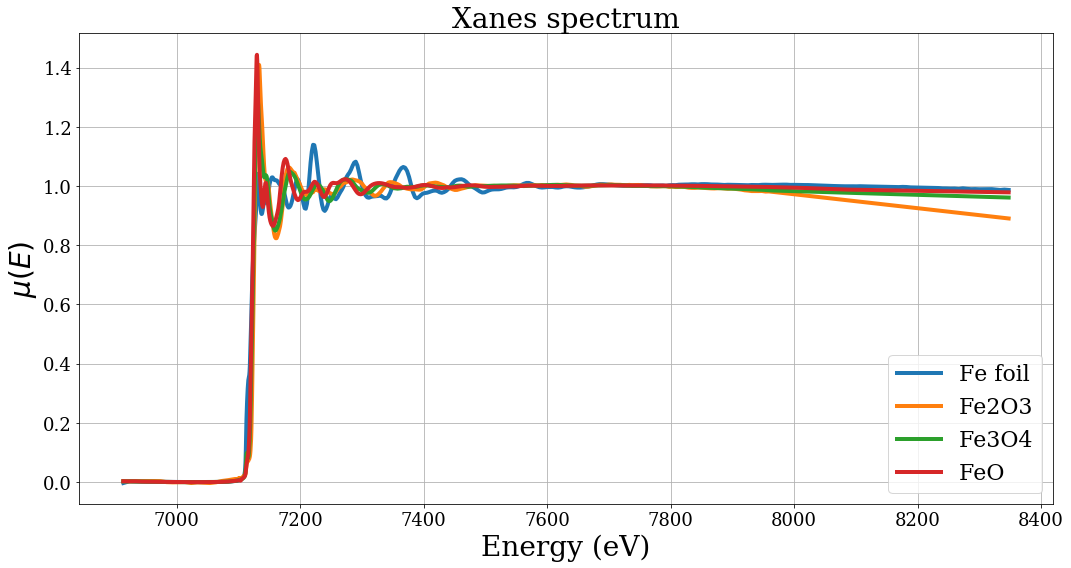

In [5]:
L = len(names)
plt.figure(figsize=(15,8))
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

for i in range(0,L):
    plt.plot(E[names[i]].T,raw_materials[names[i]].T,color='C'+str(i%10), label = str(names[i]),lw=4,linestyle='-')

plt.title('Xanes spectrum',size=28)
plt.ylabel('$\mu(E)$',size=28)
plt.xlabel("Energy (eV)", size=28)
plt.legend(loc=4,prop={'size':22})
plt.grid(True)
figure_save("XANES_some_examples"+names[0])
plt.show()    

Let's read the first derivative, as provided by Athena: 

In [6]:
what_files_derivatives = glob.glob(PROJECT_DIR+"/xafsderivative/Fe_1st_derivative.csv")

data_derivatives=pd.DataFrame([])

for name_of_file in what_files_derivatives:
    # read  first row with name of components
    aux = pd.read_csv(name_of_file,delimiter=',') 
    
    ## Concatenate them all
    data_derivatives = pd.concat([data_derivatives,aux],axis=1)


names_1st_derivatives = list(data_derivatives.columns)[1:]
### These are the dictionaries where we will save numpy arrays
raw_materials_1st_derivatives, E_derivatives, A_derivatives={}, {}, {}
data_val_derivatives = data_derivatives.values

for i in range(1,data_derivatives.shape[1]):
    name = names_1st_derivatives[i-1]
    E_derivatives[name] = np.reshape(data_val_derivatives[:,0],(1,-1))
    raw_materials_1st_derivatives[name] = np.reshape(data_val_derivatives[:,i],(1,-1))    

In [7]:
data_derivatives.columns

Index(['﻿energy', 'Fe_foil', 'Fe2O3', 'Fe3O4', 'FeO'], dtype='object')

For the second derivative, we do

In [8]:
what_files_derivatives = glob.glob(PROJECT_DIR+"/xafsderivative/Fe_2nd_derivative.csv")

data_derivatives=pd.DataFrame([])

for name_of_file in what_files_derivatives:
    # read  first row with name of components
    aux = pd.read_csv(name_of_file,delimiter=',') 

    ## Concatenate them all
    data_derivatives = pd.concat([data_derivatives,aux],axis=1)

### These are the dictionaries where we will save numpy arrays
raw_materials_2nd_derivatives, E_derivatives, A_derivatives={}, {}, {}
data_val_derivatives = data_derivatives.values

for i in range(1,data_derivatives.shape[1]):
    name = names_1st_derivatives[i-1]
    E_derivatives[name] = np.reshape(data_val_derivatives[:,0],(1,-1))
    raw_materials_2nd_derivatives[name] = np.reshape(data_val_derivatives[:,i],(1,-1))    

In [9]:
raw_materials_2nd_derivatives.keys()

dict_keys(['Fe_foil', 'Fe3O4', 'Fe2O3', 'FeO'])

<h2><center> Some auxiliary functions and data normalization </h2></center>


There are a few things that we should do before we start. First, we shall normalize the data. Note that, as we are only vertically translating or stretching the measurement, the energy component of peaks will not be affected.


In [10]:
def normalization(materials,names,normalizeheight=False):
    '''
    This function returns  a vertically translated, and possibly stretched vertically, copy of
    the a spectrum to  a vector X, in such a way that 
    
    (i) X[0,0] = 0
    holds     and
    
    (ii) max(X) - min(X)=1  holds when normalizeheight = True
    ----------------
    Input:
    
    -names: vector of strings
    -materials: dictionary with spectra, indexed by elements in vector names
    -normalizeheight: a boolean entry, that defines whether the normalization (**) happens
    ----------------
    Output is/are:
    - X: the renormalized vector
    - shift_height: the amout we had to shift the vectoverticaly in order to have X[0.0]=0 
    ----------------
    '''
    shift_height, normalization_heights, X={}, {}, {}
    for name in names:
        shift_height[name] = np.copy(materials[name][0,0])
        X[name]  = materials[name]- shift_height[name]
    
    if normalizeheight:
        ### Now we use the function normalize, from sklearn
        for name in names:
            X[name],normalization_heights[name] = normalize(X[name], norm='max', axis=1,return_norm=True)

    return X, shift_height, normalization_heights

#########################################################################################################
def oscillation_function(interval,f,full_computation=True):
    ''' set an oscillation function f on an interval interval.
    
    ----------------
    Input:
    
    - interval of computation: THIS IS NOT NECESSARY, ACTUALLY!
    - f: the function whose oscillation will be computed
    - full_computation, a flag, where user define whether to compute fulll oscillation function, 
      or just the threshold
    
    ----------------
    Output:
    
    - x: a vector labeled as 1...N
    - oscillation: oscillation of the function f
    - estimated oscillation: the threshold oscillation, given as oscillation[0,1]
    ----------------
    '''
    #plot the oscillation of the function
    L = interval.shape[1]
    x = np.reshape(np.arange(L),(1,-1))
    oscillation = np.zeros([1,L]).reshape(1,-1)
    
    if full_computation:
        for l in range(1,L):
            oscillation[0,l] = np.max([np.max(f[0,k:k+l+1]) - np.min(f[0,k:k+l+1]) for k in range(L-l)])
        
        return (x, oscillation, oscillation[0,1])
    else:
        oscil_number = np.max([np.max(f[0,k:k+1+1]) - np.min(f[0,k:k+1+1]) for k in range(L-1)])
        
        return (x, None, oscil_number)
#########################################################################################################    
def plateau_detection (v,L_threshold):
    '''
    This function detects plateaus of length > L_threshold in a vector v. 
    ----------------
    Input:
    - v: a matrix with shape 1 X m
    - L_threshold: plateaus with length L < L_threshold will not be considered]. L_threshold >=2
    ----------------
    Output:
    
    It returns their 
    - location: the entry of the peak in the vector
    - the value that the vector v take at that point.
    
    If no peak is found then it returns (None, None)
    ----------------
    '''
    v_temp = np.copy(v).reshape(1,-1) # this is a row vector, not a rank one vector
    
    # In order to detect the plateaus, we make a copy of the vector and compare it with a shifted version of itself
    v_aux =np.copy(v_temp[0,0:-1]) ## a smaller version of v
    v_shifted = np.copy(v_temp[0,1:])
    ''' They are going to be use in the following fashion:
        anytime we have a number 1 means that the next element is the same to the next one.
        The length of a sequence of 1s defines the length of that sequence'''
        
    # Now we compare v_aux and v_shifted, not forgetting to add 0's in the beggining and in the end;
    # We do that because we also want to find sequences in the extremes of the vector
    where_plts_start_and_length = np.array(1*(v_aux==v_shifted),ndmin=2)
    where_plts_start_and_length = np.concatenate([[0],where_plts_start_and_length[0],[0]]).reshape(1,-1)
            
    '''
    NOTE #1: where_plts_start_and_length is avector with schape 1X m+1
    NOTE #2: sequences of 1`s with length a in where_plts... indicate sequnces in v with length a+1
    
     At this point we define sequences of 010, 0110 etc, and look for them in the vector.
     If the number of 1's is strictly less than L_threshold -1 then we ignore the plateau.
     '''
    for i in range(1,L_threshold-1):  
        # we shall ignore strings that are smaller than L_threshold
        # now we define a list of 1s, with legth i
        sequence = np.ones([1,i],dtype=np.int32)
        # 1- AUGMENTING THE VECTOR WITH ZEROS
        sequence = np.concatenate([[0],sequence[0],[0]]).reshape(1,-1)
        
        # Now we search for it in the vector where_plts_start_and_length
        range_search = where_plts_start_and_length.shape[1]-sequence.shape[1]+1
        
        is_there = [j for j in range(range_search) if str(where_plts_start_and_length[0,j:j+sequence.shape[1]]) ==str(sequence.squeeze()) ]      
        if is_there != []:
            for k in is_there :
                where_plts_start_and_length[0,k:k+sequence.shape[1]] = np.zeros([1,sequence.shape[1]])## erase that small string
        
    '''
    2- at this point the vector where_plts_start_and_length has no sequence of 1's with length < L_threshold -1
    the first maximum will be at 
    '''
     
    if (np.sum(where_plts_start_and_length) ==0):
        #print("No peaks!")
        return (None,None)
    
    Len_where = where_plts_start_and_length.shape[1]-1
    locations = np.array([],np.int16,ndmin=2)
    
    for i in range(Len_where):
        # Whenever we have a seq of 1s, we know for sure that it has length bigger or equal to L_threshold,
        # so we can return the value of it`s location
        
        if (where_plts_start_and_length[0,i+1]- where_plts_start_and_length[0,i] ==1):
            locations = np.concatenate((locations,np.array([i],np.int16, ndmin=2)),axis=1) # subtract 1, because the vector was augmented by 0 in the extremes
        
    locations = np.reshape(locations[0], (1,-1))
    return (locations[0],v[0,locations[0]])
    

#########################################################################################################
def start_from_peak(Maj,L_threshold):
    '''
    Given a majorating function that starts with a plateau, find its second plateau, as long as the 
    latter has length bigger than L_threshold.
    ----------------
    Input:
    -Maj: a rising sun function
    -L_threshold: the length of the plateaus that should be taken into account 
    ----------------
    Output:
    -location: index of the next plateau
    - value: value of the function at the next plateau
    ----------------
    '''
    
    L = Maj.shape[1];
    m = Maj[0,0];
    i=1;
    while(i<L-2 and m == Maj[0,i]):
            i= i+1;
    
    locations,value = plateau_detection(np.array(Maj[0,i:],ndmin=2),L_threshold);
    return (locations+i, value)
    

#########################################################################################################
def padded_spectra(E, materials, names):
    '''
    Embeds Energy, XANES measurement spectrum into larger space, padding the Xanes measurement by a constant.
    Returns  emebedded Energy, embedded Xanes measurement, and index
    ----------------
    Input:
    - E: dictionary indexed by names, with energy interval
    -mu: dictionary indexed by names, with XANES measurements
    -names: keys of the previous dictionaries with names of materials
    
    ----------------
    Output:
    
    - padded_energy: dictionary indexed by names containing an extended energy vector to the right
    - padded_material: dictionary indexed by names containing a padded (o the right, by constant) xanes measurement
    -stopping: index of the last entry before the padding starts
    ----------------
    '''
    
    padded_material,  padded_energy, stopping ={}, {}, {}
    
    for name in names:
        stopping[name]= materials[name].shape[1]
        # the material vector needs to be padded....
        material_aux = np.squeeze(materials[name])
        #... while the energy vector needs to be extended 
        energy_aux = E[name] +E[name][0,-1]+E[name][0,1]-2*E[name][0,0]
        
        padded_material[name] = np.reshape(np.pad(material_aux,(0,stopping[name]),'edge'),(1,-1))
        energy_aux = np.concatenate((E[name],energy_aux),axis=1)
        padded_energy[name] = np.reshape(energy_aux,(1,-1))
        
    return padded_energy,padded_material,stopping

#########################################################################################################

def small_padded_spectra(E, F):
    '''
    Embeds two vectors E and F into larger space, extending E in one length to the right and
    padding the F measurement by a constant.
    Returns  emebedded Energy, embedded Xanes measurement.
    
    Unlike the function padded_spectra(E, materials, names), it does not need names
    ----------------
    Input:
    - E: numpy array denoting  energy interval
    - F: numpy array  denoting  XANES measurements
    ----------------
    Output:
    
    - padded E: numpy array  containing an extended energy vector to the right
    - padded_ F: numpy array  containing a padded (o the right, by constant) xanes measurement
    -stopping: index of the last entry before the padding starts
    ----------------
    '''
    stop= E.shape[1]
    # the material vector needs to be padded....
    F_aux = np.squeeze(F)
        #... while the energy vector needs to be extended 
    energy_aux = E +E[0,-1]+E[0,1]-2*E[0,0]
        
    padded_F = np.reshape(np.pad(F_aux,(0,stop),'edge'),(1,-1))
    energy_aux = np.concatenate((E,energy_aux),axis=1)
    padded_energy = np.reshape(energy_aux,(1,-1))
        
    return padded_energy,padded_F,stop

The next function is Rising Sun function is based on the Rising Sun Lemma, of Riesz: https://en.wikipedia.org/wiki/Rising_sun_lemma. The idea is that this function is more well behaved, and is less oscillatory. See also https://terrytao.wordpress.com/2010/10/16/245a-notes-5-differentiation-theorems/#more-4290 for a nice overview of the technique's use.

In [11]:
def rising_sun(mu):
    '''
    Given L = length of mu, return a vector maxim_mu of length L,for which, at any index 
     0 <=k <L we have  maxim_mu[k] >= maxim_mu[j],for all 0 <=j <k  
     
    ----------------
    Input:
    -mu: the XANES measurement
    
    ----------------
    Output:
    - maxim_mu: therising_sun function  associated to mu
    ----------------
     '''
    L = mu.shape[1]
    maxim_mu = np.zeros([1,L])
    maxim_mu[0,0]=mu[0,0]
    
    for i in range(1,L):
        if mu[0,i]>maxim_mu[0,(i-1)]:
            maxim_mu[0,i] = mu[0,i]
        else:
            maxim_mu[0,i] = maxim_mu[0,i-1]
    
    return maxim_mu

Now we use the previous functions to normalize the spectrum and embedd in in a bigger space of continuous functions; the main reason to do the latter is that it will help us to know when to stop the algorithm

In [12]:
materials, shift_height, normalizer_shift =normalization(raw_materials,names,normalizeheight=True)

E_padded,materials, stopping = padded_spectra(E,materials,names)

That is, the main difference is that the padded version is twice as big as the non-padded version

In [13]:
print(np.shape(E[names[1]]), np.shape(E_padded[names[1]]))

(1, 418) (1, 836)


<h2><center> Setting up parameters and hyperparameters  </h2></center>

The next thing we shall do is to create a parameter dictionary, that will contain a lot of information about each xanes measurement. In fact it will be a dictionary of dictionaries


Now let's start "feeding" the parameter dictionary. 

In [14]:
parameters ={}

for name in names:
    parameters[name]={
        # The non-normalized xanes
        'raw_xanes': raw_materials[name],
        'raw_energy': E[name],
   
        # The normalized xanes and embedded xanes
        'xanes': materials[name],
        'energy': E_padded[name],

        # The normalization and emebdding info
        'stop': stopping[name],
        'shift_height': shift_height[name],
        'normalizer_shift': normalizer_shift[name]
    }

Another thing that we are going to need are hyperparameters: I will keep them all the same throught the analysis for all the materials, but it doesn't have to be always the case

In [15]:
hyperparameters={
    ## These hyperparameters will be used in 
    'lambda_h':1,
    'lambda_d':1/2,
    
    ## These hyperparameters will be used in find_first_peak
    'lambda_h_find_1st':4,
    'lambda_d_find_1st':1/4,
    
    ## These hyperparameters will be used in 
    'lambda_d_shrink_1st':1/2, 
    'initial_oscillation_guess_parameter':10,
    
    ## These hyperparameters will be used in 
    'stretching_factor':3,
    'iteration_decay':.9,
    
    ## Type of decay_rate
    'decay_rate_type': 'min_max'
}

Side by side, the normalized and non-normalized look like this

Saving figure as  XANES_some_examples_normalized_and_embeddedFe_foil


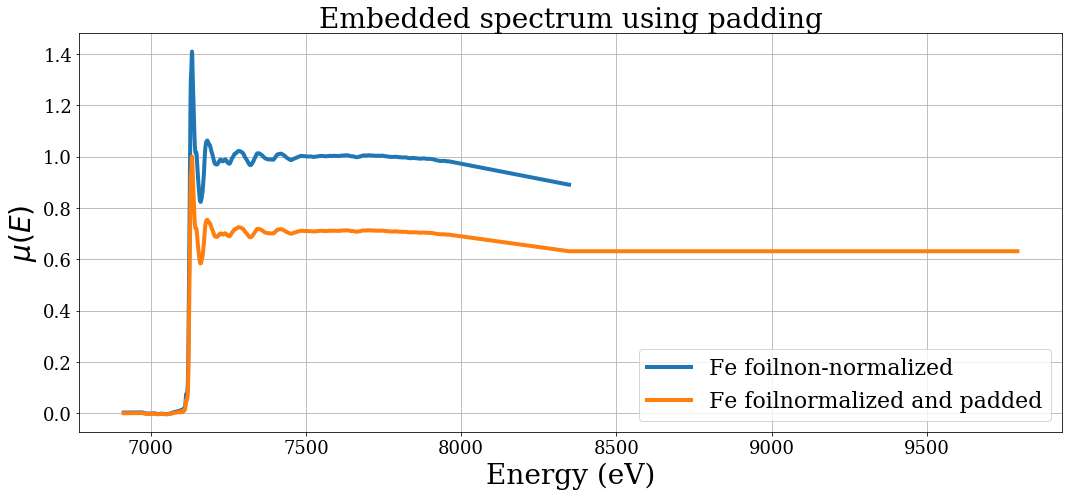

In [16]:
### Let's replot, normalizing first
plt.figure(figsize=(15,7))
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
i=0

for name in {names[1]}:
    # Unpacking ....
    # ...parameters
    parameters_now= parameters[name]
    xanes_now = parameters_now['xanes']
    E_now =parameters_now['energy']
    xanes_now_unpad = parameters_now['raw_xanes']
    E_now_unpad =parameters_now['raw_energy']
    plt.plot(E_now_unpad.T,xanes_now_unpad.T,color='C0', label = str(names[i])+'non-normalized',lw=4,linestyle='-')
    plt.plot(E_now.T,xanes_now.T,color='C1', label = str(names[i])+'normalized and padded',lw=4,linestyle='-')
    
    i+=1

plt.title('Embedded spectrum using padding', size=28)
plt.ylabel('$\mu(E)$',size=28)
plt.xlabel("Energy (eV)", size=28)
plt.legend(loc=4,prop={'size':22})
plt.grid(True)
figure_save("XANES_some_examples_normalized_and_embedded"+names[0])
plt.show()    


<h2><center> Applying the Rising Sun operator </h2></center>

Now we plot the spectrum with corresponding Rising Sun function

Saving figure as  XANES_and_rising_sunFe_foil


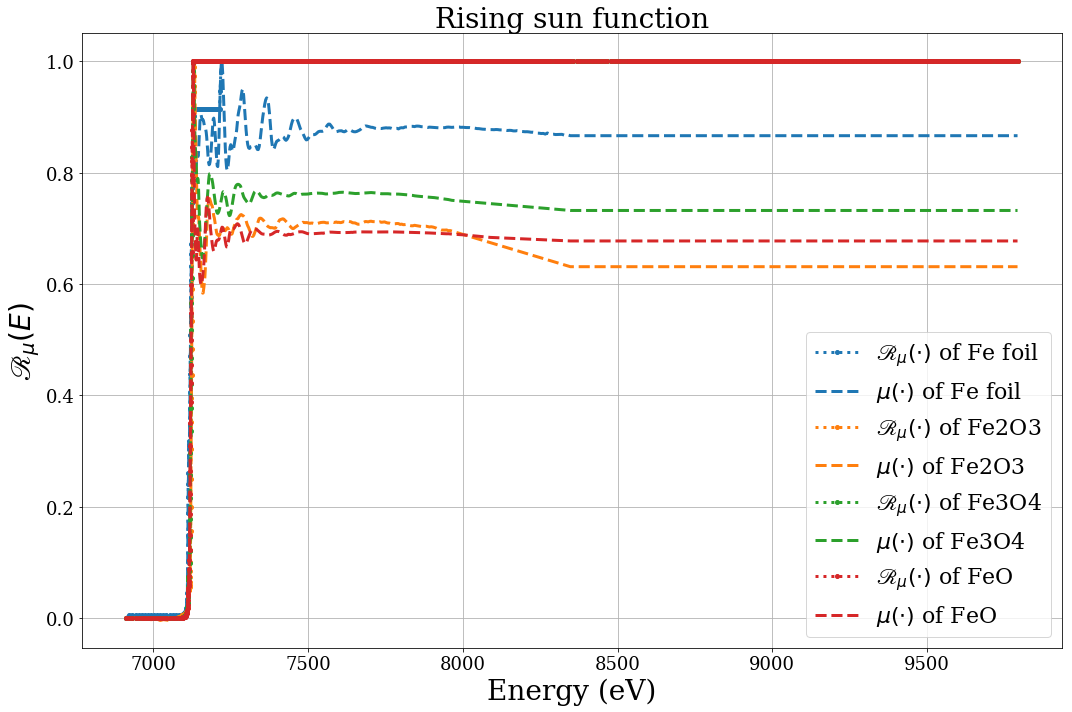

In [17]:
L = len(names)

rising_sun_f ={}
plt.figure(figsize=(15,10))
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

i=0  # a flag, used to vary the plot colors

for name in names:
    # Unpacking ....
    # ...parameters
    parameters_now = parameters[name]
    xanes_now = parameters_now['xanes']
    E_now =parameters_now['energy']
    xanes_now_unpad = parameters_now['raw_xanes']
    E_now_unpad =parameters_now['raw_energy']

    rising_sun_f[name] = rising_sun(xanes_now)
    plt.plot(
        E_now.T,rising_sun_f[name].T,color='C'+str(i%10),\
        label = '$\mathscr{R}_{\mu}(\cdot)$ of '+str(name),marker='o',markersize=4,lw=3,linestyle=':')
    plt.plot(E_now.T,xanes_now.T,color='C'+str(i%10), label ='$\mu(\cdot)$ of '+ str(name),lw=3,linestyle='--')
    i+=1
    
plt.title('Rising sun function',size=28)
plt.ylabel('$\mathscr{R}_{\mu}(E)$',size=28)
plt.xlabel("Energy (eV)", size=28)
plt.legend(loc=4,prop={'size': 22})
plt.grid(True)
figure_save("XANES_and_rising_sun"+names[0])
plt.show()    

We then plot the Valley of Shadows function, initially defined as

$$ \mathcal{V}_{\mu}(\cdot) =\mathcal{R}_{\mu}(\cdot) -  \mu(\cdot)$$

Saving figure as  valley_of_shadowsFe_foil


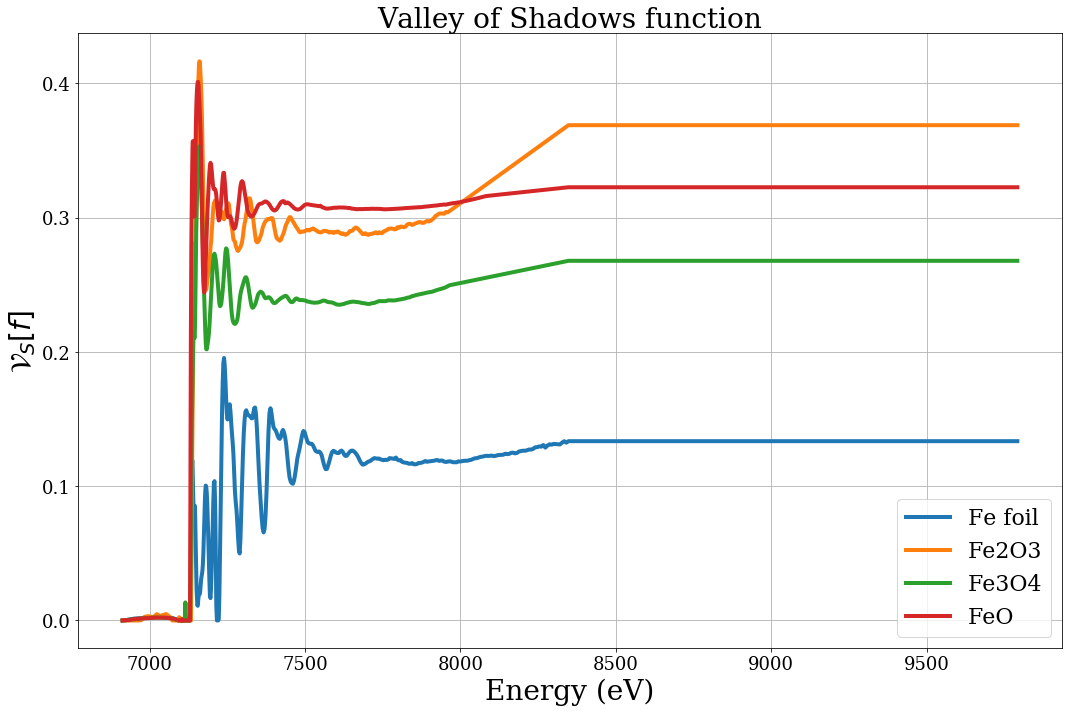

In [18]:
valley_of_shadows = {}

plt.figure(figsize=(15,10))
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

i=0

for name in names:
    # Unpacking ....
    # ...parameters
    parameters_now = parameters[name]
    xanes_now = parameters_now['xanes']
    E_now =parameters_now['energy']
    xanes_now_unpad = parameters_now['raw_xanes']
    E_now_unpad =parameters_now['raw_energy']

    valley_of_shadows[name] = rising_sun_f[name]- xanes_now #this function will always be nonnegative, thanks to (1)
    plt.plot(E_now.T,valley_of_shadows[name].T,color='C'+str(i%10), label =name,lw=4,linestyle='-')
    i+=1

plt.title('Valley of Shadows function',size=28)
plt.legend(loc=4,prop={'size': 22})
plt.ylabel(r"$\mathcal{V}_S[f]$",size=28)
plt.xlabel('Energy (eV)',size=28)
plt.grid(True)
figure_save("valley_of_shadows"+names[0])
plt.show()    

Just to give an idea of how these functions encode information, we plot one of them below:

Saving figure as  XANES_and_rising_sunFe2O3


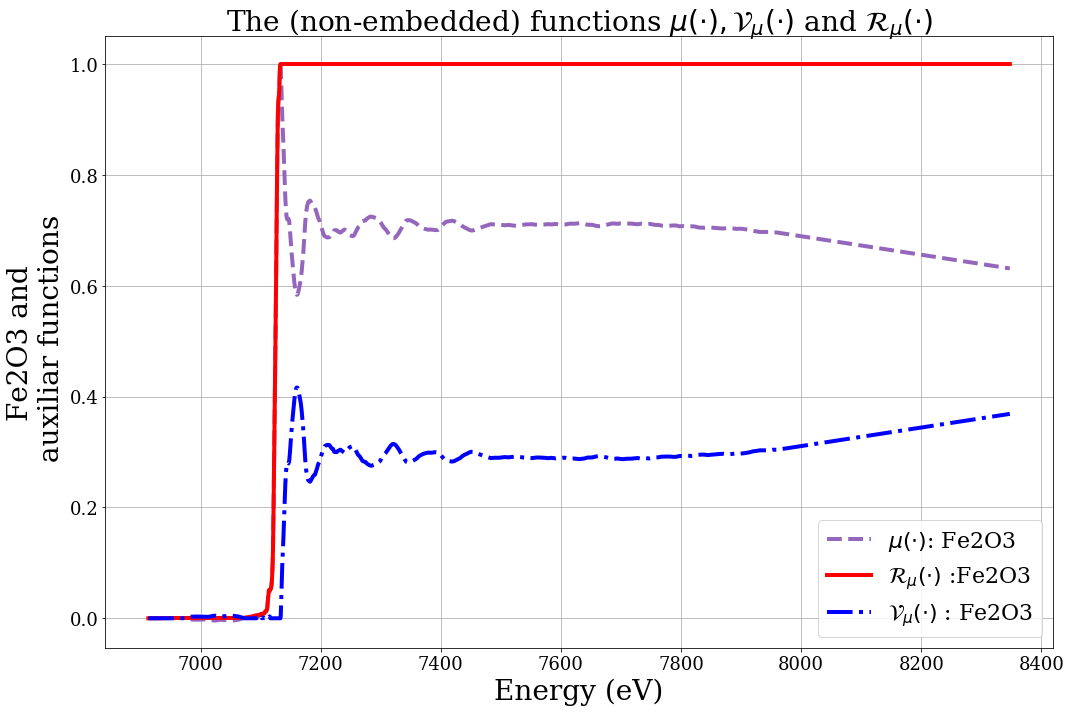

In [19]:

plt.figure(figsize=(15,10))
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

for name in {names[1]}:
    # Unpacking ....
    # ...parameters
    parameters_now = parameters[name]
    xanes_now = parameters_now['xanes']
    E_now =parameters_now['energy']
    xanes_now_unpad = parameters_now['raw_xanes']
    E_now_unpad =parameters_now['raw_energy']

    plt.plot(E_now[0,0:stopping[name]].T,xanes_now[0,0:stopping[name]].T,\
             color='C'+str(i%10),lw=4,linestyle='--', label = r"$\mu(\cdot)$: "+ str(name))
    plt.plot(E_now[0,0:stopping[name]].T,rising_sun_f[name][0,0:stopping[name]].T,\
             color='red',lw=4,linestyle='-', label = r"$\mathcal{R}_{\mu}(\cdot)$ :"+ str(name),markersize=2)
    plt.plot(E_now[0,0:stopping[name]].T,valley_of_shadows[name][0,0:stopping[name]].T,\
             color='blue',linestyle='-.',lw=4, label = r"$\mathcal{V}_{\mu}(\cdot)$ : "+ str(name))

plt.title(
    r"The (non-embedded) functions $\mu(\cdot),  \mathcal{V}_{\mu}(\cdot)$ and $\mathcal{R}_{\mu}(\cdot)$",
    size=28)
plt.ylabel(name+" and\n auxiliar functions",size=28)
plt.xlabel("Energy (eV)", size=28)

plt.legend(loc=4,prop={'size': 22})
plt.grid(True)
figure_save("XANES_and_rising_sun"+names[1])
plt.show()    

<h2><center>Estimating the oscilation and regularity</h2></center>

We designed a non-parametric way to estimate the oscillation

>Note: even though we are compiting the oscillation for the embedded version, this is not necessary. The invariants that we constructed also leave the oscillation, and peak locations invariant.<


The definition of the Oscillation function, as given by Def. I.4 in the paper, where we say that 

 \begin{align}
\omega_*^{\mu}(j \delta) = \max_{\vert E - E'\vert\leq j \delta } \vert \mu(E) - \mu(E')\vert, \tag{oscillation function}
 \end{align}
  is called  \textit{oscillation function} of $\mu(E)$; we set
 
 $$h_*= \omega_*^{\mu}(\delta)$$
 
 (or this quantity multiplied by a hyperparameter factor) as our trhreshold for height.

Saving figure as  Oscillation


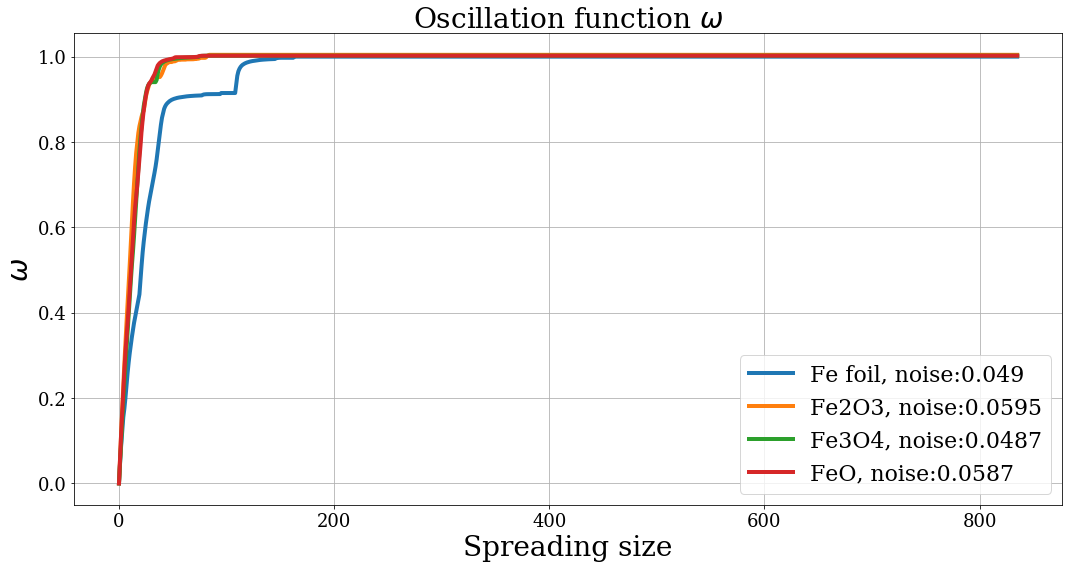

In [20]:
oscillation, interval, estimate={}, {}, {}

plt.figure(figsize=(15,8))
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

for name in names:
    # Unpacking ....
    # ...parameters
    parameters_now = parameters[name]
    xanes_now = parameters_now['xanes']
    E_now =parameters_now['energy']
    xanes_now_unpad = parameters_now['raw_xanes']
    E_now_unpad =parameters_now['raw_energy']

    (interval[name],oscillation[name], estimatE_now) = oscillation_function(E_now,xanes_now)
    new_label = name+", noise:" +str(round(estimatE_now,4))
    plt.plot(interval[name].T,oscillation[name].T,linestyle='-',lw=4, label=new_label)

plt.title('Oscillation function $\omega$',size=28)
plt.legend(loc=4,prop={'size': 22})
plt.ylabel('$\omega$',size=28)
plt.xlabel('Spreading size',size=28)
plt.grid(True)
figure_save("Oscillation")
plt.show()

I'll compute just the oscillation function of the Fe_calc to put in the paper

Saving figure as  OscillationFe2O3


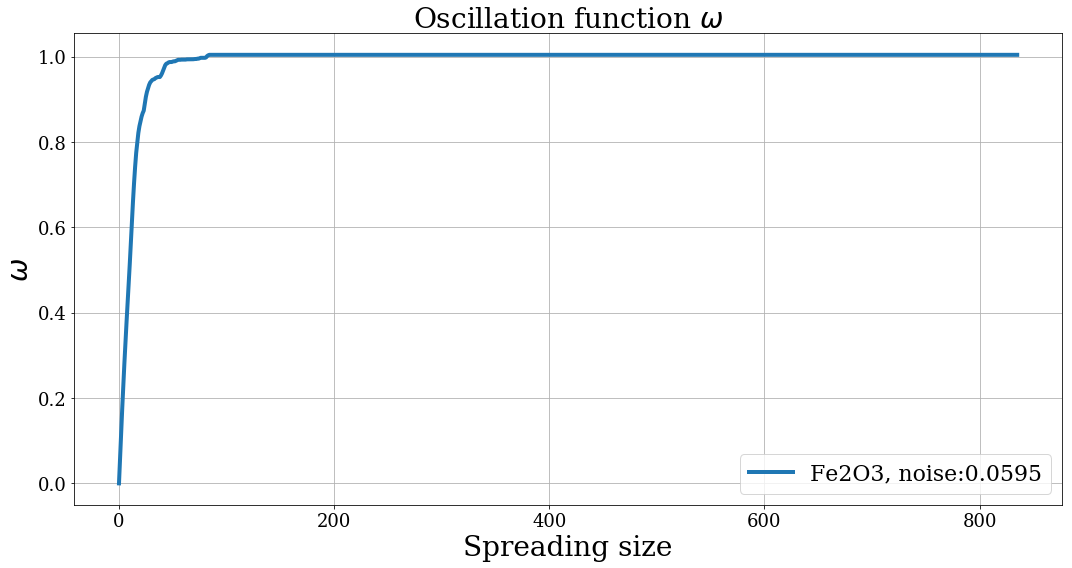

In [21]:
plt.figure(figsize=(15,8))
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

for name in {names[1]}:
    # Unpacking ....
    # ...parameters
    parameters_now = parameters[name]
    xanes_now = parameters_now['xanes']
    E_now =parameters_now['energy']
    xanes_now_unpad = parameters_now['raw_xanes']
    E_now_unpad =parameters_now['raw_energy']

    (interval[name],oscillation[name], estimatE_now) = oscillation_function(E_now,xanes_now)
    new_label = name+", noise:" +str(round(estimatE_now,4))
    plt.plot(interval[name].T,oscillation[name].T,linestyle='-',lw=4, label=new_label)

plt.title('Oscillation function $\omega$',size=28)
plt.legend(loc=4,prop={'size': 22})
plt.ylabel('$\omega$',size=28)
plt.xlabel('Spreading size',size=28)
plt.grid(True)
figure_save("Oscillation"+names[1])
plt.show()

Just to illustrate one of the theorems in the paper, we plot the oscillation function of the Rising sunf function

Saving figure as  Oscillation_denoising


<Figure size 1080x576 with 0 Axes>

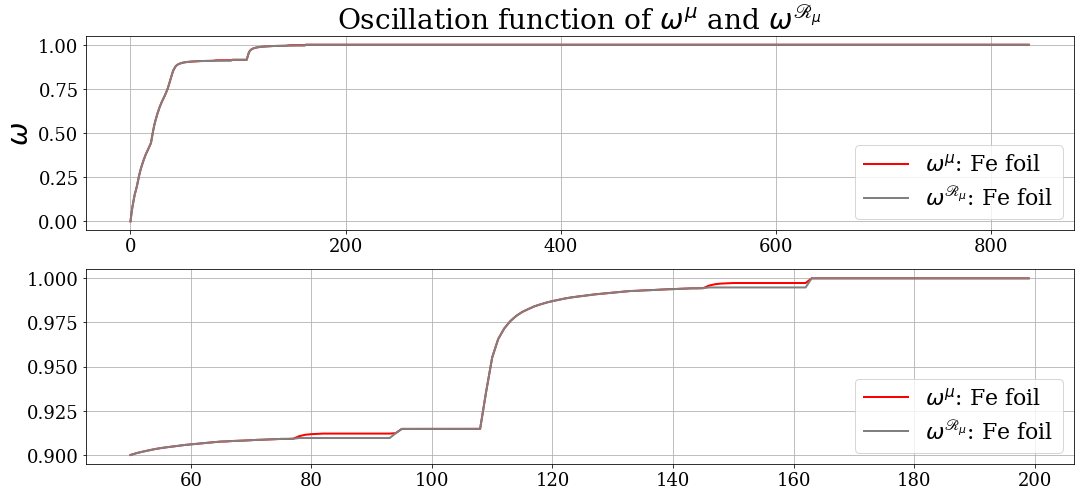

In [22]:

plt.figure(figsize=(15,8))
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

for name in {names[0]}:
    # Unpacking ....
    # ...parameters
    parameters_now = parameters[name]
    xanes_now = parameters_now['xanes']
    E_now =parameters_now['energy']
    xanes_now_unpad = parameters_now['raw_xanes']
    E_now_unpad =parameters_now['raw_energy']
    
    f = plt.figure(figsize=(15,7))
    
    ax1 = plt.subplot(211)
    new_label = name+", noise:" +str(round(estimatE_now,4))
    ax1.plot(interval[name].T,oscillation[name].T,linestyle='-',lw=2, label="$\omega^{\mu}$: "+name,color='r')
    
    (interval_rising,oscillation_rising, _) = oscillation_function(E_now,rising_sun_f[name])
    ax1.plot(interval_rising.T,oscillation_rising.T,linestyle='-',\
             lw=2, label="$\omega^{\mathscr{R}_{\mu}}$: "+name,color='gray')
    
    ax1.title.set_text('Oscillation function of $\omega^{\mu}$ and $\omega^{\mathscr{R}_{\mu}}$')
    ax1.title.set_fontsize(28)
    ax1.legend(loc=4,prop={'size': 22})
    ax1.set_ylabel('$\omega$',size=28)
    ax1.grid(True)
     
    ax2 = plt.subplot(212)
    new_label = name+", noise:" +str(round(estimatE_now,4))
    ax2.plot(interval[name][0,50:200].T,oscillation[name][0,50:200].T,linestyle='-',lw=2,\
             label="$\omega^{\mu}$: "+name,color='r')
    (interval_rising,oscillation_rising, _) = oscillation_function(E_now,rising_sun_f[name])
    ax2.plot(interval_rising[0,50:200].T,oscillation_rising[0,50:200].T,linestyle='-',\
             lw=2, label="$\omega^{\mathscr{R}_{\mu}}$: "+name,color='gray')
    ax2.legend(loc=4,prop={'size': 22})
    ax2.grid(True)
    
figure_save("Oscillation denoising")
plt.show()

For instance, one could compute the number of elements in the oscillation of Rising sun function that are above the oscillation of the xanes funtion

In [23]:
np.sum(1*(oscillation_rising>oscillation[names[0]]))

0

In [24]:
np.sum(1*(oscillation_rising==oscillation[names[0]]))

801

In [25]:
np.sum(1*(oscillation_rising<oscillation[names[0]]))

35

that is, these functions differ only in a small set (compared to the whole size of the domain).

<h2><center> Auxiliary function to compute decay rate</h2></center>

The following functions compute the decay rate in two possible ways:
1. computing averages
2. computing exponential decay using least squares

The advantage of using exponential decay is that it guarantees that the estimated height will be positive.

In [26]:
from sklearn.linear_model import LinearRegression
   
def decay_rate(
               parameters,hyperparameters,name,omega_oscillation,\
               jumps,vector_height_threshold,vector_peak_loc,\
               distances,j
):
    '''
    Given a vector with length N, compute the decay either as average or as a exponential rate of decay
    decay_rate_type == min_max or 'regression'
    ----------------
    Input:
    -parameters: dictionary with materials' properties
    -hyperparameters: hyperparamters dictionary
    -name: name of material whose decay is being studied
    -omega_oscillation: oscillation function
    -jumps: jumps[i] gives the value |intensity_peak[i-1] - intensity_peak[i]|
    -vector_height_threshold: the vector with the series (h_*^{(0)}, h_*^{(1)}, ..., h_*^{(j)})
    -vector_peak_loc: vector with peak locations (oth peak, 1st peak,...., jth peak)
    -distances: distance between peaks, up to distance between peak[j-1] and peak[j]
    -j: last peak that we have found
    ----
    
    It depends on the decay_rate_type:
    -If decay_rate_type == min_max:
        - hyperparameters used: lambda_d and lambda_h
        ## See paper for further explanation
    
    -If decay_rate_type == reversed:
        Uses the min-max method in the reverse passage.
        - hyperparameters used:lambda_d and lambda_h
        ## See paper for further explanation
    
    -If decay_rate_type == learn_to_trust:
        Uses same method as min_max to estimate h_threshold, but uses weighted method to average distance
        - hyperparameters used: lambda_d and lambda_h
    
    -If decay_rate_type == regression:
        Uses regression in a weighted fashio to estimate distance/plateaus size (see paper, equation (8))
        
        For the height threshold, uses a regression to estimate an exponential fit to XANES curve 
        to the right of jth-peak, then uses covariance matrix to estimate amount of oscillation in the remaining 
        curve in the same interval
    
        - hyperparameters used: lambda_d,  lambda_h, and stretching_factor
    ----------------
    Output:
    ----------------
    -decay_factor: alpha_n in the paper
    - dist_estimated: estimated distance/plateaus size
    - height_threshold: estimated height threshold
    - decay_plot dictionary with information about regression (only used when decay_rate_type == regression)
    
    ----------------
    '''
    # Unpacking ....
    # ...parameters
    parameters_now = parameters[name]
    xanes_now = parameters_now['xanes']
    E_now =parameters_now['energy']
    stop = parameters_now['stop']    

    # ... hyperparameters
    lambda_d = hyperparameters['lambda_d']
    lambda_h = hyperparameters['lambda_h']
    decay_rate_type = hyperparameters['decay_rate_type']
    start = vector_peak_loc[j-1]+1 #peak_loc[str(j-1)+name]
    
    ###################################
    if (decay_rate_type =='min_max'):
        decay_factor = (np.max(xanes_now[0,start:]) -np.min(xanes_now[0,start:]))/omega_oscillation[0,-1]
        height_threshold = decay_factor*lambda_h*vector_height_threshold[j-1]
        
        #### Old way
        ##dist_estimated = int( max(decay_factor,lambda_d)*np.average(distances))
        dist_estimated = max(int( max(decay_factor,lambda_d)*np.average(distances)),2)
            
        return decay_factor, dist_estimated,height_threshold,None
    
    ###################################
    elif decay_rate_type =='reversed':
        
        decay_factor = (np.max(xanes_now[0,start:]) -np.min(xanes_now[0,start:]))/omega_oscillation[0,-1]
        height_threshold = decay_factor*lambda_h*vector_height_threshold[j-1]
        dist_estimated = max(int(lambda_d*np.average(distances)),2)
            
        return decay_factor, dist_estimated,height_threshold,None
    
    ###################################
    
    elif decay_rate_type == 'learn_to_trust':
        
        decay_factor = (np.max(xanes_now[0,start:]) -np.min(xanes_now[0,start:]))/omega_oscillation[0,-1]
        height_threshold = decay_factor*lambda_h*vector_height_threshold[j-1]
        ## Take into account that j is always greater than 1
        dist_estimated = max( int(((lambda_d*np.exp(-(j-1)) +(j-1)/2)/j)*2*np.average(distances)),2)
            
        return decay_factor, dist_estimated,height_threshold,None
 
    ###################################
  
    else: #decay_rate_type = 'regression':
        decay_plot={}
        ###################################
        # We begin with aa log-regression for distance
        lin_reg_dist = LinearRegression()
        interval = np.reshape(np.arange(j),(-1,1))
        lin_reg_dist.fit(interval,np.log(np.reshape(distances,(-1,1))) )
        predicted_distance = np.exp(lin_reg_dist.predict(np.reshape(interval[-1,0],(-1,1))))
        dist_estimated = max( int(((lambda_d*np.exp(-(j-1)) +(j-1)/2)/j)*2*predicted_distance),2)
        
        decay_plot['regression_for_distance'] =lin_reg_dist
        
        ###################################
        
        #Then we use the estimated distance to do a regression for the height threshold
        stretching_factor= hyperparameters['stretching_factor']
        lin_reg_jumps = LinearRegression()
        E_for_pred = np.reshape(E_now[0,start:start+int(2*dist_estimated)],(-1,1))
        xanes_for_pred = np.reshape(xanes_now[0,start:start+int(2*dist_estimated)],(-1,1)) 

        lin_reg_jumps.fit(E_for_pred,xanes_for_pred)

        # predicted values. 
        pred = lin_reg_jumps.predict(E_for_pred)
        v = xanes_for_pred - pred

        residual = np.power(np.linalg.norm(v),2)/(len(E_for_pred)-2)
        X = np.c_[np.ones([len(E_for_pred),1]),E_for_pred]
        
        ## Preparation steps to use the covariance matrix
        M = np.linalg.inv(np.matmul(np.transpose(X),X))

        error = np.sqrt(np.diag(np.matmul(np.matmul(X,M),X.T))*residual)
        error = np.reshape(error,(-1,1))
        decay_plot ={'range_energy_pred':E_for_pred,'range_xanes_pred':pred,'error':error}        

        jumps_average = np.average(jumps)
        
        min_est = min(
            xanes_for_pred[0,0]- stretching_factor*error[0,0],\
            xanes_for_pred[-1,0]- stretching_factor*error[-1,0] 
        )
        max_est= max(
            xanes_for_pred[0,0]+ stretching_factor*error[0,0],\
            xanes_for_pred[-1,0]+ stretching_factor*error[-1,0] 
        )
        estimated_jump = max_est- min_est
        ##########################################
        decay_factor = estimated_jump/jumps_average
        height_threshold = decay_factor*vector_height_threshold[0]#np.average(vector_height_threshold)
        
        return decay_factor, dist_estimated,height_threshold,decay_plot 


<h2><center> Decomposing the XANES spectrum  </h2></center>


One of the biggest concerns we have in the beginning is having a good estimate for the distance between peaks. A good estimate would be

$$ \Delta \approx \vert x_1 - x_0 \vert, \quad \text{where} \quad \min\mu = \mu(x_0) \quad \text{and} \quad \max\{\mu\} - \mu(x_1).$$

The issue with this idea is due to (i) noise, which makes the minimum to get possibly concentrated on the extreme left; (ii) the maximum to be on the extreme right. 

An idea to avoid these issues is the following: to overcome the first issue, we define $x_1$ as

\begin{align}
x_1 &:= e_1
\end{align}

where e_1 is a local maximum with respect to $e_{-\infty}$ with threshold $\left(\min(5h_*,.5), \frac{e_{\infty}-e_{-\infty}}{4}\right)$ and posteriorly, we define $x_0$ as

\begin{align}
x_0 &:= \sup_{E\in (e_0,x_1)}\left\{\,E\,\Big|\,\mu(E) <\mu(e_{-\infty})+\omega(\mu)\right\}.
\end{align}

The benefits are clear: we overcome the issue of concentration on the extremities, finding a nice estimate for the size of the distance between heights and peaks. This algorithm is implemented below.


> This part of the code is very delicate and critical for a good algorithm bootstrap. I migth try some variations on it based on the size of the first plateau; it will be costier, but will allow us to avoid the issue of dependence on the maximum that stays close to the right end-point of the spectrum


In [27]:
def estimate_distance(parameters,hyperparameters,name,rising_sun,oscillation):
    '''
    This function estimate the distance between local maxixanes_nowm and minixanes_nown in order to bootstrap the algorithm. 
    The first step consists in estimating x_1, which will then be e_1
    and posteriorly estimates x_0
    ----------------
    Input:
    - parameters: dictionary with materials' properties
    - hyperparameters: hyperparamters dictionary
    - name: name of material whose decay is being studied
    - rising_sun: the rising sun function associated with xanes_now
    - oscillation, which given the intrinsic oscillation of xanes_now
    ----------------
    Output:
    The function output are
    (x_0,x_1): the location of the minixanes_nowm and that of the maxixanes_nowm in the half-interval  
    ----------------
    '''
    # Unpacking
    xanes_now= parameters[name]['xanes']
    lambda_h_find_1st = hyperparameters['lambda_h_find_1st']
    lambda_d_find_1st = hyperparameters['lambda_d_find_1st']
    
    ## We want tthe raw xanes measurement, prior to the embedding, so we do the following
    m = xanes_now.shape[1];
    new_xanes_now = np.array(xanes_now[0,0:int(m/2)],ndmin=2)  
        
    '''
    In the next part we choose the smallest argument for which the spectrum assumes its maxixanes_nowm point
    #x_1 = min(np.where(np.max(new_xanes_now)==new_xanes_now)[1])
    A second version consists of finding the first peak with thresholds (4*oscillation, length/4)
    '''
    ################################################################  
    locations, heights = plateau_detection(rising_sun,int(lambda_d_find_1st*m+1))
    
    # Now we retain only the elements that are higher than the threshold
    what_matters= np.where(heights>=min(lambda_h_find_1st*oscillation,.5))    ### Lmabda_h ==5 before
    locations, heights = locations[what_matters], heights[what_matters]
    x_1 = locations[0]
    #################################################################
    
    min_xanes_now = max(np.min(new_xanes_now), rising_sun[0,0]) ## WE do this in case the function starts in a valley
    
    x_0 = np.copy(x_1)
    while( new_xanes_now[0,x_0]>=min_xanes_now + oscillation): 
        x_0 =x_0 - 1
    # obviously x_0 =< x_1
    
    return (x_0, x_1)


There is a major change in the next code: now the code adapts itself to the case where no peak is found. If that is the case, it readjusts the distance threshold and also the height_threshold AUTOMATICALLY! This is indeed, a great improvement.

In [28]:
def find_peak(interval,f,h_threshold,L_threshold,num_iterations, iteration_flag,hyperparameters):
    '''
    This function finds a peak of the function f in an interval with certain height and spatial 
    thresholds. It does not have to estimate the tresholds
    
    ----------------
    Input:
    - interval: which is a row vector of shape 1xm
    - f: which is a row vector of shape 1xm
    - h_threshold: which denotes the peak threshold
    - L_threshold: an integer which denotes the plateau threshold
    -iteration_flag : only used in the case that no peak is found. Whenever that happens, it increase the 
                       iteration flag by 1. The upper bound for iteration flag is 20 
                        (hardcoded, but could be new hyperparameter)
    ----------------
    Output:
    - locations[0]:  index of peak location (integer)
    - interval[0,locations[0]]:  array value  of peak location (float)
    - heights[0]:  intensity at peak location (float)
    - num_iterations:  how many iterations were used.
    ----------------
    '''
    
    # Unpacking 
    iteration_decay = hyperparameters['iteration_decay']
    f_maximal = rising_sun(f)
    locations, heights = plateau_detection(f_maximal,L_threshold)
    
    # Now we detect the plateaus of f_maximal; the peak will be where the plateaus are located
    
    if (len(locations)==0): #locations==None):
        print("In find_peaks: L_threshold is", L_threshold,"iteration_flag", iteration_flag)
        if L_threshold >2 and (iteration_flag<=20):  
            if iteration_flag%2 ==0:
                return find_peak(
                interval,f,iteration_decay*h_threshold,L_threshold,num_iterations,iteration_flag+1,hyperparameters
            )
            
            else:
                return find_peak(
                interval,f,h_threshold,L_threshold-1,num_iterations,iteration_flag+1,hyperparameters
            )
            '''
       if L_threshold >2 and (iteration_flag<=10):       
            return find_peak(
                interval,f,iteration_decay*h_threshold,L_threshold-1,num_iterations,iteration_flag+1,hyperparameters
            )
            '''
        else:
            return (None,None,None,None)
            
    #now we  just need to check whether heigths is bigger than the threshold
    # notice that we can always assume that if location has the 0 index, then heights is also 0. 
    #This is due to normalization
    
    # Now we retain only the elements that are higher than the threshold
    what_matters= np.where(heights>=h_threshold)
    locations, heights = locations[what_matters], heights[what_matters]
    
    if len(locations)==0: 
        print("In find_peaks: L_threshold is", L_threshold,"iteration_flag", iteration_flag)
        if L_threshold >2 and (iteration_flag<=20):  
            if iteration_flag%2 ==0:
                return find_peak(
                interval,f,iteration_decay*h_threshold,L_threshold,num_iterations,iteration_flag+1,hyperparameters
            )
            
            else:
                return find_peak(
                interval,f,h_threshold,L_threshold-1,num_iterations,iteration_flag+1,hyperparameters
            )
        else:
            return (None,None,None,None)
        
    else: return (locations[0], interval[0,locations[0]], heights[0],num_iterations)

Initially we put this all together in a function that will be used only once throughout the code, but in a very special role of finding the first peak and gathering a lot of information about the first peak, the estimated distance to previous peak and so. 

The next function has a distinct feature when compared to the find_peak: it takes into account that the 0th peak is probably the highest one (this is a very particular case of XANES, and is probably where the code for other types of Spectroscopy should be changed). It has two parameters that deal with that:

    1.oscill_threshold: essentially, the parameter h_* as defined in the oscillation function equation shown above
    2. first_peak_threshold: this is a threshold for the first peak that is given by the following formula
    
\begin{align}
\textit{first_peak_threshold} = \left( 1+ \frac{\text{total_oscillation}}{(\lambda_5\cdot \text{oscill_threshold})}\right)\cdot \text{oscill_threshold} \tag{first_peak_threshold}.\end{align}
    
The first term in red aims to give a relative proportion between the total_oscillation in the XANES curve (which reduces to 1 in the case of normalized XANES measurement; see function normalization presented above) and the noise it contains; the quantity $\lambda_5$ is a hyperparameter.




In [29]:
def find_first_peak(
    parameters,hyperparameters, name,rising_sun,toscillation, oscill_threshold,first_peak_threshold
):
    
    '''
    This function finds the first peak of the function f in an interval with certain height and spatial 
    thresholds. Unlike "find_peak", it needs to estimate the thresholds
    
    ----------------
    Input:
    - parameters: dictionary with materials' properties
    - hyperparameters: hyperparamters dictionary
    - name: name of material whose decay is being studied
    - rising_sun
    , oscill_threshold: height_threshold, as given by Def I.4 in the paper
    - toscillation: oscillation function for current XANES measurement
    - first_peak_threshold: see explanation in previous markdown
    - rising_sun:  the Rising Sun function
    - L_threshold: an integer which denotes the plateau threshold
    -iteration_flag : only used in the case that no peak is found. Whenever that happens, it increase the 
                       iteration flag by 1. The upper bound for iteration flag is 20 
                        (hardcoded, but could be new hyperparameter)
    ----------------
    Output:
    
    - tpeak_loc0:  index of peak location (integer)
    - tpeak_energy0:  array value  of peak location (float)
    - tpeak_height0, :  intensity at peak location (float)
    - tnum_itera0:  how many iterations were used.
    - tdist_peak:  distance to previous peak
    - first_jump: jump in intensity (absolute value) when compared to previous peak
    
    ----------------
    '''
     # Unpacking
    lambda_d_shrink_1st = hyperparameters['lambda_d_shrink_1st']
    parameters_now = parameters[name]
    xanes_now = parameters_now['xanes']
    E_now =parameters_now['energy']
        
    ### Initial estimate for the distance between peaks, which we will use to feed the algorithm
    min_location, max_location = estimate_distance(parameters,hyperparameters,name,rising_sun,oscill_threshold)
    tdist_peak= np.array([int(lambda_d_shrink_1st*(max_location- min_location))],ndmin=1)  ## IT WAS 1/2 before
        
    # Find peak locations:
    iteration_flag=0
    tpeak_loc0,tpeak_energy0,tpeak_height0,tnum_itera0 = \
    find_peak(E_now,rising_sun,first_peak_threshold,tdist_peak[-1],0,iteration_flag,hyperparameters)
        
    # Last, now that we really know where the first peak is, we update it:
    tdist_peak=np.array([int(lambda_d_shrink_1st*(tpeak_loc0-min_location))]) ## IT WAS 1/2 before
    first_jump = xanes_now[0,tpeak_loc0] - xanes_now[0,min_location]
    
    return (tpeak_loc0, tpeak_energy0, tpeak_height0, tnum_itera0, tdist_peak, first_jump)

Initialy we just gave a crude estimate for the distanec between peaks and crests. However, once we reach the highest peak we can estimate again the distance between peaks

What we are going to do it to find the fist maximum of the difference function and then use the data to extrapolate.


First we write an auxiliary function to help us to print the data information



In [30]:
def print_brkpt_properties(j,peak_loc, peak_height, dist_peak, jumps):
    '''
    This function print the rpeakpoints properties:
    
    ----------------
    Input:
    - j: peak number
    - peak_loc: location of peak
    - peak_height: intensity of peak
    - dist_peak: distance to previous peak
    - jumps: intensity variation (in absolute value) with respect to previous peak
    ----------------
    Output:
    None
    ----------------
    '''
    print("\t Peak "+ str(j) +" located at: "+ str(peak_loc)) 
    print("\t Peak height:"+ str(peak_height) )    
    print("\t Distance between successive crests and peaks: ",dist_peak,"\n")
    print("\t Jumps: ",jumps,"\n")

(August 12, 2019) At this point, we shall implement the hidden breakpoints method, that I discovered yesterday:

In [31]:
def hidden_breakpoint(xanes_now,left,middle,right,j):
    '''
    Implements hidden peak trick
    ----------------
    Input:
    left<=middle<=right, three integer indexes
    j: j checks wheter we need to look for a hidden crest or a hidden valley
    ----------------
    Output:
    It depends on the input. 
        -If there is no need for it, it returns the midle.
        - If there is need for it, it will return the minimum  of the vector 
    
    ----------------
    '''   
    aux = xanes_now[0,left:right+1]
    if j%2==0:  M= min(aux)
    else: M= max(aux)
        
    if xanes_now[0,middle] ==M: ## In this case there is no need for the hidden peak trick
        return middle
    else: # in this case there was a problem, and we have to use the hidden peak trick
        return left+np.min(np.where(M == aux))

>__Remark:__ in the backstep move, the hidden peak trick can be iterated more than 2 times (in fact, it has to be iterated an even number of times). We took the minimal number of iterations by default, but a different upper bound on the number of iterations can be set as a hyperparameter.

Now we define a dictionary with search conditions

In [32]:
search_conditions = {
    'move':'backstep',#'middle_step',
    'printing':True,
    'polite_guess':{},
    'forward':True
}

And we are finally ready to implement the main algorithm 

In [33]:
def rising_sun_envelope_method(
    parameters,hyperparameters, name, N_split_before,N_split_after,search_conditions
):
    '''
    ----------------
    Input:
    - parameters: dictionary with materials' properties
    - hyperparameters: hyperparamters dictionary
    - name: name of material whose decay is being studied
    - N_split_before:
    - N_split_after:
    - search_conditions: dictionary with search conditions:
        - 'move':'backstep' or 'middle_step',
        'printing': if middle computations should be printed
        'polite_guess':{}, this is empty in the forward passing, but it is filled with first peak 
                        information in the reverse passing
        'forward':True or False, denotes which passage of the algorithm we are, that is, whether
                    looking fo peaks on the left of 0th peak or on the right
    ----------------
    Output:
    A dictionary - decomposition-  with the following keys:

    
    - peak_loc: dictionary index of peak location (integer), counted from 0th peak (positive to right, negative to the left)
    - peak_energy:array value  of peak location (float)
    - peak_height: intensity at peak location (float)
    - num_itera: how many iterations were used in inner loop that deals with peak not found
    - dist_peak: vector with  distance between scuccessive peaks
    - oscillation: oscillation function
    - height_threshold: vector with the series of height thresholds
    - jumps: jump in intensity (absolute value) when compared to previous peak
    - number_split_before_peak: number of splits after 0th peak (including it)
    - number_split_after_peak: number of splits after 0th peak (excluding it)
    - oscil_jump_ratio: at jth >0 (resp. j<0) entry, 
                        ratio between XANES curve from from peak j to end of measurement (begining to jth peak)
                        and the jump to previous (resp., next) peak
    ----------------
    '''
    ##############################################################
    # UNPACKING...
    # ... parameters
    parameters_now= parameters[name]
    stop = parameters_now['stop']    
    xanes_now = parameters_now['xanes']
    E_now =parameters_now['energy']
    
    # ...  hyperparameters
    lambda_h = hyperparameters['lambda_h']
    lambda_d = hyperparameters['lambda_d']
    init_oscil_par = hyperparameters['initial_oscillation_guess_parameter']
    
    # ...  search condition parameters
    move=search_conditions['move']
    printing=search_conditions['printing']
    polite_guess=search_conditions['polite_guess']
    forward = search_conditions['forward']
    ##############################################################
    
    if printing: 
        print("************************************** \n")
        print("Material:", name,"\n")

    start = 0
    
    # We shall save the resuls as dictionaries and vectors
    peak_loc, peak_energy, peak_height, num_itera,height_threshold = {},{},{},{},{}
    dist_peak,  jumps = [],[]
        
    ### Initializing some counters
    number_split_after_peak, number_split_before_peak, iteration_flag=0,0,0
    
    ## For book keeping purposes
    vector_peak_loc, vector_height_threshold =np.array([],dtype=np.int16), np.array([],dtype=np.float16)
    
    for j in range(max(N_split_after,1)):
        if (j==0):
            '''
            REMARK: j =0 is a case that is only considered in the forward passing.
                     It is necessary in order to find the first peak
                     This first part can be used as a bootstrap in order to find the distance:
            '''   
            if forward==False:
                '''
                If false, then we are in the reverse case, which means that these quantities need to be initialized
                '''
                # First of all, we recover the parameters we are going to use
                peak_loc[str(0)] = polite_guess['peak_loc_initial']
                rising_sun_f= polite_guess['initial_rising_sunf_f']
                height_threshold[str(0)]= polite_guess['initial_height_threshold']
                oscillation = polite_guess['initial_oscillation']
                critical_threshold= polite_guess['initial_critical_threshold']
                dist_peak = polite_guess['dist_peak_name']
                jumps = np.array([0])
            
                ### Book keeping
                vector_peak_loc = np.append(vector_peak_loc,peak_loc[str(0)])
                vector_height_threshold = np.append(vector_height_threshold,height_threshold[str(0)])
                continue
           
            if printing: 
                print("************************************** \n")
                print("\t Going for " +str(j)+"th breakpoint. \n")
            
            rising_sun_f = rising_sun(xanes_now)        
            
            ### This is where the oscillation function gets calculated
            _, oscillation, critical_threshold= oscillation_function(E_now,xanes_now)
            
            #This is where the compute the height threshold
            height_threshold["0"]=(int(oscillation[0,-1]/(init_oscil_par*critical_threshold)) + 1)*critical_threshold
            
            '''And this is where we look for the first peak
               We remark that it is here that part of the hyperparameters are used, in the function
               find_fisrst_peak > estimate_distance'''
            peak_loc["0"], peak_energy["0"], peak_height["0"],\
            num_itera["0"], dist_peak, jumps=\
            find_first_peak(
                parameters,hyperparameters, name,\
                rising_sun_f,oscillation, critical_threshold,\
                height_threshold["0"]
            )
            
            ### Book keeping
            vector_peak_loc = np.append(vector_peak_loc,peak_loc[str(j)])
            vector_height_threshold = np.append(vector_height_threshold,height_threshold[str(j)])
            
            if printing:  print_brkpt_properties(j,peak_loc[str(j)], peak_height[str(j)], dist_peak, jumps)
                
            number_split_after_peak +=1    
            
        #secondary cases - for which we have to use a maximal function
        elif j%2==0:
            if printing: 
                print("\t ***************************** \n")
                print("\t Going for " +str(j)+"th breakpoint. \n")
            start= peak_loc[str(j-1)]+1
            interval = np.array(E_now[0,start:],ndmin=2)
            
            #Truncate to the appropriate interval
            height_normalizer =  np.copy(xanes_now[0,start])
            f = np.array(xanes_now[0,start:],ndmin=2) -height_normalizer       ## you always normalize
            rising_sun_f = rising_sun(f)
            
            # Update the definition of the height threshold
            decay_factor, temp,height_threshold[str(j)],_ =\
            decay_rate(
                parameters,hyperparameters,name,oscillation, jumps,\
                vector_height_threshold,vector_peak_loc, dist_peak,j
            )
            tpeak_loc, tpeak_energy, tpeak_height, tnum_itera=\
            find_peak(
                interval,f,height_threshold[str(j)],temp,0,iteration_flag,hyperparameters
            )           
            
            if (tpeak_loc ==None) or (tpeak_loc+ start >=stop):  ### Then you can stop here!!!
                if printing: 
                    print("\n ONLY "+ str(number_split_after_peak)+" SPLITTINGS WERE POSSIBLE!\n") 
                break   
                
            peak_loc[str(j)], peak_energy[str(j)],peak_height[str(j)],num_itera[str(j)]=\
            tpeak_loc,tpeak_energy,tpeak_height,tnum_itera
            
            # We go back to the non-truncated vector
            peak_loc[str(j)] = peak_loc[str(j)] +start
            
            ### Book keeping
            vector_peak_loc = np.append(vector_peak_loc,peak_loc[str(j)])
            vector_height_threshold = np.append(vector_height_threshold,height_threshold[str(j)])
            
            ##Now we need to check whether hidden peak trick is necessary
            if j>=2:
                p = hidden_breakpoint(xanes_now,peak_loc[str(j-2)],peak_loc[str(j-1)],peak_loc[str(j)],j)
                ## MIDDLE MOVE
                if (move== 'middle_step') or (peak_loc[str(j-1)]==p):
                    peak_loc[str(j-1)]=p
                    peak_energy[str(j-1)]=E_now[0,p]
                    peak_height[str(j-1)]=xanes_now[0,p]
                    dist_peak[-1] = int(peak_loc[str(j-1)]- peak_loc[str(j-2)])
                
                    ### Recompute these quantities
                    start= peak_loc[str(j-1)]+1
                    #Truncate to the appropriate interval
                    height_normalizer =  np.copy(xanes_now[0,start])
                    f = np.array(xanes_now[0,start:],ndmin=2) -height_normalizer       ## you always normalize
                    rising_sun_f = rising_sun(f)
                    
                    # Recalculate decay factor
                    vector_peak_loc[j-1] =peak_loc[str(j-1)]
                    decay_factor, _,height_threshold[str(j)],_ =\
                    decay_rate(
                        parameters,hyperparameters,name,oscillation, jumps,vector_height_threshold,vector_peak_loc, dist_peak,j
                    )
                    jumps[-1] =  np.abs(xanes_now[0,peak_loc[str(j-1)]] - xanes_now[0,peak_loc[str(j-2)]])
                               
                else: ## BACKSTEP MOVE
                    ## Can be iterated, but we won't go for it
                    p = hidden_breakpoint(xanes_now,peak_loc[str(j-1)],p,p,j-1)
                    
                    peak_loc[str(j)]=p
                    ### we don't need to recompute the quantities f and rising_sun_f, just the jump and others
                    peak_energy[str(j)]=E_now[0,p]
                    
            #############################################################           
            #upgrade the dist_peak matrix
            
            dist_peak = \
            np.append(dist_peak,np.array([int(peak_loc[str(j)]- peak_loc[str(j-1)])]) ) 
            
            # unnormalize peak height
            peak_height[str(j)] = xanes_now[0,peak_loc[str(j)]]#==peak_height[str(j)]+height_normalizer
                                 
            # Book keeping    
            jumps = np.append(jumps, np.abs(xanes_now[0,peak_loc[str(j)]] - xanes_now[0,peak_loc[str(j-1)]]))
            
            if printing: 
                print_brkpt_properties(j,peak_loc[str(j)], peak_height[str(j)], dist_peak, jumps)
            
            number_split_after_peak +=1    
            
        ## third case, for which we use the valley_of_shadows function
        
        elif j%2 ==1:   
            if printing: 
                print("\t ***************************** \n")
                print("\t Going for " +str(j)+"th breakpoint. \n")
            # First: set up the interval of relevance
            start= peak_loc[str(j-1)]+1
            interval = np.array(E_now[0,start:],ndmin=2)
            
            #At this point we do the following: 
            #1) We truncate the maximal function from start to end
            #2) Construct first difference
            rel_start = start
            if j>1: rel_start -= (peak_loc[str(j-2)]+1)
            rising_sun_f = np.array(rising_sun_f[0,rel_start:],ndmin=2)
            f = np.array(xanes_now[0,start:],ndmin=2)
            valley_of_shadows = rising_sun_f- f #this function will always be nonnegative, thanks to (1)  
            
            ## Now we renormalize, because it has to start from 0
            valley_of_shadows = valley_of_shadows- valley_of_shadows[0,0] 
            f = np.array(valley_of_shadows,ndmin=2)
            
            ## UPDATES...
            #... of height threshold
            # Update the definition of the height threshold
            decay_factor, temp,height_threshold[str(j)],_ =\
            decay_rate(
                parameters,hyperparameters,name,oscillation, jumps,\
                vector_height_threshold,vector_peak_loc, dist_peak,j
            )
            
            tpeak_loc, tpeak_energy, tpeak_height, tnum_itera=\
            find_peak(interval,f,height_threshold[str(j)],temp,0,iteration_flag,hyperparameters)           
            
            if (tpeak_loc ==None) or (tpeak_loc+ start >=stop):  ### Then you can stop here!!!
                if printing: 
                    print("\n ONLY "+ str(number_split_after_peak)+" SPLITTINGS WERE POSSIBLE!\n") 
                break   
                
            peak_loc[str(j)], peak_energy[str(j)],peak_height[str(j)],num_itera[str(j)]=\
            tpeak_loc,tpeak_energy,tpeak_height,tnum_itera
            
            # We go back to the non-truncated vector
            peak_loc[str(j)] = peak_loc[str(j)]+ start
            
            ### Book keeping
            vector_peak_loc = np.append(vector_peak_loc,peak_loc[str(j)])
            vector_height_threshold = np.append(vector_height_threshold,height_threshold[str(j)])
            
            ##############################################################
            ##Now we need to check whether hidden peak trick is necessary
                
            if j>=2:
                p = hidden_breakpoint(xanes_now,peak_loc[str(j-2)],peak_loc[str(j-1)],peak_loc[str(j)],j)
            
                if (move== 'middle_step') or (peak_loc[str(j-1)]==p):
                    peak_loc[str(j-1)]=p
                    peak_energy[str(j-1)]=E_now[0,p]
                    peak_height[str(j-1)]=xanes_now[0,p]
                    dist_peak[-1] = int(peak_loc[str(j-1)]- peak_loc[str(j-2)])
                
                    ### Recompute these quantities
                    start= peak_loc[str(j-1)]+1
                    #Truncate to the appropriate interval
                    height_normalizer =  np.copy(xanes_now[0,start])
                    f = np.array(xanes_now[0,start:],ndmin=2) -height_normalizer       ## you always normalize
                    rising_sun_f = rising_sun(f)
                
                    # Recalculate decay factor
                    vector_peak_loc[j-1] =peak_loc[str(j-1)]
                    #vector_height_threshold[j]= height_threshold[str(j)] 
                    decay_factor,_,height_threshold[str(j)],_ =\
                    decay_rate(
                        parameters,hyperparameters,name,oscillation, jumps,vector_height_threshold,vector_peak_loc, dist_peak,j
                    )
                    jumps[-1] =  np.abs(xanes_now[0,peak_loc[str(j-1)]] - xanes_now[0,peak_loc[str(j-2)]])
                                        
                else: ## BACKSTEP MOVE
                    ## Can be iterated, but we will iterate only once
                    p = hidden_breakpoint(xanes_now,peak_loc[str(j-1)],p,p,j-1)
                    
                    peak_loc[str(j)]=p
                    ### we don't need to recompute the quantities f and rising_sun_f, just the jump and others
                    peak_energy[str(j)]=E_now[0,p]
                    
            ##############################################################
            #upgrade the dist_peak matrix
            dist_peak = \
            np.append(dist_peak,np.array([int((peak_loc[str(j)]- peak_loc[str(j-1)]))]) )        
           
            peak_height[str(j)] =xanes_now[0,peak_loc[str(j)]]        
            jumps = np.append(jumps, np.abs(xanes_now[0,peak_loc[str(j)]] - xanes_now[0,peak_loc[str(j-1)]]))
           
            if printing: 
                print_brkpt_properties(j,peak_loc[str(j)], peak_height[str(j)], dist_peak, jumps)
            
            number_split_after_peak +=1
            
    # In this part we figure out whether the algorithm goes for a second round of measurements, but now using 
    # the previous estimates on distance to improve the accuracy of this estimate
    
    ## Compute oscillation metric:
    oscil_jump_ratio ={}
    x, y = np.array(E_now[0,peak_loc["0"]:stop],ndmin=2),np.array(xanes_now[0,peak_loc["0"]:stop],ndmin=2)
    _,_, amount_oscil = oscillation_function(x,y, full_computation=False)
    oscil_jump_ratio["0"] =  amount_oscil/jumps[0]
    
    ##################
    # We need to do this because the algorithm is asymetric
    flag_oscillation =1
    if forward:
        flag_oscillation =0
        
    for i in range(1,number_split_after_peak +flag_oscillation):
        x, y = np.array(E_now[0,peak_loc[str(i)]:],ndmin=2),np.array(xanes_now[0,peak_loc[str(i)]:],ndmin=2)
        _,_, amount_oscil = oscillation_function(x,y, full_computation=False)
        oscil_jump_ratio[str(i)] =  amount_oscil/jumps[i]
        if np.isnan(oscil_jump_ratio[str(i)]):
            oscil_jump_ratio[str(i)] = np.inf
    ##################
    
    
    if N_split_before==0:
        if printing: 
            print("\n ONLY "+ str(number_split_after_peak+number_split_before_peak)+" SPLITTINGS \
            TO THE RIGHT OF THE MAIN PEAK WERE POSSIBLE!") 
        
        decomposition={
            'peak_location':peak_loc,'peak_energy':peak_energy,
            'peak_heights':peak_height,'number_iterations':num_itera,
            'distance_between_peaks':dist_peak, 'oscillation':oscillation,
            'height_threshold_evolution':height_threshold,'jumps':jumps,
            'number_of_splittings_before':number_split_before_peak, 
            'number_of_splittings_after':number_split_after_peak,
            'oscil_jump_ratio':oscil_jump_ratio
        }
        return decomposition
        
    ###############################################################################################      
    ### REVERSE PASSING:
    ### we reverse the spectra to do the search on the other side of the mountain
    ### At this point, the algorithm is using the previous data to improve the location of the peaks    
    ###############################################################################################      
    
    if printing: 
        print("************************************** \n")
        print("\t STARTING REVERSE PASSING, ON THE LEFT SIDE\n")
    # We want to include the peak_loc(0)
    chopped_xanes = np.array(xanes_now[0,:peak_loc["0"]+1],ndmin=2)
    chopped_E = np.array(E_now[0,:peak_loc["0"]+1],ndmin=2)
    
    ## Now we reverse these vectors
    chopped_xanes = np.array(chopped_xanes[0,::-1],ndmin=2)
    chopped_E = np.array(chopped_E[0,::-1],ndmin=2)
    
    ### REMARK: THE ABOVE TWO OPERATIONS ARE NOT COMMUTATIVE!!!
    
    if number_split_after_peak >1: # Then we can remove the first element
        dist_peak = dist_peak[1:]  # REMOVE FIRST ELEMENT!!!
        jumps = jumps[1:]  # REMOVE FIRST ELEMENT!!!
    
    ## And then we pad these vectors
    reverse_E,reverse_xanes, reverse_stop = \
    small_padded_spectra(chopped_E,chopped_xanes)
    
    # Things that we are going to use in the REVERSE PASSING
    # ... parameters
    reverse_N_split_after= N_split_before+1  # add 1 because we are not looking for 0 anymore
    reverse_N_split_before=0
    
    ##################################################################
    #Let's create a new parameters dictionary"
    reverse_parameters ={
        name:{'name':name,
              'xanes':reverse_xanes,
              'energy':reverse_E,
              'stop':reverse_stop }
    }
    "...and a new hyperparameters dictionary"
    reverse_hyperparameters={
         ## These hyperparameters will be used in 
        'lambda_h':1,'lambda_d':1/4,
        ## These hyperparameters will be used in find_first_peak
        'lambda_h_find_1st':4,'lambda_d_find_1st':1/4,
        #'lambda_d_shrink_1st':1/2, # WON'T BE NEEDED
        'initial_oscillation_guess_parameter':10,
      ## These hyperparameters will be used in 
        'stretching_factor':3,'iteration_decay':.9,'decay_rate_type': 'reversed'
    }
    # ...  search condition parameters. But before we do that we need to update a few things
    reverse_polite_guess={
        'peak_loc_initial':int(0),
        'initial_rising_sunf_f': rising_sun(reverse_xanes),
        'initial_height_threshold': height_threshold[str(0)],
        'initial_oscillation':oscillation,
        'initial_critical_threshold':critical_threshold,
        'dist_peak_name': int(np.average(dist_peak/4)),
        'jump': np.average(jumps/4)
    }
                                        
    reverse_search_conditions = {
        'move':'middle_step','printing':False,
        'polite_guess':reverse_polite_guess,'forward':False
    }
    ##################################################################
    
    # Then we call the same algorithm on this reversed spectrum.
    
    reverse_decomposition= \
    rising_sun_envelope_method(
        reverse_parameters,reverse_hyperparameters,name,\
        reverse_N_split_before, reverse_N_split_after,reverse_search_conditions
    )
    
    # Now we unpack the result
    reverse_peak_loc = reverse_decomposition['peak_location']  
    reverse_peak_energy = reverse_decomposition['peak_energy'] 
    reverse_peak_height = reverse_decomposition['peak_heights'] 
    reverse_num_itera = reverse_decomposition['number_iterations']  
    reverse_dist_peak = reverse_decomposition['distance_between_peaks']   
    reverse_oscillation = reverse_decomposition['oscillation'] 
    reverse_height_threshold = reverse_decomposition['height_threshold_evolution'] 
    reverse_number_splittings_before = reverse_decomposition['number_of_splittings_before']
    reverse_number_splittings_after = reverse_decomposition['number_of_splittings_after']
    reverse_jumps = reverse_decomposition['jumps'] 
    reverse_oscil_jump_ratio = reverse_decomposition['oscil_jump_ratio'] 
    
    #And in the end we need to put things together.
    # The terms don't need reflection, for they are invariant
    
    if number_split_after_peak >1: # Then we can remove the first element
        reverse_dist_peak = reverse_dist_peak[1:]
        reverse_dist_peak = reverse_dist_peak[::-1]
        dist_peak = np.append(reverse_dist_peak,dist_peak)                  
        
        reverse_jumps = reverse_jumps[1:]
        reverse_jumps = reverse_jumps[::-1]
        jumps = np.append(reverse_jumps,jumps)
    else:
        reverse_jumps = reverse_jumps[1:]
        jumps = reverse_jumps[::-1]
        
        reverse_dist_peak = reverse_dist_peak[1:]
        dist_peak = reverse_dist_peak[::-1]
        
    number_split_before_peak = reverse_number_splittings_after
    for k in range(1,number_split_before_peak+1):
        # unnormalize peak height
        peak_loc[str(-k)] =peak_loc["0"] - (reverse_peak_loc[str(k)])
        peak_energy[str(-k)] = reverse_peak_energy[str(k)]
        peak_height[str(-k)] = reverse_peak_height[str(k)]
        num_itera[str(-k)]  = reverse_num_itera[str(k)]  
        height_threshold[str(-k)] = reverse_height_threshold[str(k)]   
        oscil_jump_ratio[str(-k)] = reverse_oscil_jump_ratio[str(k)]
    
    if printing: 
        print("\n ONLY "+ str(number_split_before_peak)+" SPLITTINGS \
            TO THE LEFT OF THE MAIN PEAK WERE POSSIBLE!\n\n") 
        print("\n In TOTAL, ONLY "+ str(number_split_after_peak+number_split_before_peak)+" SPLITTINGS WERE POSSIBLE!\n") 
    
    decomposition={
        'peak_location':peak_loc,'peak_energy':peak_energy,
        'peak_heights':peak_height,'number_iterations':num_itera,
        'distance_between_peaks':dist_peak, 'oscillation':oscillation,
        'height_threshold_evolution':height_threshold,'jumps':jumps,
        'number_of_splittings_before':number_split_before_peak, 
        'number_of_splittings_after':number_split_after_peak,
        'oscil_jump_ratio':oscil_jump_ratio
    } 
    return decomposition    

Let's test the code!

In [34]:
search_conditions['printing'] = False
hyperparameters['lambda_d']=1/4
hyperparameters['decay_rate_type']= 'min_max'#'learn_to_trust'

In [35]:
def write_material_peak_properties(
    parameters,hyperparameters,search_conditions,\
    names, N_split_after, N_split_before
):
    '''
       ----------------
    Input:
    - parameters: dictionary with materials' properties
    - hyperparameters: hyperparamters dictionary
    - names: names of materials studied
    - N_split_before: upper bound on number of peaks to the right (always set to be greater than 1,
                      because 0th peak is included) 
    - N_split_after:upper bound on number of peaks to the left 
    - search_conditions: dictionary with search conditions:
        - 'move':'backstep' or 'middle_step',
        'printing': if middle computations should be printed
        'polite_guess':{}, this is empty in the forward passing, but it is filled with first peak 
                        information in the reverse passing
        'forward':True or False, denotes which passage of the algorithm we are, that is, whether
                    looking fo peaks on the left of 0th peak or on the right
    ----------------
    Output:
    - decompositions is a dictionary with names elements as keys, and elements are decomposition dictionary. 
    Each  decomposition dictionary has the  following keys:

    - peak_loc: dictionary index of peak location (integer), counted from 0th peak (positive to right, negative to the left)
    - peak_energy:array value  of peak location (float)
    - peak_height: intensity at peak location (float)
    - num_itera: how many iterations were used in inner loop that deals with peak not found
    - dist_peak: vector with  distance between scuccessive peaks
    - oscillation: oscillation function
    - height_threshold: vector with the series of height thresholds
    - jumps: jump in intensity (absolute value) when compared to previous peak
    - number_split_before_peak: number of splits after 0th peak (including it)
    - number_split_after_peak: number of splits after 0th peak (excluding it)
    - oscil_jump_ratio: at jth >0 (resp. j<0) entry, 
                        ratio between XANES curve from from peak j to end of measurement (begining to jth peak)
                        and the jump to previous (resp., next) peak
    '''
    decompositions={}
    ## We are going to split in N_split features
    for name in names:
        decompositions[name]=\
        rising_sun_envelope_method(
            parameters,hyperparameters,name, N_split_before, N_split_after,search_conditions
        )
 
    return decompositions


In [36]:
N_split_after, N_split_before=30, 5

decompositions =\
write_material_peak_properties(
    parameters,hyperparameters,search_conditions,names,N_split_after , N_split_before
)

In find_peaks: L_threshold is 4 iteration_flag 0
In find_peaks: L_threshold is 4 iteration_flag 1
In find_peaks: L_threshold is 3 iteration_flag 2
In find_peaks: L_threshold is 3 iteration_flag 3
In find_peaks: L_threshold is 2 iteration_flag 4
In find_peaks: L_threshold is 2 iteration_flag 0
In find_peaks: L_threshold is 6 iteration_flag 0
In find_peaks: L_threshold is 6 iteration_flag 1
In find_peaks: L_threshold is 5 iteration_flag 2
In find_peaks: L_threshold is 5 iteration_flag 3
In find_peaks: L_threshold is 4 iteration_flag 4
In find_peaks: L_threshold is 4 iteration_flag 5
In find_peaks: L_threshold is 3 iteration_flag 6
In find_peaks: L_threshold is 3 iteration_flag 7
In find_peaks: L_threshold is 2 iteration_flag 8


"decompositions" is a dictionary of dictionaries, and its keys are the names of each material. In each one of these sub-dictionaries we have many properties of each decomposition, as we show next

In [37]:
name = names[0]
decompositions[name].keys()

dict_keys(['peak_location', 'number_of_splittings_before', 'number_of_splittings_after', 'distance_between_peaks', 'height_threshold_evolution', 'number_iterations', 'jumps', 'oscillation', 'peak_energy', 'peak_heights', 'oscil_jump_ratio'])

The number of decompositions is the following:

In [38]:
for name in names:
    print(
        name,"has",decompositions[name]['number_of_splittings_before']," splittings before, and",\
        decompositions[name]['number_of_splittings_after'],"splittings after\n"
    )

Fe foil has 3  splittings before, and 30 splittings after

Fe2O3 has 1  splittings before, and 30 splittings after

Fe3O4 has 4  splittings before, and 26 splittings after

FeO has 1  splittings before, and 30 splittings after



In [39]:
def plot_marked_peak_spectrum(
    parameters,names,decompositions,\
    save_as,plot_type='normalized',\
    figure_extension="eps",loc=4,title = "XANES spectrum with marked peaks"
):
    '''
    This function plots the spectra in the dictionary parameters that are indexed by the elements in names, 
    and mark them with the peaks given in the dictionary decompositions
    The plots are saved with name save_as.
    Inputs can be normalized or not ('raw' case)
    
    ----------------
    Input:
    - parameters: dictionary with materials' properties
    - names: names of materials studied
    - decomposition: dictionary with information about peaks and their locations
    - plot_type: 'normalized' or 'raw'
    - figure_extension: 'png' or 'eps'
    - loc: number from {1,2, 3, 4,} where legend will be placed
    - title: title in the plot
    ----------------
    '''
    plt.figure(figsize=(15,10))
    plt.rc('font', family='serif')
    plt.rc('xtick', labelsize=18)
    plt.rc('ytick', labelsize=18)

    i = 0
    for name in names:
    ##############################################################
    # UNPACKING...
    # ... parameters
        # Unpacking
        stop = parameters[name]['stop']    
        if plot_type =='normalized':
            xanes_now = parameters[name]['xanes']
        elif plot_type =='raw':
            xanes_now = parameters[name]['raw_xanes']
        E_now =parameters[name]['energy']
        decomposition_now= decompositions[name]
        number_splittings_before = decomposition_now['number_of_splittings_before']
        number_splittings_after = decomposition_now['number_of_splittings_after']
        N = number_splittings_before+number_splittings_after
    
        plt.plot(
            E_now[0,0:stop].T,xanes_now[0,0:stop].T,\
            label =name+",#Breakpoints: "+str(N),color='C'+str(i%10),lw=3,linestyle='-',alpha=.7
        )
        plt.grid(True)
        i+=1
        
        # Plot a marker
        colors = ['g','y','r']
     
        proportion_noise_jump = decomposition_now['oscil_jump_ratio']
        values = [float(x) for x in list(proportion_noise_jump.values())]
        for i in range(len(values)):
            if np.isinf(values[i]):
                values[i] = 3.0
        
        for plots_iter in range(-number_splittings_before,number_splittings_after):
           # First peak marker
            position = decomposition_now['peak_location'][str(plots_iter)]
            plt.plot(
                E_now[0,position],xanes_now[0,position],\
                color=colors[min(int(np.floor(values[plots_iter])),2)], \
                label=None,marker='H',lw=4, markersize=12,alpha=.8
            )
               
    plt.title(title,size=28)
    plt.legend(loc=loc,prop={'size': 22})
    plt.xlabel('Energy (eV)',size=28)
    plt.ylabel('Absorption $\mu(E)$',size=28)
    figure_save(save_as,  figure_extension= figure_extension) 
    plt.show()    
     

Saving figure as  XANES_with_marked_peaks_average-middle_step


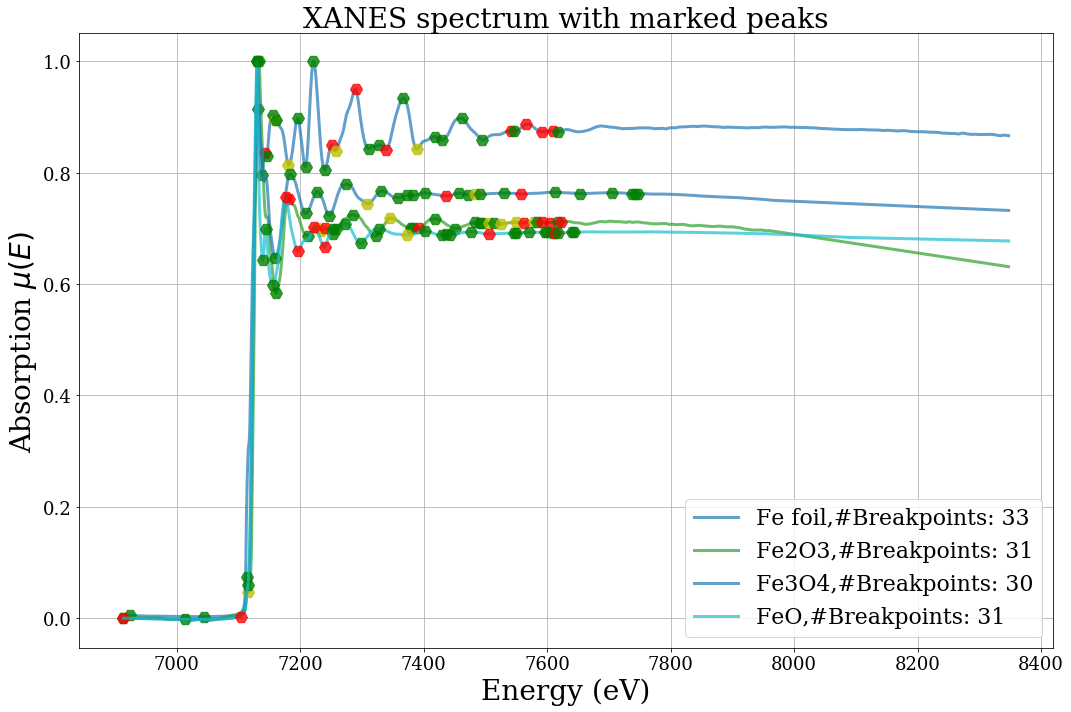

In [40]:
plot_marked_peak_spectrum(
    parameters,names,decompositions,\
    save_as="XANES_with_marked_peaks_average-middle_step",\
    plot_type='normalized'#'raw'
)

It is easier to visualize in the normalized version

Saving figure as  XANES_with_marked_peaks_average-middle_step


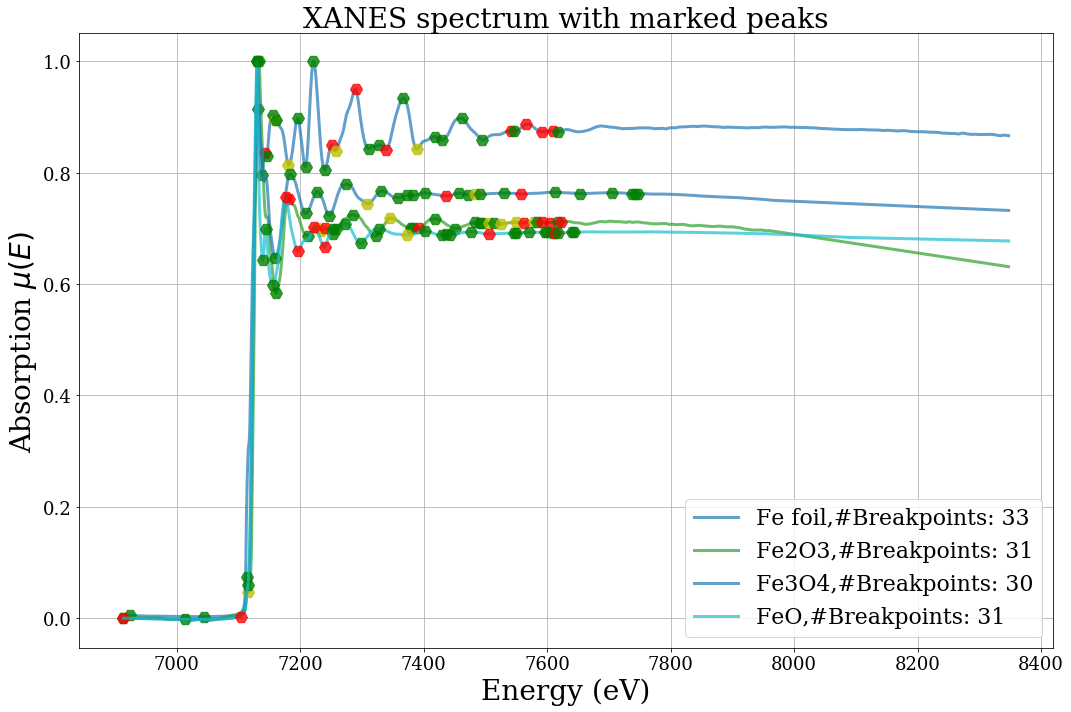

In [41]:
plot_marked_peak_spectrum(
    parameters,names,decompositions,\
    save_as="XANES_with_marked_peaks_average-middle_step",\
    plot_type='normalized',
    figure_extension="png"
)

which in the original, non normalized spectrum, corresponds to 

Saving figure as  raw_XANES_with_marked_peaks_average


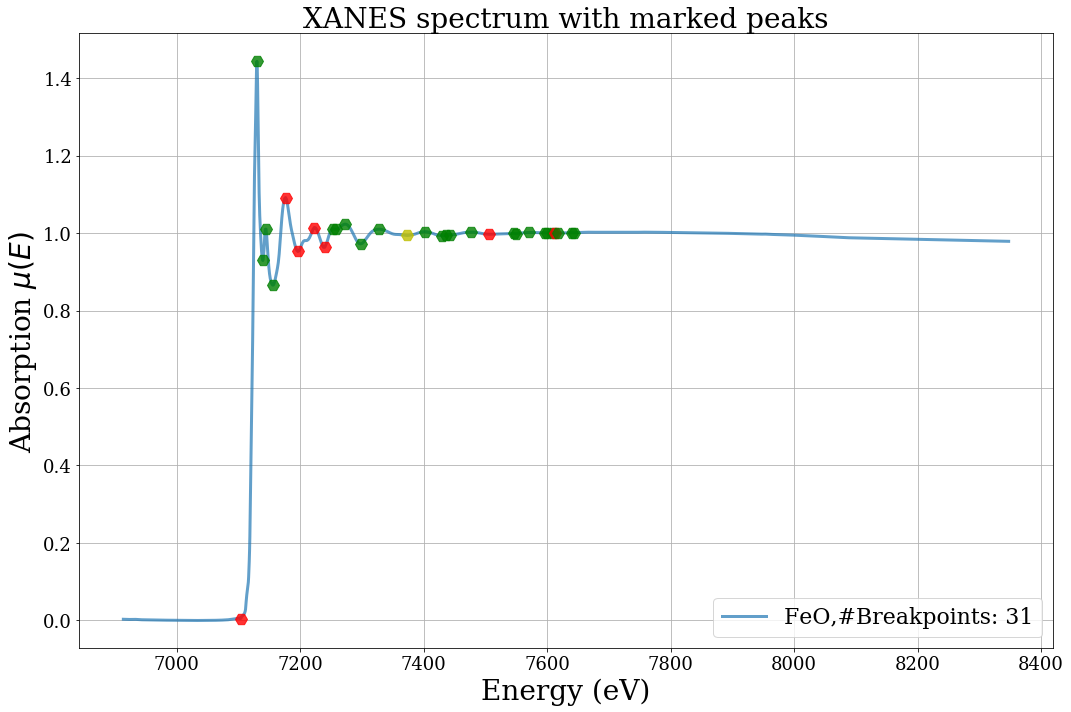

In [42]:
plot_marked_peak_spectrum(
    parameters,{names[3]},decompositions,"raw_XANES_with_marked_peaks_average",plot_type="raw"
)

## Decay rate plots for the regression method

In [43]:
dict_iter ={'1':'blue','2':'cyan','4':'purple'}

Saving figure as  Studying_decay_regression_method


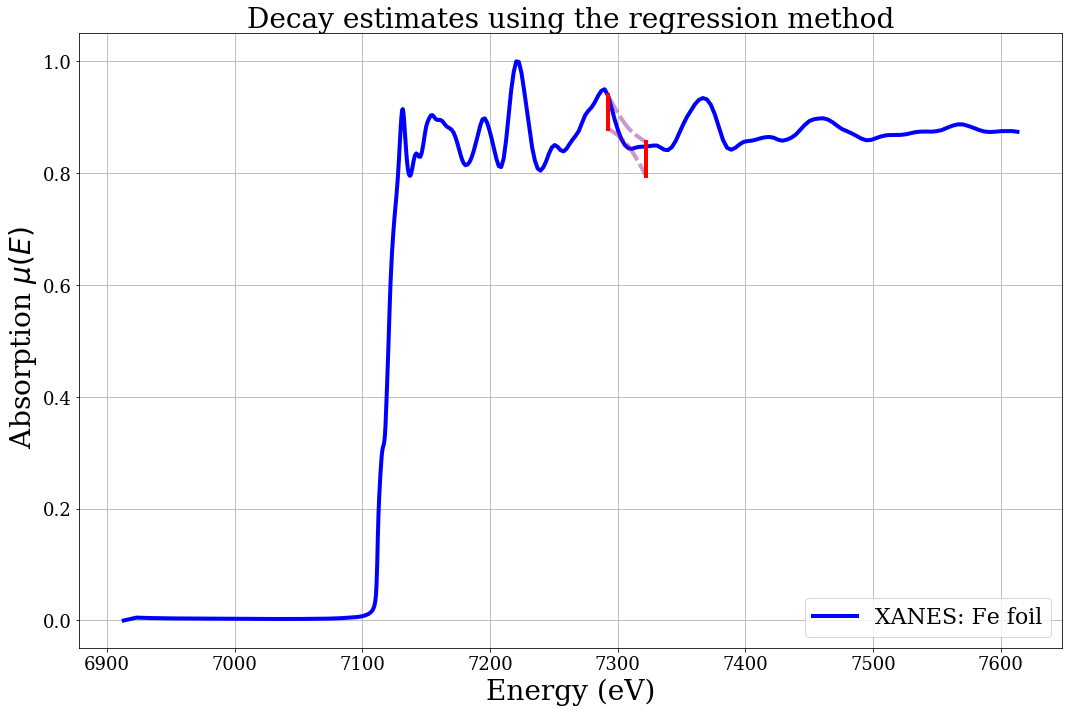

In [44]:
from matplotlib.animation import FuncAnimation
##############################################################
# UNPACKING...
# ... parameters
name = names[0]
stop = parameters[name]['stop']
E_now = parameters[name]['energy']
xanes_now = parameters[name]['xanes']

# ...decomposition properties
decomposition_now = decompositions[name]
peak_height = decomposition_now['peak_heights']
vector_dist_peak = decomposition_now['distance_between_peaks']
height_threshold = decomposition_now['height_threshold_evolution']
jumps = decomposition_now['jumps']
peak_loc = decomposition_now['peak_location']
number_splittings_before = decomposition_now['number_of_splittings_before']
number_splittings_after = decomposition_now['number_of_splittings_after']
omega_oscillation = decomposition_now['oscillation']
        
vector_height_threshold= [height_threshold[str(j)] for j in range(0,number_splittings_after)]
vector_peak_loc = [peak_loc[str(j)] for j in range(0,number_splittings_after)]

##Redefine stop
stop =vector_peak_loc[-1]
k = 15 ### Always an integer >= 1

vector_dist_peak_after= vector_dist_peak[number_splittings_before:number_splittings_before+k]

plt.figure(figsize=(15,10))
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.plot(E_now[0,:stop].T,xanes_now[0,:stop].T,color='blue',lw=4,linestyle='-',label='XANES: '+name,alpha=1)

hyperparameters['decay_rate_type']= 'regression'

_ , _ ,d , decay_plot =decay_rate(
    parameters,hyperparameters,name,\
    omega_oscillation, jumps,vector_height_threshold,\
    vector_peak_loc, vector_dist_peak_after,k
)

# Unpacking
pred  = decay_plot['range_xanes_pred']
E_for_pred = decay_plot['range_energy_pred']
error= decay_plot['error']
colors= ['red','orange','purple','green','black']
'''
for k in range(4):

    plt.plot(E_for_pred,(pred+np.power(2,k)*error),color=colors[k],linestyle='-.',lw=3,alpha=.3+.1*int(k))
    plt.plot(E_for_pred,(pred-np.power(2,k)*error),color=colors[k],linestyle='-.',lw=3,label=str(k)+'band',alpha=.3+.1*int(k))
    plt.grid(True)
    plt.legend()
'''
l=1
stretching_factor=3
plt.plot(E_for_pred,(pred+stretching_factor*error),color='purple',linestyle=(0,(5,1)),lw=4,alpha=.3+.1*int(l))
plt.plot(E_for_pred,(pred-stretching_factor*error),color='purple',linestyle=(0,(5,1)),lw=4,label=None,alpha=.3+.1*int(l))


# On the left
plt.plot([E_for_pred[0],\
            E_for_pred[0]],[pred[0,0]-stretching_factor*error[0,0],pred[0,0]+stretching_factor*error[0,0]],'-',\
         lw=4,color='red')
# On the right
plt.plot([E_for_pred[-1],\
            E_for_pred[-1]],[pred[-1,0]-stretching_factor*error[-1,0],pred[-1,0]+stretching_factor*error[-1,0]],'-',\
         lw=4,color='red')

plt.legend(loc=4,prop={'size':22}) 
plt.title('Decay estimates using the regression method',size=28)
plt.ylabel(r" Absorption $\mu(E)$",size=28)
plt.xlabel('Energy (eV)',size=28)

plt.grid(True)    
figure_save('Studying_decay_regression_method',figure_extension='png')

## Some statistics on decay rates about the main peak

As said before, the decay rate does not need to be of the type

$$\alpha_{\text{decay}}^{(i)} = \frac{\max_{e_i\leq E,F\leq e_{\infty}}\vert\mu(E)- \mu(F)\vert}{\max_{e_{-\infty}\leq E,F\leq e_{\infty}}\vert\mu(E)-\mu(F)\vert}$$

and in this section we study some other possible decay rates using regression


We are going to compare the decay rates using the parameter above with that using the peak heights decay




In [45]:
from sklearn.linear_model import LinearRegression

## To create my own legend
import matplotlib.patches as mpatches

## To avoid all the annoying deprecated warnings in matplotlib
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)


a) Statistics with jumps

We shall prot the graph and the jumps right below it

In [46]:
def stat_plot_jumps(name,parameters,decompositions,number_points,saveas='Statistics',plotting=True):

    '''
    This function plots the XANES spectrum with marked peaks. In a second plot, at the position of a peak j 
    it plots the jump (absolute value of difference in  intensity) between the value of absorption at the peak j
    to that of peak j-1
    ----------------
    Input:
    - parameters: dictionary with materials' properties
    - names: names of materials studied
    - decomposition: dictionary with information about peaks and their locations
    - number_points: number of peaks that we want to do statistics on
    - saveas:  name  of saved figure
    - plotting: plot figure (True) or not  (False)
    ----------------
    Output:
    ----------------
    - 
    '''
    if plotting:
        plt.figure(figsize=(20,10))
        plt.rc('font', family='serif')
        plt.rc('xtick', labelsize=18)
        plt.rc('ytick', labelsize=18)
    
    ##############################################################
    # UNPACKING...
    # ... parameters
    print("Statistics for", name,"\n")
    parameters_now = parameters[name]
    stop = parameters_now['stop']
    E_now = parameters_now['energy']
    xanes_now = parameters_now['xanes']

    # ...decomposition properties
    decomposition_now = decompositions[name]
    peak_height = decomposition_now['peak_heights']
    vector_dist_peak = decomposition_now['distance_between_peaks']
    height_threshold = decomposition_now['height_threshold_evolution']
    jumps = decomposition_now['jumps']
    peak_loc = decomposition_now['peak_location']
    number_splittings_before = decomposition_now['number_of_splittings_before']
    number_points = min(decomposition_now['number_of_splittings_after'], number_points)
    omega_oscillation = decomposition_now['oscillation']
    
    # New quantities
    alpha_before = np.zeros(number_splittings_before)  # We shall put tehe alpha values here
    jumps_before =jumps[0:number_splittings_before]
    alpha_after = np.zeros(number_points-1)    # We shall put tehe alpha values here
    jumps_after = jumps[number_splittings_before-1:]
    
    #To the right of the main peak
    vector_height_threshold_used= [height_threshold[str(j)] for j in range(0,number_points)]
    '''
    We shall plot the xanes measurement and the peak variations'''
    f = plt.figure(figsize=(15,7))
    ax1 = plt.subplot(111)
   
    where_to_stop_plot = int(.8*peak_loc[str(number_points-1)]+.2*stop)
    ax1.plot(E_now[0,:where_to_stop_plot].T,xanes_now[0,:where_to_stop_plot].T,color='blue',lw=4) # Plot xanes spectrum 
    ax1.grid(True)
    e =  [E_now[0,peak_loc[str(0)]]]
    vector_height_threshold= []
              
    start_from =0
    
    for i in range(start_from,number_points-1):
        
        alpha_after[i] =\
        np.max(xanes_now[0,peak_loc[str(i)]:])-np.min(xanes_now[0,peak_loc[str(i)]:])/omega_oscillation[0,-1]
        plt.subplot(111)
    
        _,_,h_threshold =\
        oscillation_function(\
                             np.array(E_now[0,peak_loc[str(i)]:stop],ndmin=2),\
                             np.array(xanes_now[0,peak_loc[str(i)]:stop],ndmin=2),\
                             full_computation=False)
    ############################
        ### How much of the jump is noise?
        proportion_noise_jump=h_threshold/jumps_after[i]
        colors = ['g','y','r']
     
    # Plot a marker
        ax1.plot(E_now[0,peak_loc[str(i)]],xanes_now[0,peak_loc[str(i)]],\
                 color=colors[min(int(np.floor(proportion_noise_jump)),2)], marker='H',label=None,  markersize=16,alpha=.8,lw=4)
        
        # 'amount of variation from this point on
        ax1.bar(E_now[0,peak_loc[str(i)]],jumps_after[i],width=4,color='red')
        plt.title('Jumps with respect to previous breakpoint')
        plt.grid(True)
    #########################################
    ## LEGENDS...
    red_patch = mpatches.Patch(color='red',alpha=.4, label='Relative jump')
    blue_patch = mpatches.Patch(color='blue', label='xanes')

    ax1.legend(handles=[red_patch, blue_patch],prop={'size':22})
    plt.xlabel('Energy (eV)',size=22)
    plt.ylabel('Absorption $\mu(E)$ (Normalized)',size=22)
    plt.title("Study of decay rates",size=28)
    figure_save(saveas,figure_extension='png')
    plt.show()

Statistics for Fe foil 

Saving figure as  Statistics_Fe_foil


<Figure size 1440x720 with 0 Axes>

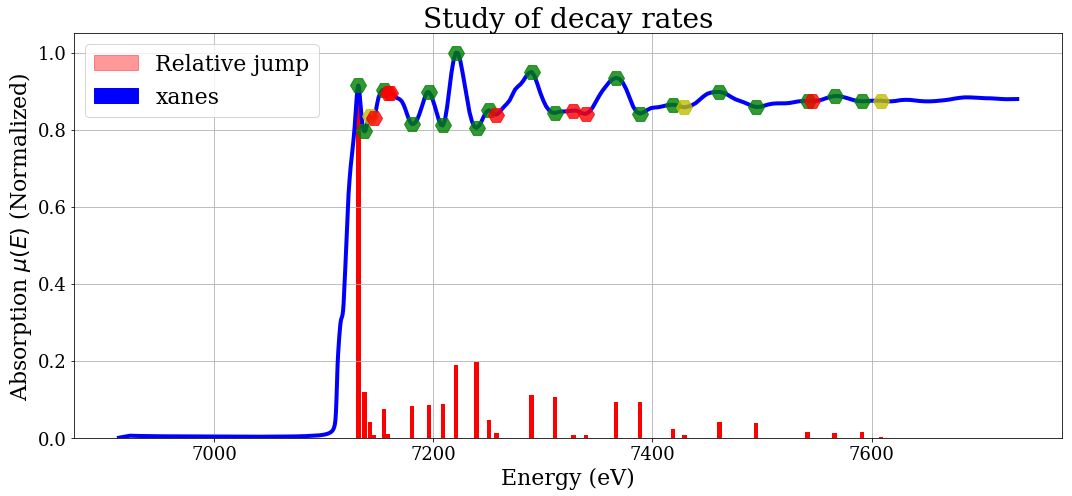

In [47]:
for name in {names[0]}:
    number_points = decompositions[name]['number_of_splittings_after']
    stat_plot_jumps(name,parameters,decompositions,number_points,saveas='Statistics '+name, plotting=True)

Our second statistics plot will be the following

In [48]:
def stat_jumps_and_oscillation(name,parameters,decompositions,number_points,saveas='Statistics',plotting=True):
    '''
    This function plots, at each peak, the ratio between amount of oscillation in the measurement
    to the right of the peak and the jump between the present peak to the previous one.
    That is, at the j-th peak located at peak_j, we calculate
    
    ratio: oscillation[peak_j:end]/(abs( jump[j] - jump[j-1]))
    
    The ratio is distributed in three classes:
    
    ratio <= 1 (green color); 1<ratio <=2 (yellow color), and 2<ratio (red color)
    ----------------
    Input:
    - parameters: dictionary with materials' properties
    - names: names of materials studied
    - decomposition: dictionary with information about peaks and their locations
    - number_points: number of peaks that we want to do statistics on
    - saveas:  name  of saved figure
    - plotting: plot figure (True) or not  (False)
    ----------------
    '''
    if plotting:
        plt.figure(figsize=(15,7))
        plt.rc('font', family='serif')
        plt.rc('xtick', labelsize=18)
        plt.rc('ytick', labelsize=18)
    
    ##############################################################
    # UNPACKING...
    # ... parameters
    print("Statistics for Jumps and Oscillation, for ", name,"\n")
    parameters_now = parameters[name]
    stop = parameters_now['stop']
    E_now = parameters_now['energy']
    xanes_now = parameters_now['xanes']

    # ...decomposition properties
    decomposition_now = decompositions[name]
    jumps = decomposition_now['jumps']
    peak_loc = decomposition_now['peak_location']
    peak_height = decomposition_now['peak_heights']
    omega_oscillation = decomposition_now['oscillation']
    vector_dist_peak = decomposition_now['distance_between_peaks']
    height_threshold = decomposition_now['height_threshold_evolution']
    number_splittings_before = decomposition_now['number_of_splittings_before']
    number_points = min(decomposition_now['number_of_splittings_after'], number_points)
    
    # New quantities
    alpha_before = np.zeros(number_splittings_before)  # We shall put tehe alpha values here
    jumps_before =jumps[0:number_splittings_before]
    alpha_after = np.zeros(number_points-1)    # We shall put tehe alpha values here
    jumps_after = jumps[number_splittings_before-1:]
   
    # Small plot of xanes measurement on top
    where_to_stop_plot = int(.8*peak_loc[str(number_points-1)]+.2*stop)
    
    f,(ax1,ax2)= plt.subplots(2,1,sharex=True, gridspec_kw={'height_ratios': [1, 5]},figsize=(15,7))
    ax1.set_yticks([0, .5, 1])
    ax1.plot(E_now[0,:where_to_stop_plot].T,xanes_now[0,:where_to_stop_plot].T,color='blue',lw=4) # Plot xanes spectrum 
    ax1.grid(True)
    
    #To the right of the main peak
    vector_proportion= []
    "We shall plot the xanes measurement and the peak variations"
    start_from =0
    
    for i in range(start_from,number_points-1):
         ### Now we plot the h_threshold
        _,_,h_threshold =\
        oscillation_function(\
                             np.array(E_now[0,peak_loc[str(i)]:stop],ndmin=2),\
                             np.array(xanes_now[0,peak_loc[str(i)]:stop],ndmin=2),\
                             full_computation=False)
    ############################
        ### How much of the jump is noise?
        proportion_noise_jump=h_threshold/jumps_after[i]
        vector_proportion.append(proportion_noise_jump)
        colors = ['g','y','r']
        # Plot a marker
        ax1.plot(E_now[0,peak_loc[str(i)]],xanes_now[0,peak_loc[str(i)]],\
                 color=colors[min(int(np.floor(proportion_noise_jump)),2)], marker='o',label=None,  markersize=8,alpha=1,lw=4)
        
        ax2.plot(E_now[0,peak_loc[str(i)]],proportion_noise_jump,\
                 color=colors[min(int(np.floor(proportion_noise_jump)),2)], marker='o',label=None,  markersize=12,alpha=1)
        plt.grid(True)
        
        #########################################
    plt.title("Comparison: proportion of oscillation and jump",size=28)
    M=max(vector_proportion)
    ax2.axhspan(-1, 1, facecolor='g', alpha=0.05)
    ax2.axhspan( 1,2, facecolor='y', alpha=0.05)
    ax2.axhspan( 2,3*M, facecolor='r', alpha=0.05)
    plt.margins(0) 
    plt.xlabel('Breakpoint energy position (eV)',size=22)
    plt.ylabel('log(oscillation/jump)',size=22)
    
    plt.yscale('log')
    figure_save(saveas,figure_extension='png')
    plt.show()

Statistics for Jumps and Oscillation, for  Fe foil 

Saving figure as  Proportion_oscillationFe_foil


<Figure size 1080x504 with 0 Axes>

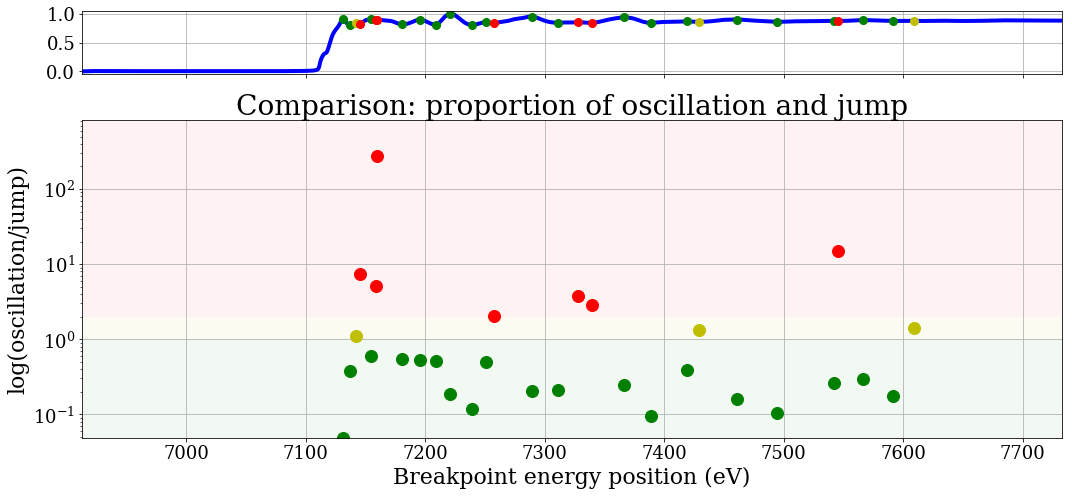

In [49]:
name = names[0]
number_points = decompositions[name]['number_of_splittings_after']
stat_jumps_and_oscillation(name,parameters,decompositions,number_points, saveas='Proportion_oscillation'+name,plotting=True)

The third statistics will come from distance

In [50]:
def stat_dist_zero(name,parameters,decompositions,number_points,saveas='Statistics',plotting=True):

    '''
    Comparison between different methods to compute distance threshold
    ----------------
    Input:
    - parameters: dictionary with materials' properties
    - names: names of materials studied
    - decomposition: dictionary with information about peaks and their locations
    - plot_type: 'normalized' or 'raw'
    - figure_extension: 'png' or 'eps'
    - loc: number from {1,2, 3, 4,} where legend will be placed
    - title: title in the plot
    ----------------
    '''    
    ##########################
    if plotting:
        plt.figure(figsize=(20,10))
        plt.rc('font', family='serif')
        plt.rc('xtick', labelsize=18)
        plt.rc('ytick', labelsize=18)
    
    ##############################################################
    # UNPACKING...
    # ... parameters
    print("Statistics for distance, for ", name,"\n")
    parameters_now = parameters[name]
    stop = parameters_now['stop']
    E_now = parameters_now['energy']
    xanes_now = parameters_now['xanes']

    # ...decomposition properties
    decomposition_now = decompositions[name]
    jumps = decomposition_now['jumps']
    peak_loc = decomposition_now['peak_location']
    peak_height = decomposition_now['peak_heights']
    omega_oscillation = decomposition_now['oscillation']
    vector_dist_peak = decomposition_now['distance_between_peaks']
    height_threshold = decomposition_now['height_threshold_evolution']
    number_splittings_before = decomposition_now['number_of_splittings_before']
    number_points = min(decomposition_now['number_of_splittings_after'], number_points)
    
    '''
    We shall plot the xanes measurement and the peak variations'''
    #This value has to vary because the algorithm is assymetric
    if number_splittings_before==0:
        start_from =0 
    else:
        start_from = number_splittings_before-1
       
    vector_height_threshold_used= [height_threshold[str(j)] for j in range(number_points)]
    vector_dist_peak_after=vector_dist_peak[start_from:]
    vec_peak_loc = [peak_loc[str(j)] for j in range(number_points)]
    jumps_after = jumps[start_from:]
    
    # Small plot of xanes measurement on top
    where_to_stop_plot = int(.8*peak_loc[str(number_points-1)]+.2*stop)
    
    f,(ax1,ax2)= plt.subplots(2,1,sharex=True, gridspec_kw={'height_ratios': [1, 5]},figsize=(15,7))
    ax1.set_yticks([0, .5, 1])
    ax1.plot(E_now[0,:where_to_stop_plot].T,xanes_now[0,:where_to_stop_plot].T,color='blue',lw=4) # Plot xanes spectrum 
    ax1.grid(True)
    
    
    for i in range(start_from,number_points-1):
         ### Now we plot the h_threshold
        _,_,h_threshold =\
        oscillation_function(\
                             np.array(E_now[0,peak_loc[str(i)]:stop],ndmin=2),\
                             np.array(xanes_now[0,peak_loc[str(i)]:stop],ndmin=2),\
                             full_computation=False)
    ############################
        ### How much of the jump is noise?
        proportion_noise_jump=h_threshold/jumps_after[i]
        colors = ['g','y','r']
        # Plot a marker
        ax1.plot(E_now[0,peak_loc[str(i)]],xanes_now[0,peak_loc[str(i)]],\
                 color=colors[min(int(np.floor(proportion_noise_jump)),2)], marker='H',label=None,  markersize=16,alpha=.8,lw=4)   
    
    ## And now we are ready for the rest. We shall run the different statistics accross the model,
    #and see how it goes
    
    first_dist = vector_dist_peak[start_from]
    dist_learn_to_trust, dist_min_max, dist_regression = [first_dist],[first_dist],[first_dist]
    
    for i in range(1,number_points):
        
        ### We first compute the h_threshold
        _,_,h_threshold =\
        oscillation_function(\
                             np.array(E_now[0,peak_loc[str(i)]:stop],ndmin=2),\
                             np.array(xanes_now[0,peak_loc[str(i)]:stop],ndmin=2),\
                             full_computation=False)
        ############################
        ## Now we plot using min_max
        hyperparameters['decay_rate_type']= 'min_max'
        
        _ ,dist_m_m ,_ , _ =decay_rate(parameters,hyperparameters,name,\
            omega_oscillation, jumps,vector_height_threshold_used,\
            vector_peak_loc, vector_dist_peak_after[:i],i)
        
        dist_min_max.append(dist_m_m)
        
        ############################
        ## Now we plot using learn_to_trust
        hyperparameters['decay_rate_type']= 'learn_to_trust'
        
        _ , dist_l_t,_ , _ =decay_rate(parameters,hyperparameters,name,\
            omega_oscillation, jumps,vector_height_threshold_used,\
            vector_peak_loc, vector_dist_peak_after[:i],i)
        dist_learn_to_trust.append(dist_l_t)
        
        ############################
        ## Now we plot using regression
        hyperparameters['decay_rate_type']= 'regression'
        
        _ , dist_reg ,_ , _  =decay_rate(parameters,hyperparameters,name,\
            omega_oscillation, jumps,vector_height_threshold_used,\
            vector_peak_loc, vector_dist_peak_after[:i],i)
        
        dist_regression.append(dist_reg)
        
    #### NOW WE PLOT THEM ALL
    # True distance
    ax2.bar(E_now[0,vec_peak_loc][1:],vector_dist_peak_after[:number_points][1:],width=4,color='gray')
    
    gray_patch = mpatches.Patch(color='gray', label='True distance')
 
    #min_max_plot
    ax2.plot(E_now[0,vec_peak_loc][1:],dist_min_max[1:],\
                 color='blue',label=None,marker='h',markersize=16,alpha=.4)
    blue_patch = mpatches.Patch(color='blue', label='Min_max')        
    
    #learn_to_trust plot
    ax2.plot(E_now[0,vec_peak_loc][1:],dist_learn_to_trust[1:],\
             color='orange',label=None,marker='o',markersize=16,alpha=.6)
    orange_patch = mpatches.Patch(color='orange',alpha=.4, label='Learn_to_trust')
    
    #'estimated jump using least squares'
    ## mew stands for "marker edge width"
    ax2.plot(E_now[0,vec_peak_loc][1:],dist_regression[1:],\
             color='red',label=None,marker='x',mew=4,markersize=16,alpha=.4)
    red_patch = mpatches.Patch(color='red', label='Regression')
    
    ax2.grid(True)
    plt.yscale('log')
   #########################################
    ax2.legend(handles=[gray_patch,blue_patch,orange_patch,red_patch],prop={'size':22})
    plt.title("Study of decay rates for distance: "+name,size=28)
    plt.xlabel('Breakpoint energy position (eV)',size=22)
    plt.ylabel('Log of estimated distance',size=22)
    
    #ax1.set_rasterized(True)
    figure_save(saveas,figure_extension='png')
    plt.show()

Statistics for distance, for  Fe foil 

Saving figure as  Statistics_distance


<Figure size 1440x720 with 0 Axes>

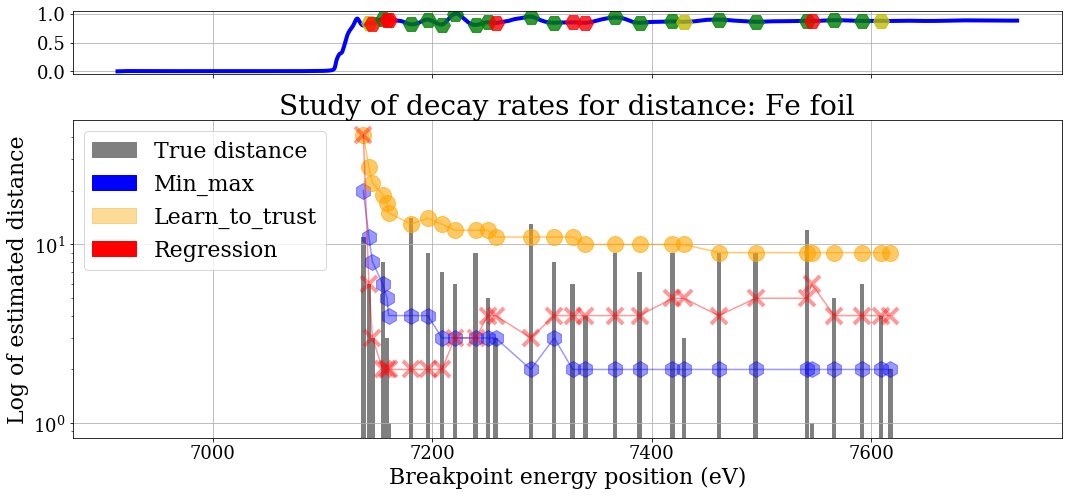

In [51]:
name = names[0]
decomposition_now= decompositions[name]

number_points = decomposition_now['number_of_splittings_after']
stat_dist_zero(name,parameters,decompositions,number_points,saveas='Statistics_distance',plotting=True)

Fianlly, we study the threshold for oscillation:

In [52]:
def stat_thresholds(name,parameters,decompositions,number_points,saveas='Statistics',plotting=True):

    '''
    Comparison between different methods to compute height_threshold
     ----------------
    Input:
    - parameters: dictionary with materials' properties
    - names: names of materials studied
    - decomposition: dictionary with information about peaks and their locations
    - number_points: number of peaks that we want to do statistics on
    - saveas:  name  of saved figure
    - plotting: plot figure (True) or not  (False)
   ----------------
    '''
    ##########################
    if plotting:
        plt.figure(figsize=(20,10))
        plt.rc('font', family='serif')
        plt.rc('xtick', labelsize=18)
        plt.rc('ytick', labelsize=18)
    
    ##############################################################
    # UNPACKING...
    # ... parameters
    print("Statistics for distance, for ", name,"\n")
    parameters_now = parameters[name]
    stop = parameters_now['stop']
    E_now = parameters_now['energy']
    xanes_now = parameters_now['xanes']

    # ...decomposition properties
    decomposition_now = decompositions[name]
    jumps = decomposition_now['jumps']
    peak_loc = decomposition_now['peak_location']
    peak_height = decomposition_now['peak_heights']
    omega_oscillation = decomposition_now['oscillation']
    vector_dist_peak = decomposition_now['distance_between_peaks']
    height_threshold = decomposition_now['height_threshold_evolution']
    number_splittings_before = decomposition_now['number_of_splittings_before']
    number_points = min(decomposition_now['number_of_splittings_after'], number_points)
    
    '''
    We shall plot the xanes measurement and the peak variations'''
    #This value has to vary because the algorithm is assymetric
    if number_splittings_before==0:
        start_from =0 
    else:
        start_from = number_splittings_before-1
    
    vector_height_threshold_used= [height_threshold[str(j)] for j in range(number_points)]
    vector_dist_peak_after=vector_dist_peak[start_from:]
    vec_peak_loc = [peak_loc[str(j)] for j in range(number_points)]
    jumps_after = jumps[start_from:]
    
    # Small plot of xanes measurement on top
    where_to_stop_plot = int(.8*peak_loc[str(number_points-1)]+.2*stop)
    
    f,(ax1,ax2)= plt.subplots(2,1,sharex=True, gridspec_kw={'height_ratios': [1, 5]},figsize=(15,7))
    ax1.set_yticks([0, .5, 1])
    ax1.plot(E_now[0,:where_to_stop_plot].T,xanes_now[0,:where_to_stop_plot].T,color='blue',lw=4) # Plot xanes spectrum 
    ax1.grid(True)
    
    ## And now we are ready for the rest. We shall run the different statistics accross the model,
    #and see how it goes
    
    first_threshold = vector_height_threshold_used[start_from]
    h_thresh_learn_to_trust, h_thresh_min_max, h_thresh_regression =[first_threshold],[first_threshold],[first_threshold]
    
    
    _,_,h_thresh_t =\
        oscillation_function(\
                             np.array(E_now[0,peak_loc[str(0)]:stop],ndmin=2),\
                             np.array(xanes_now[0,peak_loc[str(0)]:stop],ndmin=2),\
                             full_computation=False)
    
    h_thresh_true = [h_thresh_t]
    
    for i in range(1,number_points-1):
        
        ############################
        ### Now we plot the h_threshold
        _,_,h_thresh_t =\
        oscillation_function(\
                             np.array(E_now[0,peak_loc[str(i)]:stop],ndmin=2),\
                             np.array(xanes_now[0,peak_loc[str(i)]:stop],ndmin=2),\
                             full_computation=False)
        
        h_thresh_true.append(h_thresh_t)
        ### How much of the jump is noise?
        proportion_noise_jump=h_thresh_t/jumps_after[i]
        colors = ['g','y','r']
        # Plot a marker
        ax1.plot(E_now[0,peak_loc[str(i)]],xanes_now[0,peak_loc[str(i)]],\
                 color=colors[min(int(np.floor(proportion_noise_jump)),2)], marker='H',label=None,  markersize=16,alpha=.8,lw=4)
        
        ############################
        ## And now we are ready for the rest. We shall run the different statistics accross the model,
        #and see how it goes
        
        ## Now we plot using min_max
        
        hyperparameters['decay_rate_type']= 'min_max'
        
        _ ,_ ,h_thres_m_m, _ =decay_rate(parameters,hyperparameters,name,\
            omega_oscillation, jumps,vector_height_threshold_used,\
            vector_peak_loc, vector_dist_peak_after[:i],i)
        h_thresh_min_max.append(h_thres_m_m)
        
        ############################
        ## Now we plot using learn_to_trust
        hyperparameters['decay_rate_type']= 'learn_to_trust'
        
        _ ,_, h_thres_l_t, _ =decay_rate(parameters,hyperparameters,name,\
            omega_oscillation, jumps,vector_height_threshold_used,\
            vector_peak_loc, vector_dist_peak_after[:i],i)
        
        h_thresh_learn_to_trust.append(h_thres_l_t)
        
        ############################
        ## Now we plot using regression
        hyperparameters['decay_rate_type']= 'regression'
        
        _ ,_ ,h_thres_reg , _  =decay_rate(parameters,hyperparameters,name,\
            omega_oscillation, jumps,vector_height_threshold_used,\
            vector_peak_loc, vector_dist_peak_after[:i],i)
        
        h_thresh_regression.append(h_thres_reg)
        
    #### NOW WE PLOT THEM ALL
    # True threshold
    ax2.bar(E_now[0,vec_peak_loc][1:],h_thresh_true,width=4,color='gray')
    gray_patch = mpatches.Patch(color='gray', label='True distance')
    
    #learn_to_trust plot
    ax2.plot(E_now[0,vec_peak_loc][1:],h_thresh_learn_to_trust,\
             color='orange',label=None,marker='H',markersize=16,alpha=.6)
    orange_patch = mpatches.Patch(color='orange',alpha=.4, label='Learn_to_trust')
    
    #min_max_plot
    ax2.plot(E_now[0,vec_peak_loc][1:],h_thresh_min_max,\
                 color='blue',label=None,marker='x',mew=4,markersize=16,alpha=.4)
    blue_patch = mpatches.Patch(color='blue', label='Min_max')        
    
    #'estimated jump using least squares. NOTE: mew stands for "marker edge width"
    ax2.plot(E_now[0,vec_peak_loc][1:],h_thresh_regression,\
             color='red',label=None,marker='o',mew=4,markersize=16,alpha=.4)
    red_patch = mpatches.Patch(color='red', label='Regression')
    
    ax2.grid(True)
    plt.yscale('log')
   #########################################
    
    ax2.legend(handles=[gray_patch,blue_patch,orange_patch,red_patch],prop={'size':22})
    plt.title("Evolution of height threshold and estimates",size=28)
    #ax1.set_rasterized(True)
    plt.xlabel('Breakpoint energy position (eV)',size=22)
    plt.ylabel('Log of estimated height threshold',size=22)
    
    figure_save(saveas,figure_extension='png')
    plt.show()

Statistics for distance, for  Fe foil 

Saving figure as  Statistics_height_threshold


<Figure size 1440x720 with 0 Axes>

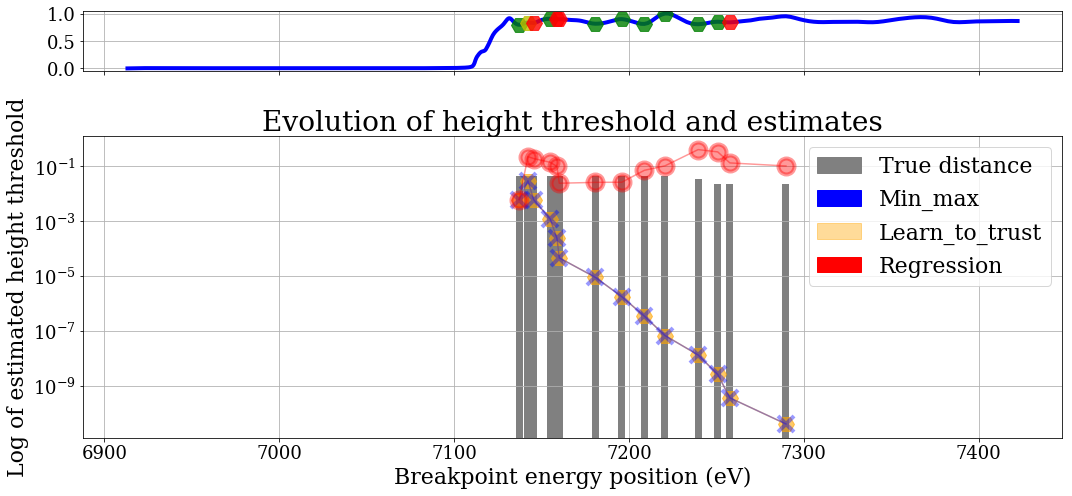

In [53]:
name = names[0]
'''
print(decompositions[name]['distance_between_peaks'])
print(decompositions[name]['jumps'])
print(decompositions[name]['peak_location'])                           
   '''                        
number_points = 15
stat_thresholds(name,parameters,decompositions,number_points,saveas='Statistics_height_threshold',plotting=True)

The last statistics plot will be the following: 
    
    1. We plot the jumps, and the threshold together
    2. We shall also plot how much decay we are actually predicting using different methods (min_max, regression)
    3. We also plot how much we are actually using

# Normalizing number of points

It is the case that the number of breakpoints in each XANES measurement varies. Hence, we need to adjust for that. The first code is as follows: it receives a bunch of intervals and points inside of it. Then it starts breaking it into smaller intervals by breaking the largest interval in two pieces.

So, you have an interval $\mathscr{I}$, with points $e_0 < e_1 <.... <e_M$. Now, given a number N >M we introduce new elements to this sequence until it has N intervals (that is, N+1 points).




In [54]:
def clean_up_breakpoints(parameters,decompositions,names):
    '''
    This function receives towo dictionaries and one list(names), whose  elements are the keys to the
    previously mentioned dictionaries. 
    
    The function takes the breakpoints (the peaks) in each decomposition, at this point given as a dictionary,
    and creats a vector from it.
    ----------------
    Input:
    - parameters: dictionary with materials' properties
    - decomposition: dictionary with information about peaks and their locations
    - names: names of materials studied
    
    ----------------
    
    '''
    breakpoints ={}
    for name in names:
        
        ##############################################################
        # UNPACKING...
        # ... parameters
        xanes_now = parameters[name]['xanes']
        E_now =parameters[name]['energy']
        xanes_now_unpad = parameters[name]['raw_xanes']
    
        # ...decomposition properties
        decomposition_now = decompositions[name]
        peak_loc = decomposition_now['peak_location']
        number_splittings_before = decomposition_now['number_of_splittings_before']
        number_splittings_after = decomposition_now['number_of_splittings_after']
        dist_left = decomposition_now['distance_between_peaks'][:number_splittings_before]
        dist_right = decomposition_now['distance_between_peaks'][number_splittings_before:]
        breakpoints[name] = np.array([peak_loc[str(j)] for j in range(-number_splittings_before,number_splittings_after)],np.int32)
  
    return breakpoints

For example, the output will look more or less like this

In [55]:
breakpoints = clean_up_breakpoints(parameters,decompositions,names)

breakpoints

{'Fe foil': array([  0,   1,  13,  95, 106, 112, 115, 123, 126, 127, 141, 150, 157,
        163, 172, 177, 180, 193, 201, 207, 211, 220, 227, 236, 239, 248,
        257, 269, 270, 275, 281, 285, 287], dtype=int32),
 'Fe2O3': array([ 62,  98, 127, 142, 159, 166, 169, 172, 178, 191, 205, 213, 224,
        225, 228, 236, 245, 254, 256, 257, 260, 262, 265, 271, 274, 278,
        279, 281, 284, 287, 288], dtype=int32),
 'Fe3O4': array([  0,  10,  58,  62,  92, 126, 143, 157, 166, 175, 187, 200, 208,
        217, 222, 225, 231, 241, 247, 251, 254, 256, 266, 273, 286, 295,
        306, 313, 314, 315], dtype=int32),
 'FeO': array([ 38,  91, 109, 114, 124, 138, 150, 164, 172, 178, 180, 186, 196,
        207, 222, 231, 239, 241, 243, 252, 260, 270, 271, 276, 282, 283,
        285, 286, 287, 292, 293], dtype=int32)}

In [56]:
def split_interval(breakpts,Normalization_number,kind='middle_domain'): #range_xanes,
    
    '''
    Given breakpoints brekpts (integers), finds a superset of breakpoints that are in between
    
    min(breakpts) and max(breakpts)
    
    with Normalization_number of points. The criteria for the construction of this superset is 
    finds the largest subinterval in the domain and split it in two equally sized intervals
    ----------------
    
    Input:
    - breakpts: numpy array with breakpoints
    - Normalization_number: number of breakpoints in the final set that containts the breakpoints brkpts
                            initially given 
    - kind: type of interpolation. In principle one can use 
            - middle_domain: finds the largest subinterval in the domain and split it in two
            - middle_image: finds the largest subinterval in the domain, say, interval J)
                            and split it into the part that the range of its image through XANES, that is, 
                            XANES(J), varies up to half of its range  
    ----------------
    '''
    
    M = len(breakpts)
    interval_size = np.array([breakpts[i] - breakpts[i-1] for i in range(1,M)],dtype=np.int16)

    
    if kind == 'middle_domain':
        
        while M<Normalization_number:
            
            Max_int = np.max(interval_size)
            a = np.squeeze(np.min(np.where(interval_size == Max_int)))
            
            breakpts= np.concatenate((breakpts[:a+1],np.floor(np.array([breakpts[a]+Max_int/2])),breakpts[a+1:]))
            M += 1
            interval_size = np.concatenate((interval_size[:a],np.array([np.floor(Max_int/2),np.ceil(Max_int/2)]),\
                                        interval_size[a+1:]))
        return  breakpts
    
    if kind =='middle_image':
        while M<Normalization_number:
            Max_int = np.max(interval_size)
            # Find largest interval
            a = np.squeeze(np.min(np.where(interval_size == Max_int)))
            
            # Find middle point in the range
            Mid = (range_xanes[0,breakpts[a]]+range_xanes[0,breakpts[a+1]])/2
            
            #Now find first entry that satisfies  range[i]<M <=range[i+1]
            v = range_xanes[0,breakpts[a]:breakpts[a+1]]
            mid_pt = np.max([np.min(np.where(v>=Mid)),np.min(np.where(v<Mid))])
            breakpts= \
            np.concatenate((breakpts[:a+1],np.array([breakpts[a]+mid_pt-1],dtype=np.int16),breakpts[a+1:]))
            interval_size = \
            np.concatenate((interval_size[:a],np.array([breakpts[a+1] -breakpts[a],breakpts[a+2]-breakpts[a+1]],dtype=np.int16),\
                                        interval_size[a+1:]))
            M += 1
            
        return  breakpts    

Now we give a sequence of vectors, we find a normalization number and split all of them


In [57]:
def Calculate_Normalization_number(decompositions,names,how_many_before,how_many_after):
    '''
    In order to feed some Machine Learning models, the input should have a fixed size. This function gives the
    minimum size that the input should have. 
    
    It goes like this: given a family decompositions indexed by names, 
    in each of them selects 
        min(how_many_before breakpoints.maximal_number of splittints before) 
        and
        min(how_many_after breakpoints.maximal_number of splittints after)
    
    breakpoints. Then,
    return the largest cardinality (number of points) among them. 
    
    This number is a normalization index M: given all the supersets that contain each of these breakpoint indices,
    the ones with same cardinality should have at least M points.
    
     ----------------
    Input:
    - names: names of materials studied
    - decomposition: dictionary with information about peaks and their locations
    - how_many_before: number of peaks that should be interpolated before 0th peak
    - how_many_after: number of peaks that should be interpolated after 0th peak
    
    ---------------
    Output:
    - M:smallest cardinality among all supersets of indices
    '''
    
    M=0
    for name in names:
        
        ##############################################################
        # UNPACKING...
        # ... decomposition
        decomposition_now = decompositions[name]
        number_splittings_before = min(how_many_before,decomposition_now['number_of_splittings_before'])
        number_splittings_after = min(how_many_after,decomposition_now['number_of_splittings_after'])
    
        if M <number_splittings_after +number_splittings_before:
            M = number_splittings_after +number_splittings_before
    return M

def remove_duplicates(aux_breakpt):
    '''
    Receives vector with breakpoints and clean it, only leaving non-duplicate elements.
    ----------------
    Input:
    -aux_breakpt: increasing vector with breakpoints, no duplicates
    ----------------
    Output:
    -breakpoint: a increasing vector with breakpoint indices
    '''
   
   
    L = len(aux_breakpt)
    breakpoint = np.array([aux_breakpt[0]])
    
    for i in range(1, L):
        if breakpoint[-1]< aux_breakpt[i]: 
            breakpoint = np.append(breakpoint,aux_breakpt[i])
    return breakpoint

def normalize_points(
    parameters,names, decompositions,k=3,
    kind='middle_domain',printing=True,how_many_before=20,how_many_after =20 
):
    '''
    Receives a family of decompositions each with breakpoints B_name indexed by name in {names}, does the following:
        1.find the minimum size of the input space (Normalization_number);
        2. enlarge this number by a factor k (k>=1);
        3. append new breakpoints for each of the initial sets B_name in order to obtain new sets of breakpoints
            tilde_B_name with size k*Normalization_number (=: Norm_number)
            
    ----------------
    Input:
    - parameters: dictionary with materials' properties
    - names: names of materials studied
    - decomposition: dictionary with information about peaks and their locations
    - k=3: parameter that multiplies normalization number. 
    - kind: type of interpolation. In principle one can use 
            - middle_domain: finds the largest subinterval in the domain and split it in two
            - middle_image: finds the largest subinterval in the domain, say, interval J)
                            and split it into the part that the range of its image through XANES, that is, 
                            XANES(J), varies up to half of its range
    - printing: print computations (True) or not  (False)
    
    - how_many_before: upper bound on number of points to be sought on the leftt of 0th breakpoint 
                        (automatically set as 20)
    - how_many_after: upper bound on number of points to be sought on the right of 0th breakpoint 
                        (automatically set as 20)
    ----------------
    Output:
    -breakpoint: a increasing vector with breakpoint indices with sizes k*Normalization_number
    -Norm_number: k*Normalization number
    '''
   
    
    Norm_number = np.ceil(k*Calculate_Normalization_number(decompositions,names,how_many_before,how_many_after))
    
    if printing: print("Number of breakpoints is:", Norm_number)
    
    breakpts=clean_up_breakpoints(parameters,decompositions,names)
    # Unpacking ...
    for name in names:
        ##############################################################
        # UNPACKING...
        # ... parameters
        decomposition_now = decompositions[name]
        
        stop = parameters[name]['stop']
        E_now = parameters[name]['energy']
        xanes_now = parameters[name]['xanes']

        # ...decomposition properties
        decomposition_now = decompositions[name]
        peak_loc = decomposition_now['peak_location']
        number_splittings_before = min(how_many_before,decomposition_now['number_of_splittings_before'])
        number_splittings_after = min(how_many_after,decomposition_now['number_of_splittings_after'])

        aux_breakpt= np.array([np.int(peak_loc[str(i)]) for i in range(-number_splittings_before,number_splittings_after)],dtype=np.int16)    
        breakpts[name] = remove_duplicates(aux_breakpt)
        breakpts[name] = split_interval(breakpts[name],Norm_number,kind=kind)#xanes_now, 
        breakpts[name] = np.array(breakpts[name],dtype=np.int16)
    return breakpts, Norm_number

In [58]:
breakpts,_ = normalize_points(parameters,names,decompositions,k=1.1,kind='middle_domain')

Number of breakpoints is: 27.0


You can definitely see that the points get better distributed in this fashion. Just for curiosity, I'll add the functionality that gives the $\ell^{\infty}$ norm of these approximations.

Let's interpolate all these functions

In [59]:
import scipy as sp
from scipy.interpolate import interp1d, splrep, splev


def interpolate_same_size(parameters,breakpts,names,kind,filename,bdry='unpadded',bdry_add=2,printing=True):
    '''
    ----------------
    Input:
    - parameters: dictionary with materials' properties
    - names: names of materials studied
    - breakpts: ordered breakpoints
    - kind: type of interpolation. Types are
            -"equally_spaced_splines": iterpolate using Cubic Splines in equally spaced meshgrid
            -"equally_spaced_polygonal": iterpolate using Polygonals in equally spaced meshgrid
            - "cubicspline" : iterpolate using Cubic Splines using interpolation points breakpts
            -"linear": iterpolate using Polygonals using interpolation points breakpts
            - "both": iterpolate using Cubic Splines and Polygonals using interpolation points breakpts
            
    - printing: print computations (True) or not  (False)
    - filename: name of saved figure 
    - bdry='unpadded': if doing Cubic Splines, pad it with bdry_add points. 
                        In case of no padding, takes value 'unpadded'
    - bdry_add: standard value 2, sets the number of extra points to add to the right and left of XANES measurement 
                in order to avoid boundary issues in XANES

    ---------------
    '''
    
    approximations={}
    l_infty_errors={}
    l_1_errors={}
    
    for name in names:
        if printing: 
            plt.figure(figsize=(15,10))
            plt.rc('font', family='serif')
            plt.rc('xtick', labelsize=18)
            plt.rc('ytick', labelsize=18)

        ##############################################################
        # UNPACKING...
        # ... parameters
        xanes_now = parameters[name]['xanes']
        E_now =parameters[name]['energy']
        xanes_now_unpad = parameters[name]['raw_xanes']
        # ... decomposition
        decomposition_now = decompositions[name]
        peak_loc = decomposition_now['peak_location']
        number_splittings_before = decomposition_now['number_of_splittings_before']
        number_splittings_after = decomposition_now['number_of_splittings_after']
        start = max(peak_loc[str(-number_splittings_before)],breakpts[name][0])
        stop = min(peak_loc[str(number_splittings_after-1)],breakpts[name][-1])+1
        
        full_dimension = stop-start-1

        ####################################
        if kind =="equally_spaced_splines":

            N = len(breakpts[name])
            
            ticks = np.linspace(start,stop,N,endpoint = True, dtype=np.int16)
            ticks= ticks.reshape(1,-1)

            if bdry=='unpadded':
                x= E_now[0,ticks[0,:]]
                y = xanes_now[0,ticks[0,:]]
                cs = interp1d(x, y,kind='cubic')
            elif bdry=='padded':
                distance_left = E_now[0,ticks[0,1]]-E_now[0,ticks[0,0]]
                distance_right = E_now[0,ticks[0,-1]]-E_now[0,ticks[0,-2]]

                x = np.pad(np.array(E_now[0,ticks[0,:]]), (bdry_add, bdry_add), 'linear_ramp', end_values=(E_now[0,ticks[0,0]] - bdry_add*distance_left, E_now[0,ticks[0,-1]] + bdry_add*distance_right))
                x = np.squeeze(x)

                y = np.pad(np.array(xanes_now[0,ticks[0,:]]), (bdry_add, bdry_add), 'edge')
                y=np.squeeze(y)

                cs = interp1d(x, y,kind='cubic')

            l_infty = np.round(max(np.abs(xanes_now[0,start:stop]-cs(E_now[0,start:stop]))),3)
            approximations[name]= cs
            l_infty_errors[name] =l_infty
            
            l_1 = np.round(np.sum(np.abs(xanes_now[0,start:stop]-cs(E_now[0,start:stop]))),3)  
            l_1_errors[name] =l_1

            if printing:
                plt.plot(
                    E_now[0,start:stop].T,xanes_now[0,start:stop].T,'--',\
                    label =name,color='red',lw=4
                )
                plt.plot(
                    E_now[0,start:stop].T,cs(E_now[0,start:stop]).T,linestyle=(0,(5,1)), \
                    label="CS "+" $\Vert\cdot \Vert_{\infty}}$:"+str(l_infty),color='blue',lw=4
                )
                plt.ylabel('Absorption $\mu(E)$',size=28)
                plt.xlabel("Energy (eV)", size=28)
                plt.title('Eq. spaced cub. splines interpolation of XANES spectrum, N: '+str(N)+', full dim. : ' +str(full_dimension), size=22)
                plt.legend(loc=4,prop={'size':22})
                plt.grid(True)
                figure_save("XANES_spline"+filename+kind)
                plt.show()

        ####################################
        if kind =="equally_spaced_polygonal":
            
            N = len(breakpts[name])
            ticks = np.linspace(start,stop,N,endpoint = True, dtype=np.int16)
            ticks= ticks.reshape(1,-1)
            
            if bdry=='unpadded':
                x= E_now[0,ticks[0,:]]
                y = xanes_now[0,ticks[0,:]]
                cs = interp1d(x, y,kind='linear')
            elif bdry=='padded':
                distance_left = E_now[0,ticks[0,1]]-E_now[0,ticks[0,0]]
                distance_right = E_now[0,ticks[0,-1]]-E_now[0,ticks[0,-2]]
                
                x = np.pad(np.array(E_now[0,ticks[0,:]]), (bdry_add, bdry_add), 'linear_ramp', end_values=(E_now[0,ticks[0,0]] - bdry_add*distance_left, E_now[0,ticks[0,-1]] + bdry_add*distance_right))
                x = np.squeeze(x)
                
                y = np.pad(np.array(xanes_now[0,ticks[0,:]]), (bdry_add, bdry_add), 'edge')
                y=np.squeeze(y)
                
                ## Two versions: version 1            
                cs = interp1d(x, y,kind='linear')
                
            l_infty = np.round(max(np.abs(xanes_now[0,start:stop]-cs(E_now[0,start:stop]))),3)
            approximations[name]= cs
            l_infty_errors[name] =l_infty

            l_1 = np.round(np.sum(np.abs(xanes_now[0,start:stop]-cs(E_now[0,start:stop]))),3)  
            l_1_errors[name] =l_1

            
            if printing:
                plt.plot(
                    E_now[0,start:stop].T,xanes_now[0,start:stop].T,'--',label =name,color='red',lw=4
                )
                
                ## Two versions: version 1            
                plt.plot(
                    E_now[0,start:stop].T,cs(E_now[0,start:stop]).T,linestyle=(0,(5,1)),\
                    label="CS "+" $\Vert\cdot \Vert_{\infty}}$:"+str(l_infty),color='blue',lw=4
                )
                plt.ylabel('Absorption $\mu(E)$',size=28)
                plt.title('Eq. spaced polygonal interpolation of XANES spectrum, N: '+str(N)+', full dim. : ' +str(full_dimension), size=22)
                plt.xlabel("Energy (eV)", size=28)
                plt.legend(loc=4,prop={'size':22})
                plt.grid(True)
                figure_save("XANES_spline"+filename+kind)
                plt.show()

        ####################################
        if kind =="cubicspline" or kind=='both':
            
            ticks = np.array(breakpts[name],dtype=np.int16)
            ticks= ticks.reshape(1,-1)
            N = len(breakpts[name])
            if bdry=='unpadded':
                x= E_now[0,ticks[0,:]]
                y = xanes_now[0,ticks[0,:]]
                cs = interp1d(x, y,kind='cubic')
                
                l_infty = np.round(max(np.abs(xanes_now[0,start:stop]-cs(E_now[0,start:stop]))),3)
                l_1 = np.round(np.sum(np.abs(xanes_now[0,start:stop]-cs(E_now[0,start:stop]))),3)  
            elif bdry=='padded':
                distance_left = E_now[0,ticks[0,1]]-E_now[0,ticks[0,0]]
                distance_right = E_now[0,ticks[0,-1]]-E_now[0,ticks[0,-2]]
                
                x = np.pad(np.array(E_now[0,ticks[0,:]]), (bdry_add, bdry_add), 'linear_ramp', end_values=(E_now[0,ticks[0,0]] - bdry_add*distance_left, E_now[0,ticks[0,-1]] + bdry_add*distance_right))
                x = np.squeeze(x)
                y = np.pad(np.array(xanes_now[0,ticks[0,:]]), (bdry_add, bdry_add), 'edge')
                y=np.squeeze(y)
                
                cs = splrep(x, y,k=3)
                y_2 = splev(E_now[0,start:stop], cs)           
                l_infty = np.round(max(np.abs(xanes_now[0,start:stop]-y_2)),3)
                l_1 = np.round(np.sum(np.abs(xanes_now[0,start:stop]-y_2)),3)  
                
            approximations[name]= cs
            l_infty_errors[name] =l_infty
            
            l_1_errors[name] =l_1

            
            if printing:
                plt.plot(
                    E_now[0,start:stop].T,xanes_now[0,start:stop].T,'--',label =name,color='red',lw=4
                )
                if bdry=='unpadded':
                    plt.plot(
                        E_now[0,start:stop].T,cs(E_now[0,start:stop]).T,linestyle=(0,(5,1)),\
                        label="CS "+" $\Vert\cdot \Vert_{\infty}}$:"+str(l_infty),color='blue',lw=4
                    )
                elif bdry=='padded':
                    plt.plot(
                        E_now[0,start:stop].T,y_2.T,linestyle=(0,(5,1)),\
                        label="CS "+" $\Vert\cdot \Vert_{\infty}}$:"+str(l_infty),color='blue',lw=4
                    )

                plt.ylabel('Absorption $\mu(E)$',size=28)
                plt.xlabel("Energy (eV)", size=28)
                plt.legend(loc=4,prop={'size':22})
                plt.grid(True)
               
            if kind != 'both':
                if printing:
                    plt.title('CS interpolation of XANES spectrum, N: '+str(N)+', full dim. : ' +str(full_dimension), size=22)
                    figure_save("XANES_spline"+filename+kind)
                    plt.show()

        ####################################
        if kind =="linear" or kind=='both': #    hence it is polynomial type
            N = len(breakpts[name])
            ticks = np.array(breakpts[name],dtype=np.int16)
            ticks= ticks.reshape(1,-1)
            x= E_now[0,ticks[0,:]]
            y = xanes_now[0,ticks[0,:]]
            cs = interp1d(x, y,kind='linear')
            l_infty = np.round(max(np.abs(xanes_now[0,start:stop]-cs(E_now[0,start:stop]))),3)
            if printing:
                plt.ylabel('Absorption $\mu(E)$',size=28)
                plt.xlabel("Energy (eV)", size=28)
                if kind !='both':
                    plt.plot(
                        E_now[0,start:stop].T,xanes_now[0,start:stop].T,'--',label =name,color='red',lw=4
                    )
                plt.plot(
                    E_now[0,start:stop].T,cs(E_now[0,start:stop]).T,linestyle=(0,(5,1)),
                    label ="Polygonal $\Vert\cdot \Vert_{\infty}}$:"+str(l_infty),color='blue',lw=4
                )
                plt.legend(loc=4,prop={'size':22})
                plt.grid(True)
            approximations[name]= cs,
            l_infty_errors[name] =l_infty
             
            l_1 = np.round(np.sum(np.abs(xanes_now[0,start:stop]-cs(E_now[0,start:stop]))),3)  
            l_1_errors[name] =l_1
    
            if kind !='both': 
                if printing:
                    plt.title('Polygonal interpolation of XANES spectrum , N: '+str(N)+', full dim. : ' +str(full_dimension), size=28)
                    figure_save("XANES_polygonal"+filename+kind)
            else:    
                if printing:
                    plt.title('Polygonal and splines interpolation of XANES spectrum , N: '+str(N)+', full dim. : ' +str(full_dimension), size=28)
                    figure_save("XANES_polygonal_and_splines_same_size"+filename+kind)
        if printing:
            plt.show()

    return approximations,l_infty_errors, l_1_errors

Number of breakpoints is: 27.0
Saving figure as  XANES_splineallxanes_unnormalizedcubicspline


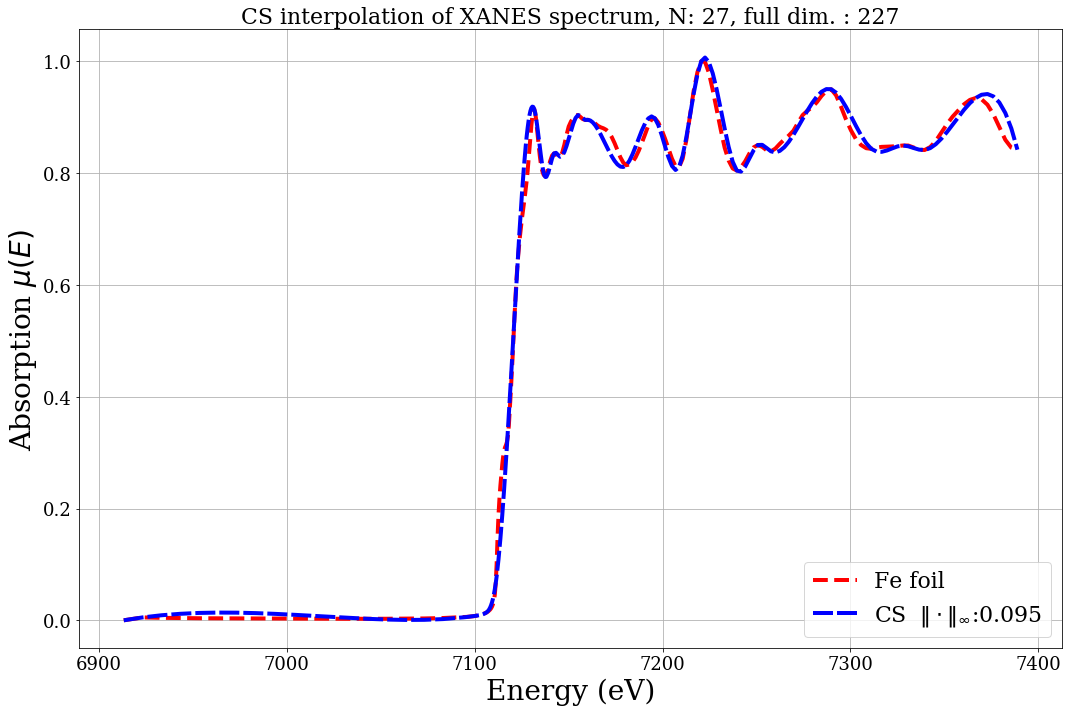

Saving figure as  XANES_splineallxanes_unnormalizedcubicspline


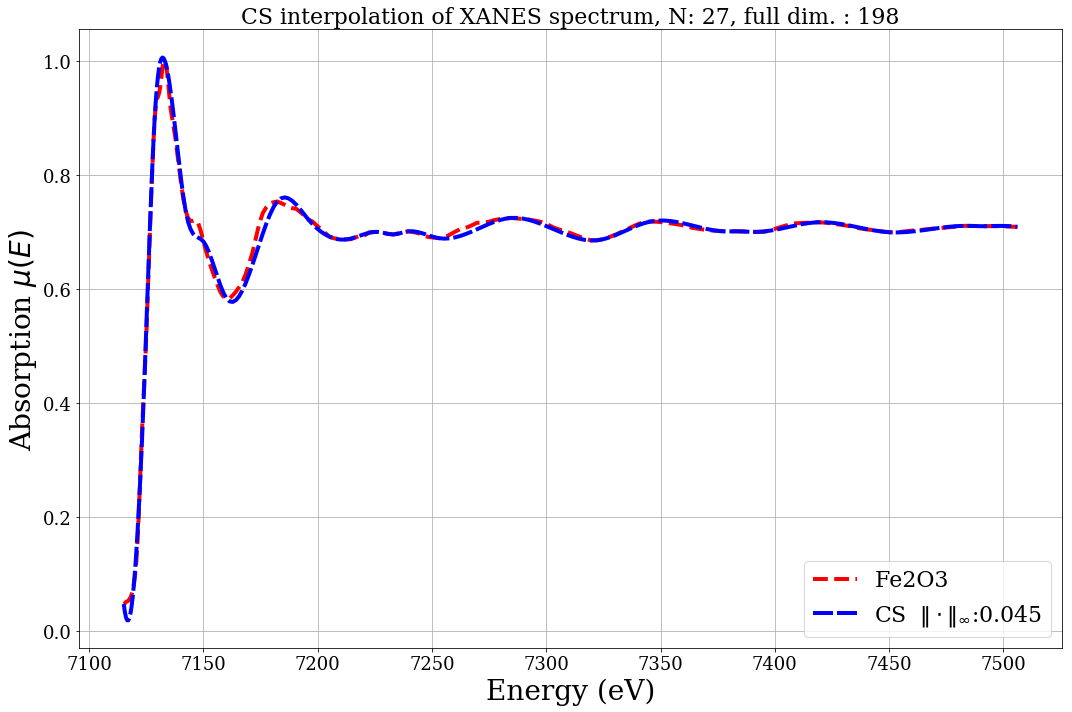

Saving figure as  XANES_splineallxanes_unnormalizedcubicspline


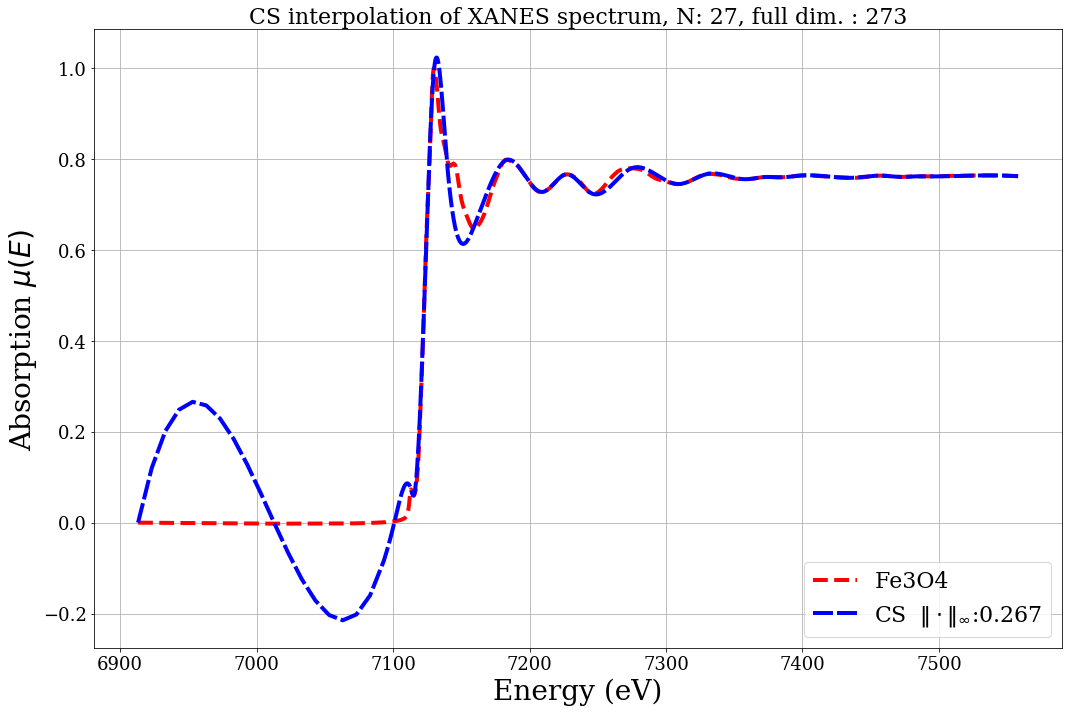

Saving figure as  XANES_splineallxanes_unnormalizedcubicspline


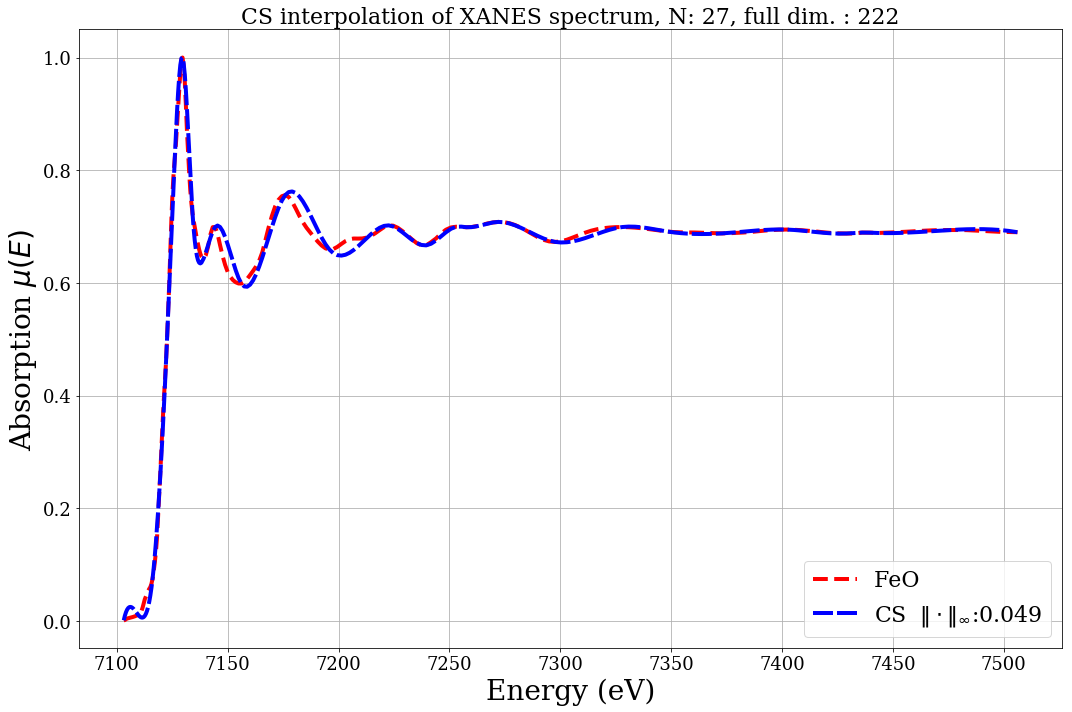

In [60]:
breakpts,_ = normalize_points(parameters,names,decompositions,k=1.1,kind='middle_domain')

_,_,_=interpolate_same_size(parameters,breakpts,names,'cubicspline',"allxanes_unnormalized",bdry='unpadded',bdry_add=4)

Now let's interpolate only before main peak

In case we only want to interpolate on the pre-peak we do the following:

In [61]:
number_splittings_after_zeros = dict.fromkeys(parameters, 1)
number_splittings_after_zeros

{'Fe foil': 1, 'Fe2O3': 1, 'Fe3O4': 1, 'FeO': 1}

In such acase, we also need to change the stopping

In [62]:
stop_at_main_peak = dict.fromkeys(stopping, 0)

for name in names:
    decomposition_now = decompositions[name]
    peak_loc = decomposition_now['peak_location']
    stop_at_main_peak[name] = peak_loc[str(0)]

stop_at_main_peak   

{'Fe foil': 95, 'Fe2O3': 98, 'Fe3O4': 92, 'FeO': 91}

In [63]:
breakpts_only_before,_ = normalize_points(
    parameters, names, decompositions,k=2,kind='middle_domain',how_many_after=1
)

breakpts_only_before

Number of breakpoints is: 10.0


{'Fe foil': array([ 0,  1, 13, 23, 33, 43, 54, 74, 84, 95], dtype=int16),
 'Fe2O3': array([62, 66, 68, 71, 75, 80, 84, 89, 93, 98], dtype=int16),
 'Fe3O4': array([ 0, 10, 22, 34, 46, 58, 62, 69, 77, 92], dtype=int16),
 'FeO': array([38, 44, 47, 51, 57, 64, 70, 77, 84, 91], dtype=int16)}

In [64]:
breakpts_only_before

{'Fe foil': array([ 0,  1, 13, 23, 33, 43, 54, 74, 84, 95], dtype=int16),
 'Fe2O3': array([62, 66, 68, 71, 75, 80, 84, 89, 93, 98], dtype=int16),
 'Fe3O4': array([ 0, 10, 22, 34, 46, 58, 62, 69, 77, 92], dtype=int16),
 'FeO': array([38, 44, 47, 51, 57, 64, 70, 77, 84, 91], dtype=int16)}

Saving figure as  XANES_polygonalallxanesbeforelinear


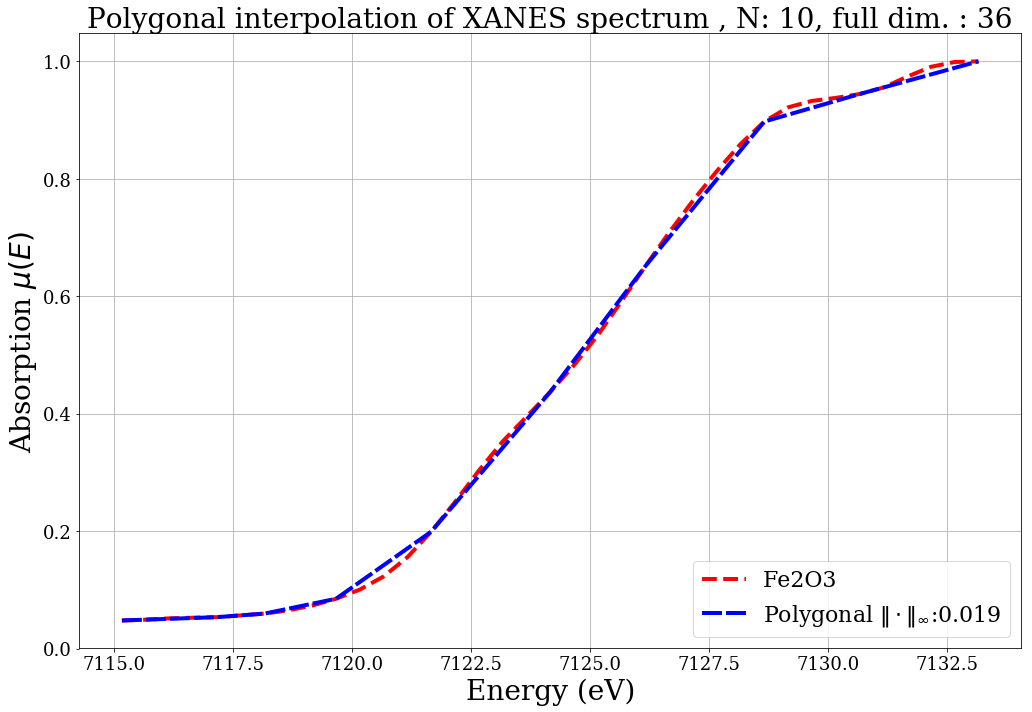

({'Fe2O3': (<scipy.interpolate.interpolate.interp1d at 0x7fe95bd2d728>,)},
 {'Fe2O3': 0.019},
 {'Fe2O3': 0.212})

In [65]:
interpolate_same_size(
    parameters,breakpts_only_before,{names[1]},'linear',"allxanesbefore",bdry='padded',bdry_add=4)

Number of breakpoints is: 24.0
Saving figure as  XANES_splineallxanesbeforecubicspline


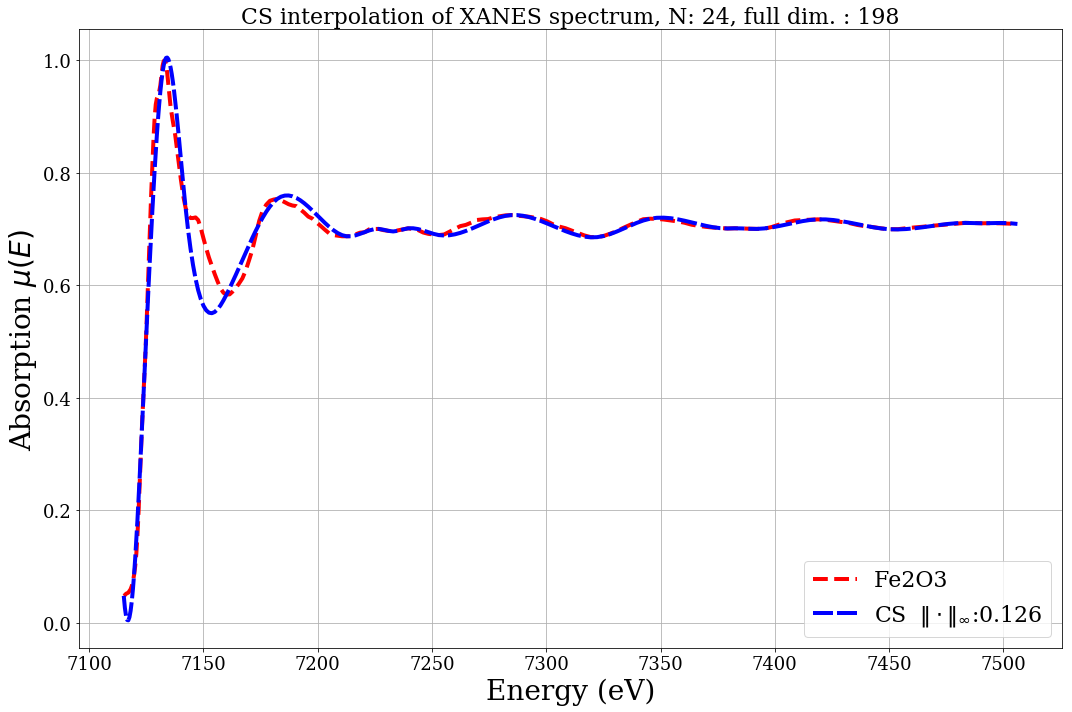

({'Fe2O3': <scipy.interpolate.interpolate.interp1d at 0x7fe96604bc78>},
 {'Fe2O3': 0.126},
 {'Fe2O3': 3.495})

In [66]:
breakpts,_ = normalize_points(parameters,{names[1]},decompositions,k=1.1,kind='middle_domain')
interpolate_same_size(parameters,breakpts,{names[1]},'cubicspline',"allxanesbefore",bdry='unpadded',bdry_add=4)

Last, we test the case of equally spaced interpolation

Number of breakpoints is: 24.0
Saving figure as  XANES_splineallxanes_unnormalizedequally_spaced_splines


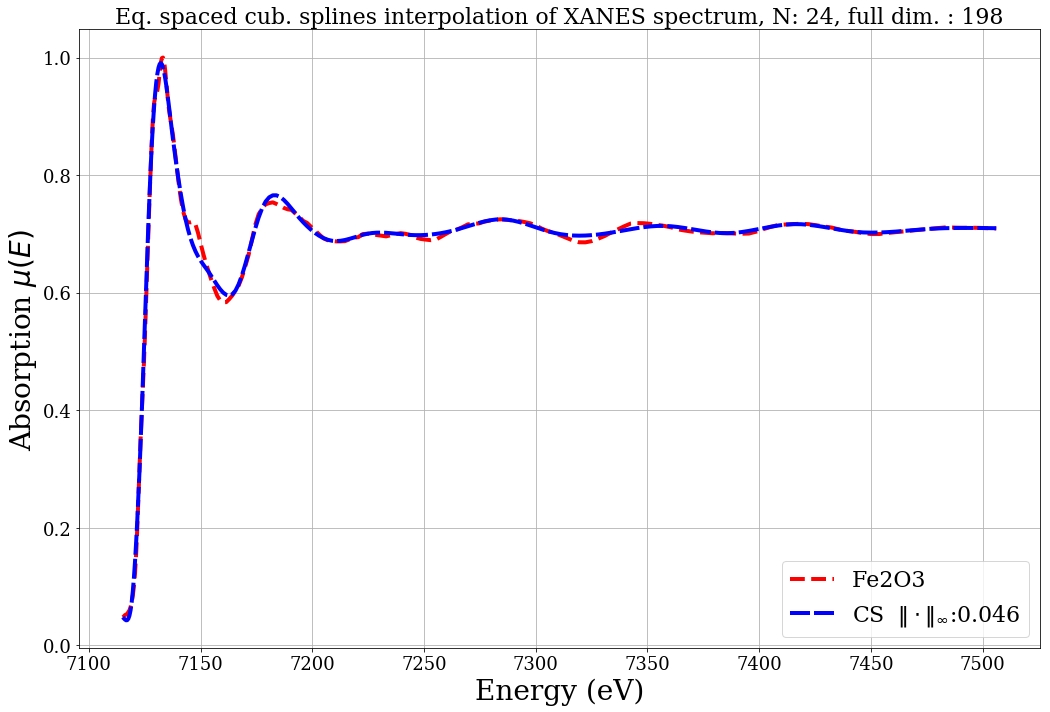

({'Fe2O3': <scipy.interpolate.interpolate.interp1d at 0x7fe95a44b098>},
 {'Fe2O3': 0.046},
 {'Fe2O3': 1.193})

In [67]:
breakpts,_ = normalize_points(parameters,{names[1]},decompositions,k=1.1,kind='middle_domain')
interpolate_same_size(parameters,breakpts,{names[1]},'equally_spaced_splines',"allxanes_unnormalized",bdry='padded',bdry_add=4)

Number of breakpoints is: 24.0
Saving figure as  XANES_splineallxanes_unnormalizedequally_spaced_polygonal


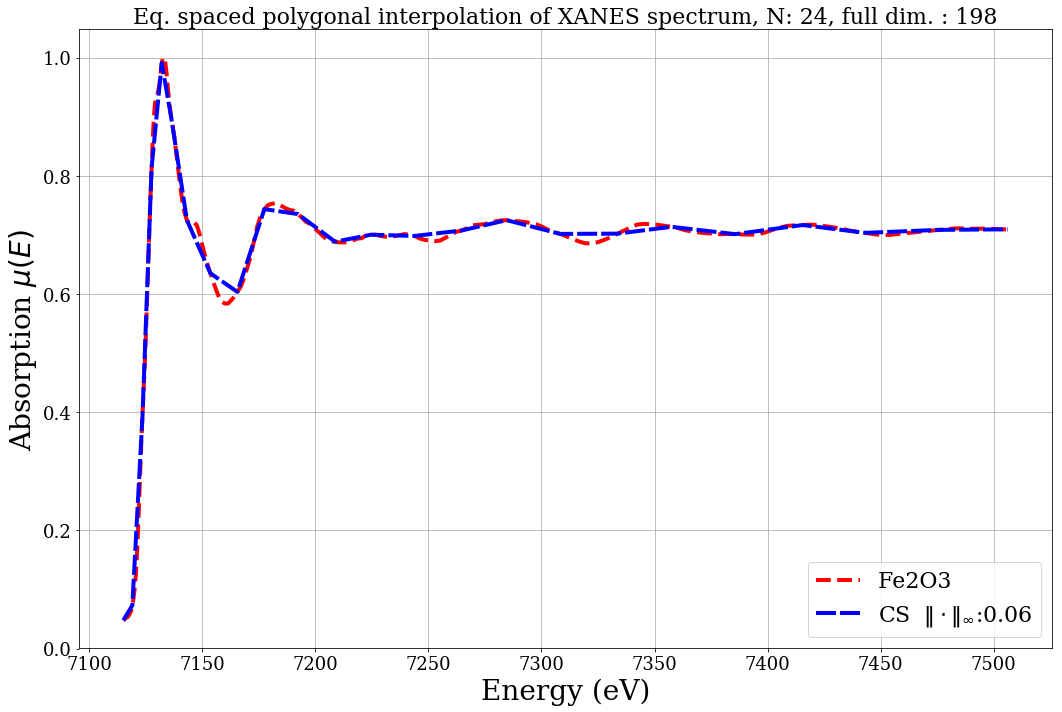

({'Fe2O3': <scipy.interpolate.interpolate.interp1d at 0x7fe95a46e278>},
 {'Fe2O3': 0.06},
 {'Fe2O3': 1.684})

In [68]:
breakpts,_ = normalize_points(parameters,{names[1]},decompositions,k=1.1,kind='middle_domain')
interpolate_same_size(parameters,breakpts,{names[1]},'equally_spaced_polygonal',"allxanes_unnormalized",bdry='padded',bdry_add=4)

Number of breakpoints is: 24.0
Saving figure as  XANES_polygonalallxanes_unnormalizedlinear


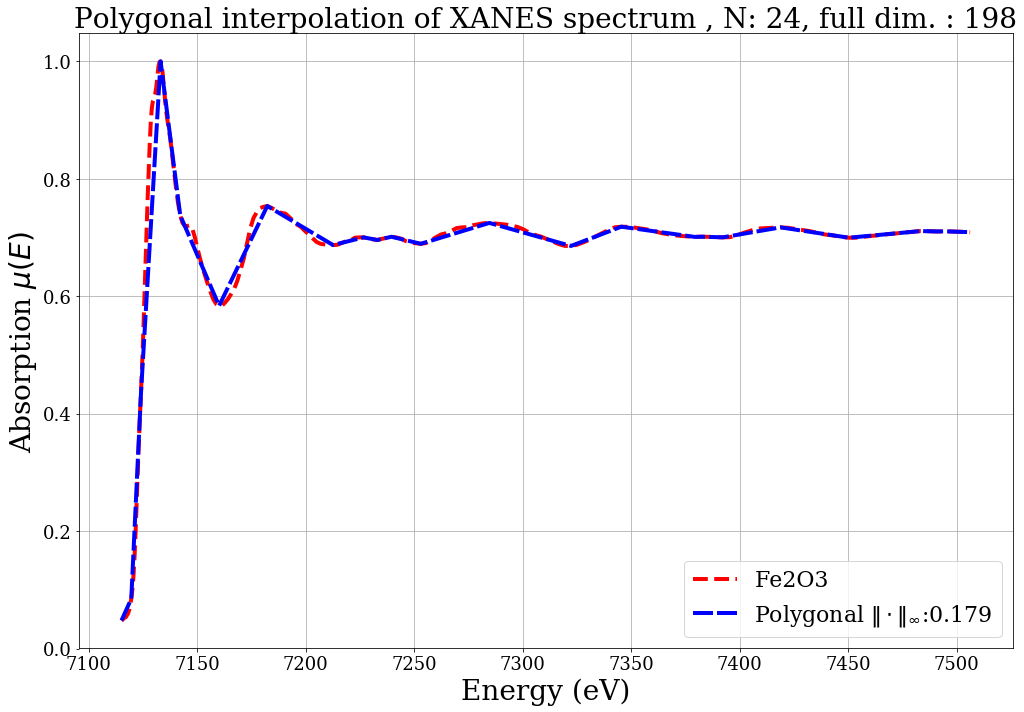

({'Fe2O3': (<scipy.interpolate.interpolate.interp1d at 0x7fe95bd99818>,)},
 {'Fe2O3': 0.179},
 {'Fe2O3': 2.732})

In [69]:
breakpts,_ = normalize_points(parameters,{names[1]},decompositions,k=1.1,kind='middle_domain')
interpolate_same_size(parameters,breakpts,{names[1]},'linear',"allxanes_unnormalized",bdry='padded',bdry_add=4)

Finally, we are ready to implement the approximation using clamped splines. The idea here is a bit different though: we shall interpolate inside each sub interval, finding then a cubic splines whose derivatives on the boundary are 0. 

In [70]:
from scipy.interpolate import CubicSpline

def clamped_interpolation(parameters,breakpts,decompositions,names,printing=True,derivative=[0]):
    '''
    ----------------
    Input:
    - parameters: dictionary with materials' properties
    - names: names of materials studied
    - decomposition: dictionary with information about peaks and their locations
    - derivative: plot derivative of order [0], [1], or [0, 1]
    - breakpts: ordered breakpoints
    - printing: print computations (True) or not  (False)
    ----------------
    ''' 
    if printing:
        plt.figure(figsize=(15,10))
        plt.rc('font', family='serif')
        plt.rc('xtick', labelsize=28)
        plt.rc('ytick', labelsize=28)
        ax =plt.subplot(111)
        
    cubic_splines_clamped ={}
    
    for name in names:
        
        ##############################################################
        # UNPACKING...
        # ... parameters
        cubic_splines_clamped[name] = {}
        decomposition_now = decompositions[name]

        xanes_now = parameters[name]['xanes']
        E_now =parameters[name]['energy']
        xanes_now_unpad = parameters[name]['raw_xanes']
        
        peak_loc = decomposition_now['peak_location']

        number_splittings_before = decomposition_now['number_of_splittings_before']
        number_splittings_after = decomposition_now['number_of_splittings_after']
        
        l_infty, l_1 = 0, 0
        
        ticks = np.array(breakpts[name],dtype=np.int16)
        #print("ticks",ticks)
        ticks= ticks.reshape(1,-1)
        
        ### There is an issue with peak_locs: it can have duplicates; we need to clean them 
        # uncleaned
        vector_peak_loc = np.array([peak_loc[str(i)]  for i in range(-number_splittings_before,number_splittings_after)])
        #...cleaning
        vector_peak_loc = remove_duplicates(vector_peak_loc)
        
        ## Truncate to the range of the pbreakpoints:
        vector_peak_loc = vector_peak_loc[np.where(vector_peak_loc >=breakpts[name][0])]
        vector_peak_loc = vector_peak_loc[np.where(vector_peak_loc <=breakpts[name][-1])]
        
        start = vector_peak_loc[0]
        stop = vector_peak_loc[-1]
        
        full_dimension = stop-start
        if printing:
            plt.plot(
            E_now[0,start:stop+1].T,xanes_now[0,start:stop+1].T,'-',color='red',lw=4
        )
        
        N = np.shape(ticks)[1]
        for i in range(len(vector_peak_loc)-1):
            left, right = vector_peak_loc[i] ,vector_peak_loc[i+1]
            #print(i, left,right)
            x= E_now[0,left:right+1]
            y = xanes_now[0,left:right+1]
            
            range_of_interest = np.where((ticks>=left)*(ticks<=right) ==True)[1]
            
            selected_points = ticks[0,range_of_interest]
            
            x_interp = np.squeeze(E_now[0,selected_points])
            y_interp = np.squeeze(xanes_now[0,selected_points])
            
            cs_glue = CubicSpline(x_interp, y_interp,bc_type='clamped')
            
            ## calculate error on each interval
            v = np.array(y-cs_glue(np.array(x)),ndmin=1)
            #  l_infty error
            l_infty_in_this_interval= max(np.abs(v))
            l_infty = max(float(l_infty),l_infty_in_this_interval)
            
            #  l_1 error
            l_1 += np.sum(np.abs(v))
            
            cubic_splines_clamped[name].update(
                {
                str(i)+"cubic_spline":cs_glue,
                str(i)+"points_interp":x_interp,
                str(i)+"x_interval":x,
                str(i)+"l_infty_in_this_interval":l_infty_in_this_interval
                }
            )
        
            if printing:
                for d in derivative:
                    colors = ['b','g']
                    plt.plot(
                        x.T,cs_glue(x,d).T,color=colors[d],lw=4,linestyle='--'
                    )
        cubic_splines_clamped[name].update(
            {
            "l_infty":l_infty,
                "l_1":l_1,
            "vector_peak_loc":vector_peak_loc    
            }
        )
        
    if printing:
        
        blue_patch = mpatches.Patch(
            color='blue', label='GCCS.\n $\ell^{\infty}$ error:'+str(np.round(l_infty,3))
        )
        red_patch = mpatches.Patch(color='red',label = 'Xanes: '+name)
        
        ax.legend(handles=[red_patch, blue_patch],loc=1,prop={'size':18})
        plt.ylabel('Absorption $\mu(E)$',size=28)
        plt.xlabel("Energy (eV)", size=28)
        plt.title('GCCS of XANES spectrum, N: '+str(N)+', full dim. : ' +str(full_dimension), size=28)
        plt.grid(True)
        figure_save("clamped_splines_of"+name+"with"+str(N)+"points")
        plt.show()    
    
    return cubic_splines_clamped

Let's test

Number of breakpoints is: 24.0
Saving figure as  clamped_splines_ofFe2O3with24points


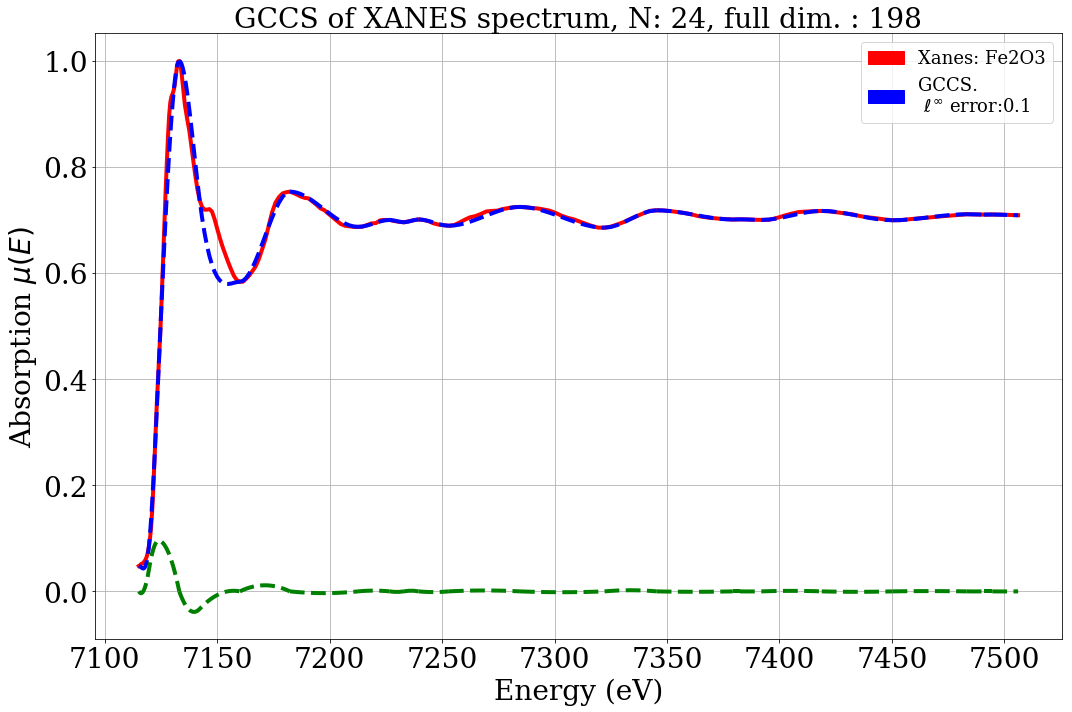

In [71]:
name = {names[1]}
k_test = 1.1
breakpts,N = normalize_points(parameters,name,decompositions,k=k_test,kind='middle_domain')


clamped_outcome=clamped_interpolation(parameters,breakpts,decompositions,name,printing=True,derivative=[0,1])

Note that the output "clamped_output" is a dictionary. Let's check its keys:

In [72]:
clamped_outcome

{'Fe2O3': {'0cubic_spline': <scipy.interpolate._cubic.CubicSpline at 0x7fe95bd39258>,
  '0l_infty_in_this_interval': 0.07108295785291519,
  '0points_interp': array([7115.163, 7119.663, 7124.163, 7133.163]),
  '0x_interval': array([7115.163, 7115.663, 7116.163, 7116.663, 7117.163, 7117.663,
         7118.163, 7118.663, 7119.163, 7119.663, 7120.163, 7120.663,
         7121.163, 7121.663, 7122.163, 7122.663, 7123.163, 7123.663,
         7124.163, 7124.663, 7125.163, 7125.663, 7126.163, 7126.663,
         7127.163, 7127.663, 7128.163, 7128.663, 7129.163, 7129.663,
         7130.163, 7130.663, 7131.163, 7131.663, 7132.163, 7132.663,
         7133.163]),
  '10cubic_spline': <scipy.interpolate._cubic.CubicSpline at 0x7fe9660a0360>,
  '10l_infty_in_this_interval': 0.0011708930443053989,
  '10points_interp': array([7322.246, 7345.417]),
  '10x_interval': array([7322.246, 7325.076, 7327.925, 7330.792, 7333.68 , 7336.585,
         7339.51 , 7342.454, 7345.417]),
  '11cubic_spline': <scipy.interpo

I know... it looks messy.  But the key that we shall use the most is the l_infty error key. For instance, in the case of FeO, the l_infty error is

In [73]:
clamped_outcome[names[1]]['l_infty']

0.10046008937847484

Number of breakpoints is: 24.0
Saving figure as  clamped_splines_ofFeOwith24points


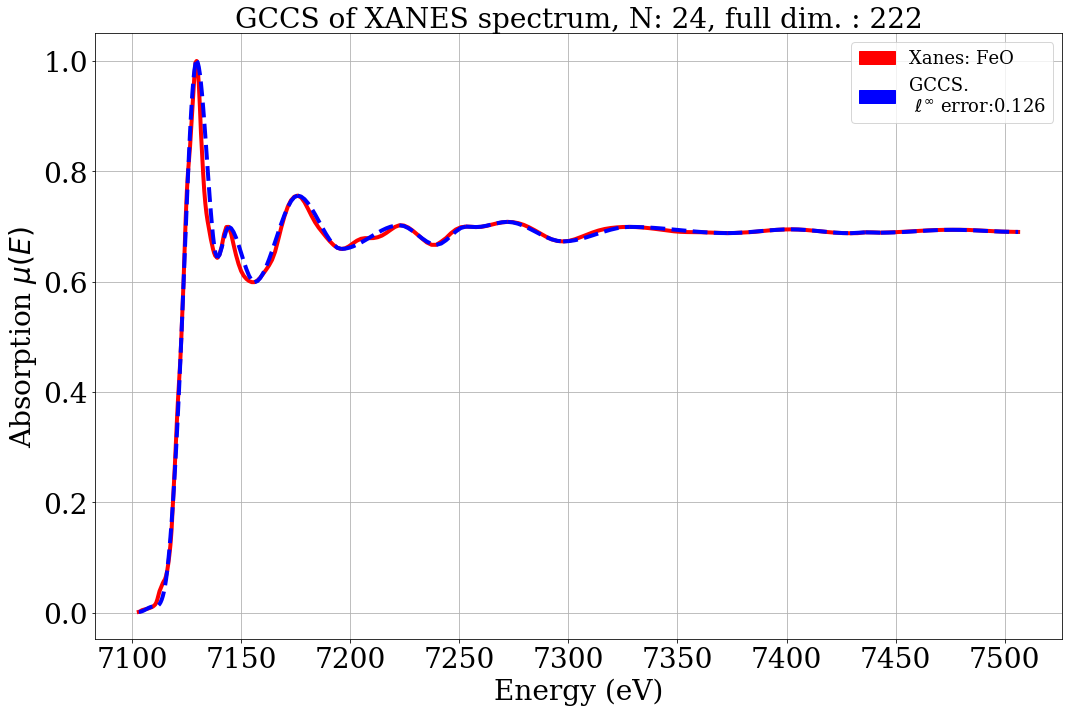

In [74]:
name = {names[3]}
k_test = 1.1
breakpts,N = normalize_points(parameters,name,decompositions,k=k_test,kind='middle_domain')
clamped_outcome=clamped_interpolation(parameters,breakpts,decompositions,name,printing=True,derivative=[0])

Just for comparison, with an usual spline

Saving figure as  XANES_splineequally_spaced_splinesofFeOwith24pointsequally_spaced_splines


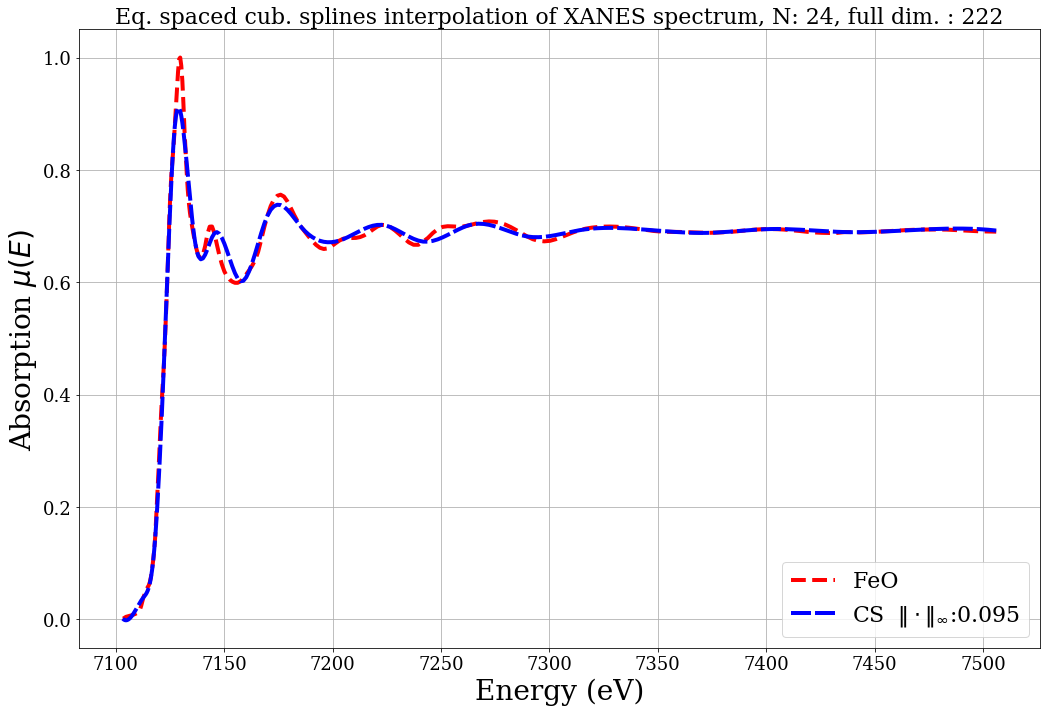

({'FeO': <scipy.interpolate.interpolate.interp1d at 0x7fe95bd2d3b8>},
 {'FeO': 0.095},
 {'FeO': 2.028})

In [75]:
type_interp = 'equally_spaced_splines'
interpolate_same_size(
    parameters,breakpts,{names[3]},type_interp,type_interp+"of"+names[3]+"with"+str(int(N))+"points",\
    bdry='unpadded',bdry_add=4
)

Number of breakpoints is: 24.0
Saving figure as  XANES_splinecubicsplineofFeOwith24pointscubicspline


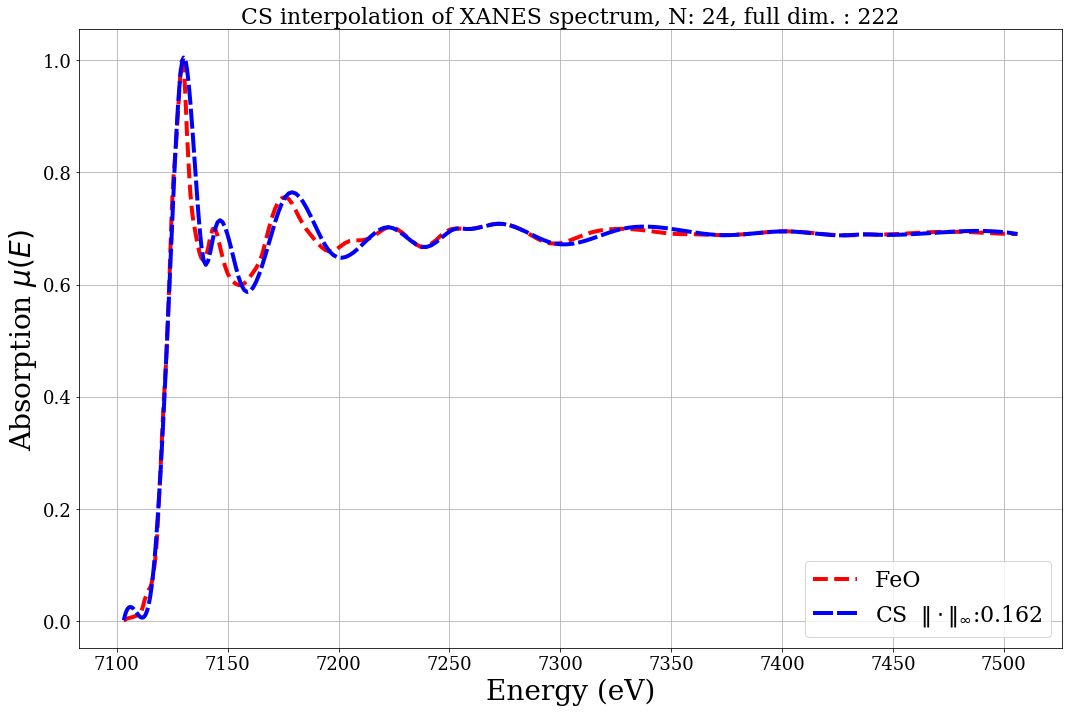

({'FeO': <scipy.interpolate.interpolate.interp1d at 0x7fe95a4712c8>},
 {'FeO': 0.162},
 {'FeO': 3.774})

In [76]:
breakpts,_ = normalize_points(parameters,{names[3]},decompositions,k=1.1,kind='middle_domain')
type_interp ='cubicspline'
interpolate_same_size(parameters,breakpts,{names[3]},type_interp,type_interp+"of"+names[3]+"with"+str(int(N))+"points",bdry='unpadded',bdry_add=4)

Now we compare the polygonals

Saving figure as  XANES_splineequally_spaced_polygonalofFeOwith24pointsequally_spaced_polygonal


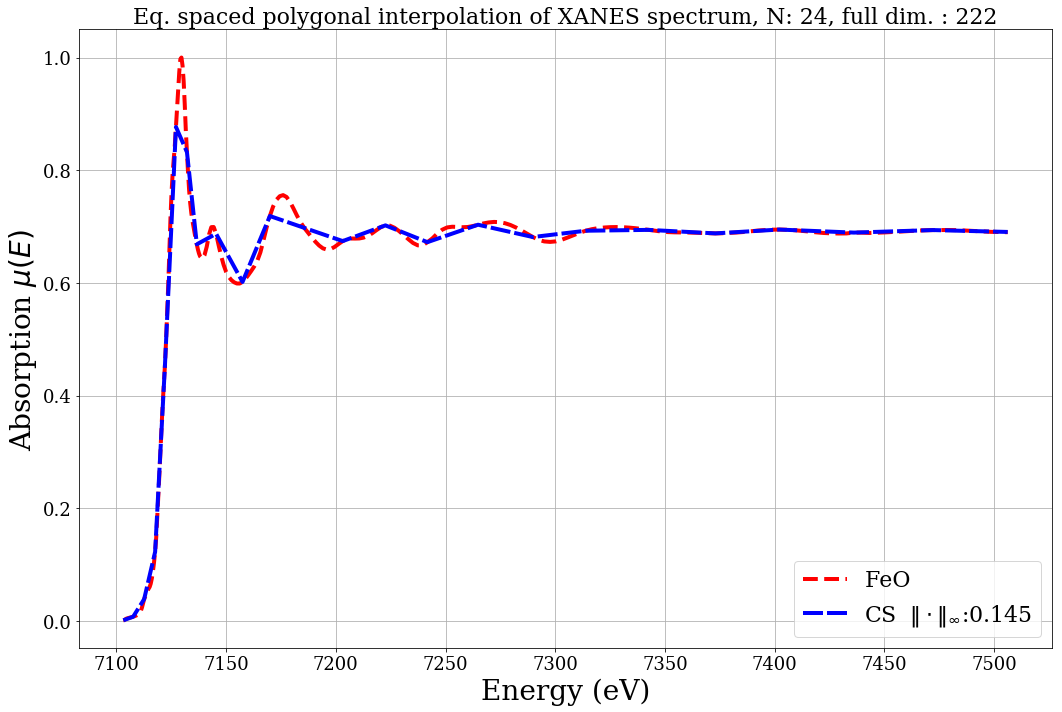

({'FeO': <scipy.interpolate.interpolate.interp1d at 0x7fe9570efae8>},
 {'FeO': 0.145},
 {'FeO': 2.9})

In [77]:
type_interp = 'equally_spaced_polygonal'

interpolate_same_size(parameters,breakpts,{names[3]},type_interp,type_interp+"of"+names[3]+"with"+str(int(N))+"points",bdry='padded',bdry_add=4)

Saving figure as  XANES_polygonallinearofFeOwith24pointslinear


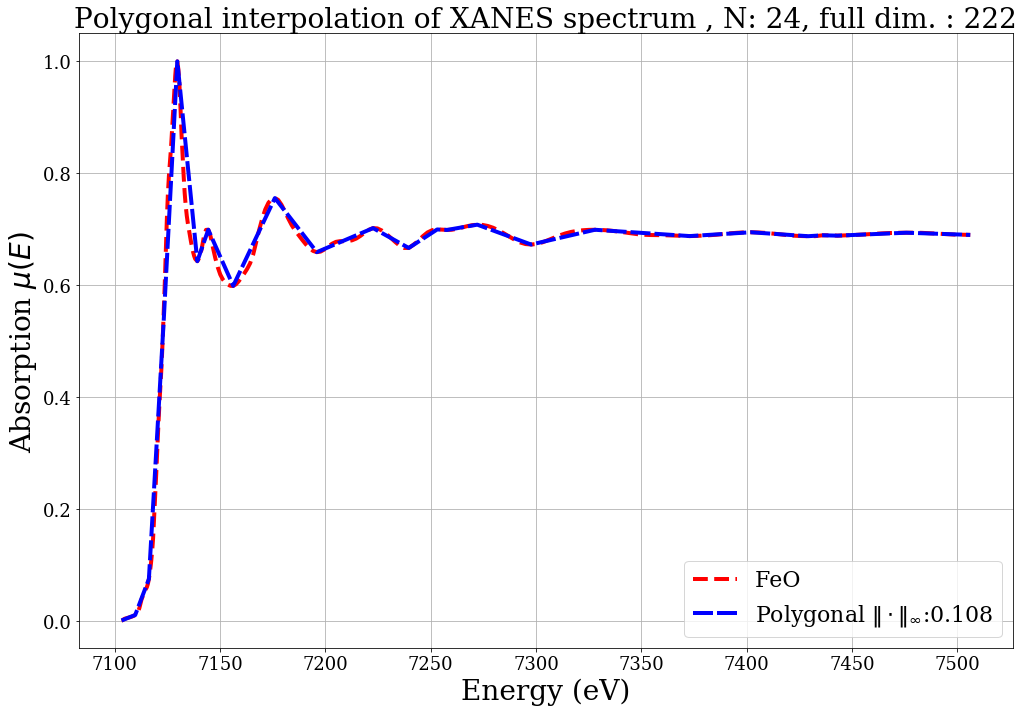

({'FeO': (<scipy.interpolate.interpolate.interp1d at 0x7fe960521548>,)},
 {'FeO': 0.108},
 {'FeO': 2.929})

In [78]:
type_interp = 'linear'

interpolate_same_size(parameters,breakpts,{names[3]},type_interp,type_interp+"of"+names[3]+"with"+str(int(N))+"points",bdry='padded',bdry_add=4)

<h2><center> Error decay as N increases: $\ell^{\infty}$ case</center></h2>

Saving figure as  l_infty_interp_errorlinear


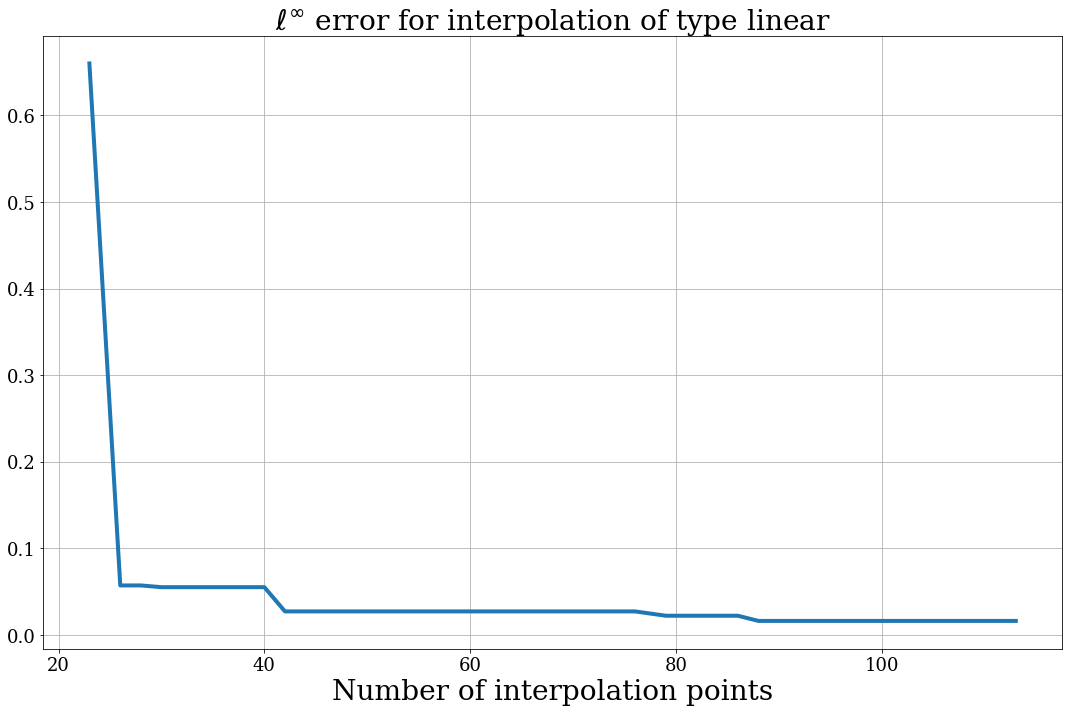

In [79]:
S = 40
errors = np.zeros([len(names),S])
Norm_number = np.zeros([S])
type_interp = 'linear'

for i in range(S):
    breakpts, Norm_number[i] = normalize_points(parameters, {names[0]}, decompositions,k=1+0.1*i,printing=False)
    _, l_infty_errors,_=interpolate_same_size(parameters,breakpts,{names[0]},type_interp,"allxanes",bdry='unpadded',bdry_add=4,printing=False)
    for j in range(len({names[0]})):
        errors[j,i] = l_infty_errors[names[j]]

plt.figure(figsize=(15,10))
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

for i in range(len({names[0]})):
    plt.plot(
        Norm_number,errors[i,:],color='C'+str(i),linestyle='-',lw=4
    )
    plt.grid(True)

plt.title('$\ell^{\infty}$ error for interpolation of type '+type_interp,size=28)
plt.xlabel('Number of interpolation points',size=28)
figure_save("l_infty_interp_error"+type_interp)
plt.show()

Let's try the same for clamped splines

Saving figure as  l_infty_interp_errorclamped


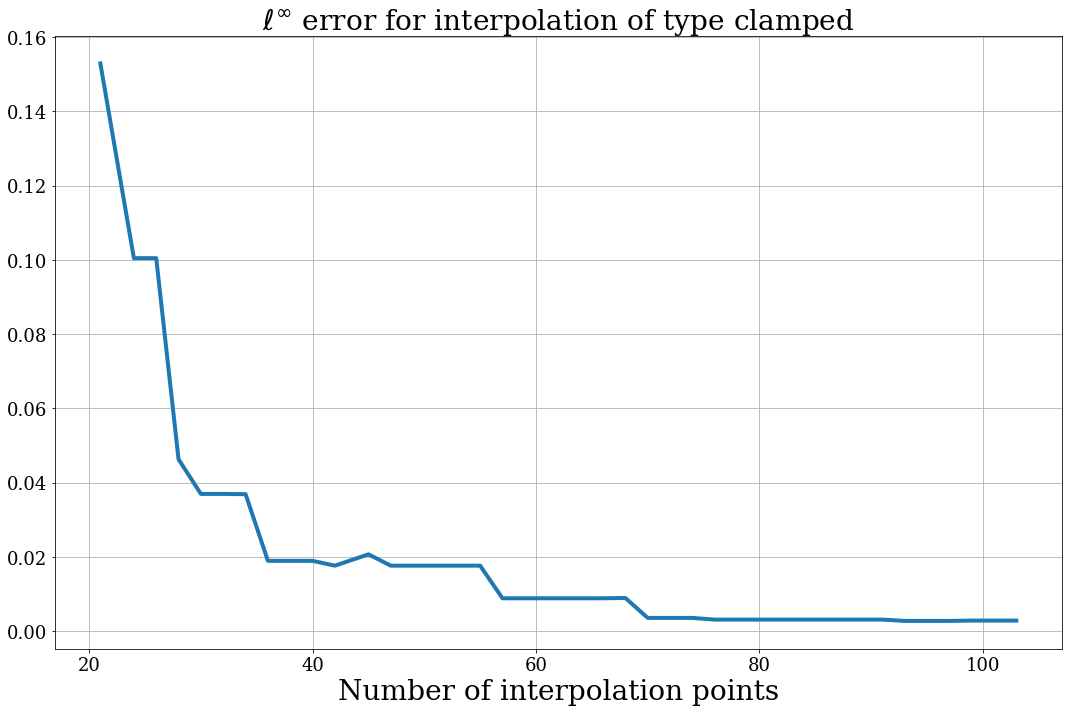

In [80]:
S = 40
errors = np.zeros([len(names),S])
Norm_number = np.zeros([S])
type_interp = 'clamped'

name = names[1]
for i in range(S):
    breakpts, Norm_number[i] = normalize_points(parameters, {name}, decompositions,k=1+0.1*i,printing=False)
    clamped_outcome=clamped_interpolation(parameters,breakpts,decompositions,{name},printing=False,derivative=[0])
    
    for j in range(len({name})):
        l_infty_errors[names[j+1]]=clamped_outcome[names[j+1]]['l_infty']
        errors[j,i] = l_infty_errors[names[j+1]]

plt.figure(figsize=(15,10))
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

for i in range(len({names[0]})):
    plt.plot(
        Norm_number,errors[i,:],color='C'+str(i),linestyle='-',lw=4
    )
    plt.grid(True)

plt.title('$\ell^{\infty}$ error for interpolation of type '+type_interp,size=28)
plt.xlabel('Number of interpolation points',size=28)
figure_save("l_infty_interp_error"+type_interp)
plt.show()

Saving figure as  l_infty_interp_error_comparison_all_spline_types


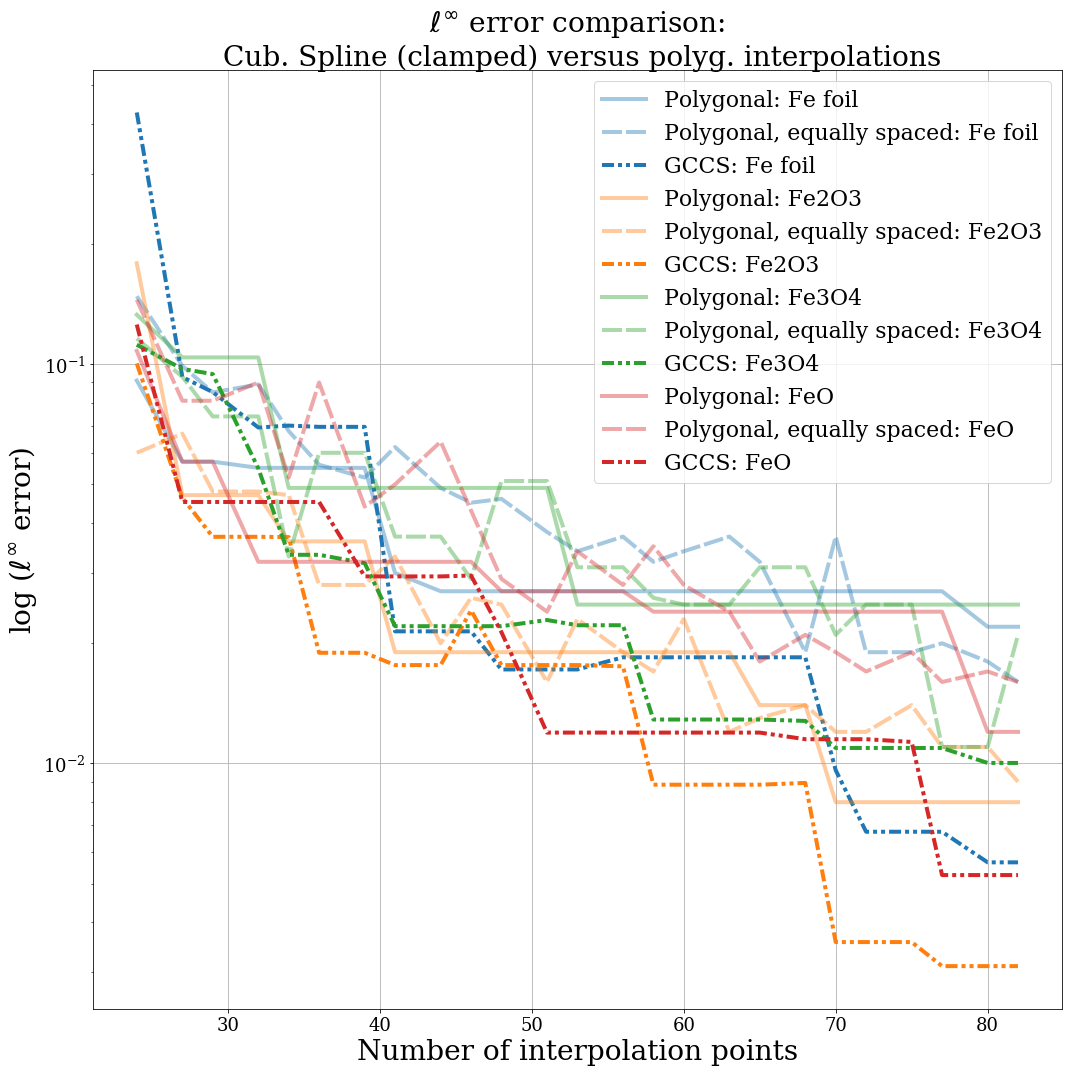

In [81]:
S = 25
errors_lin= np.zeros([len(names),S])
errors_eq_lin = np.zeros([len(names),S])
errors_eq_clamped = np.zeros([len(names),S])
Norm_number_before = np.zeros([S])

for i in range(S):
    breakpts, Norm_number_before[i] = normalize_points(parameters, names, decompositions,k=1+0.1*i,printing=False)
    type_interp_1 = 'linear'
    _, l_infty_errors,_=interpolate_same_size(parameters,breakpts,names,type_interp_1,"allxanes",bdry='padded',bdry_add=4,printing=False)

    type_interp_2 = 'equally_spaced_polygonal'
    _, l_infty_errors_eq_lin,_=interpolate_same_size(parameters,breakpts,names,type_interp_2,"allxanes",bdry='padded',bdry_add=4,printing=False)
    
    type_interp_3 = 'Clamped splines'
    clamped_outcome=clamped_interpolation(parameters,breakpts,decompositions,names,printing=False,derivative=[0])
    for j in range(len(names)):
        errors_lin[j,i] = l_infty_errors[names[j]]
        errors_eq_lin[j,i] = l_infty_errors_eq_lin[names[j]]
        errors_eq_clamped[j,i] = clamped_outcome[names[j]]['l_infty']

plt.figure(figsize=(15,15))    
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

for i in range(len(names)): 
    plt.plot(
        Norm_number_before,errors_lin[i,:],linestyle='-',color= 'C'+str(i),\
        label='Polygonal: '+names[i],lw=4,alpha=.4
    )
    plt.plot(
        Norm_number_before,errors_eq_lin[i,:],linestyle=(0, (5,1)),color= 'C'+str(i),\
        label='Polygonal, equally spaced: '+names[i],lw=4,alpha=.4
    )
    plt.plot(
        Norm_number_before,errors_eq_clamped[i,:],linestyle=(0, (3, 1, 1, 1, 1, 1)),color= 'C'+str(i),\
        label='GCCS: '+names[i],lw=4
    )
    
    plt.grid(True)

plt.title('$\ell^{\infty}$ error comparison:\n Cub. Spline (clamped) versus polyg. interpolations',size=28)
plt.legend(loc=1,prop={'size':22})
plt.xlabel('Number of interpolation points',size=28)
plt.ylabel('log ($\ell^{\infty}$ error)',size=28)

plt.yscale('log')
figure_save("l_infty_interp_error_comparison_all_spline_types")
plt.show()

Saving figure as  l_infty_interp_errorcubicsplineequally_spaced_splinesClamped_splines


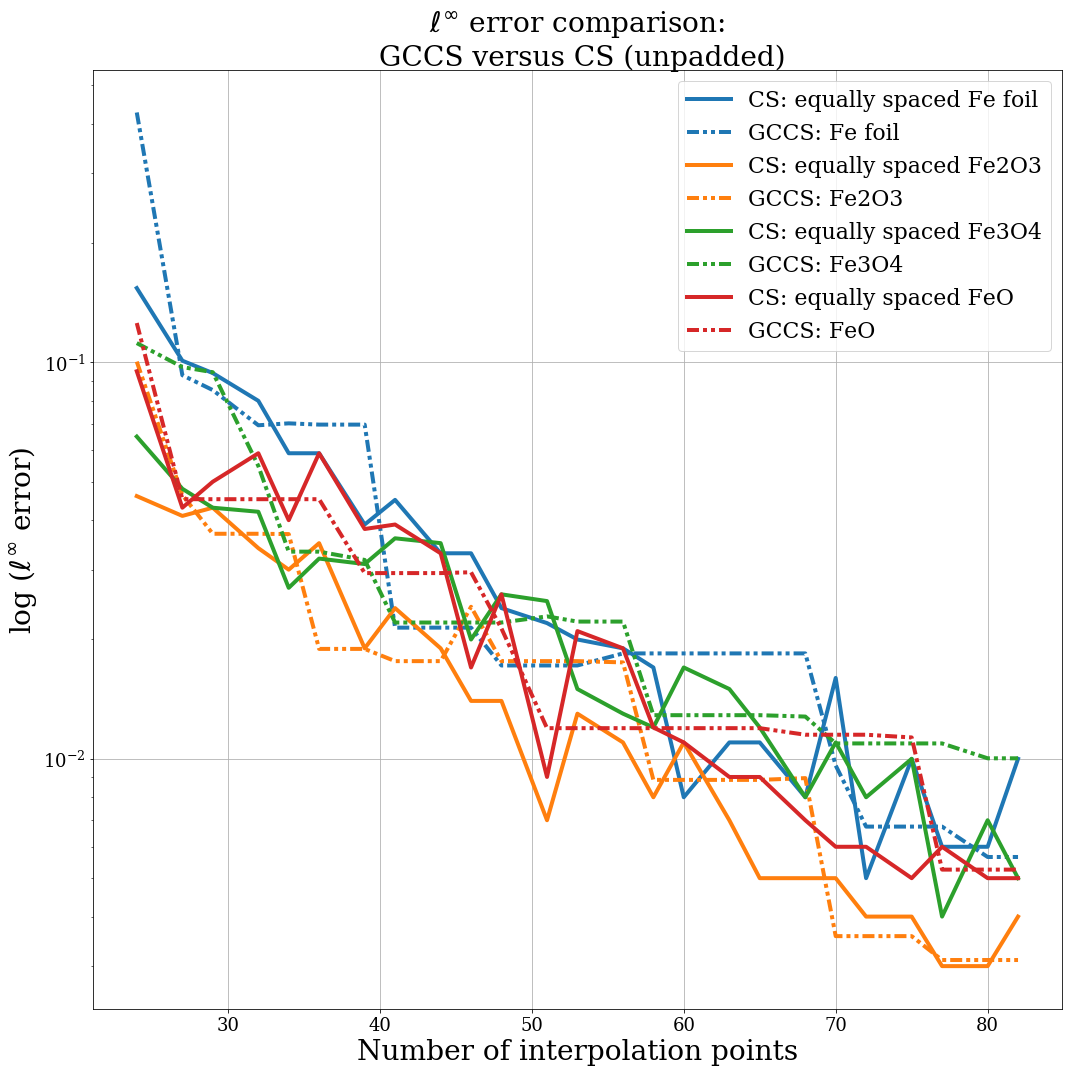

In [82]:
S = 25
errors_lin= np.zeros([len(names),S])
errors_eq_lin = np.zeros([len(names),S])
errors_eq_clamped = np.zeros([len(names),S])
Norm_number_before = np.zeros([S])

for i in range(S):
    breakpts, Norm_number_before[i] = normalize_points(parameters, names, decompositions,k=1+0.1*i,printing=False)
    type_interp_1 = 'cubicspline'
    _, l_infty_errors,_=interpolate_same_size(parameters,breakpts,names,type_interp_1,"allxanes",bdry='unpadded',bdry_add=0,printing=False)
    
    type_interp_2 = 'equally_spaced_splines'
    _, l_infty_errors_eq_lin,_=interpolate_same_size(parameters,breakpts,names,type_interp_2,"allxanes",bdry='unpadded',bdry_add=0,printing=False)
    
    type_interp_3 = 'Clamped splines'
    clamped_outcome=clamped_interpolation(parameters,breakpts,decompositions,names,printing=False,derivative=[0])
    for j in range(len(names)):
        errors_lin[j,i] = l_infty_errors[names[j]]
        errors_eq_lin[j,i] = l_infty_errors_eq_lin[names[j]]
        errors_eq_clamped[j,i] = clamped_outcome[names[j]]['l_infty']

plt.figure(figsize=(15,15))    
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

for i in range(len(names)):    #color='C'+str(i)
    '''
    plt.plot(
        Norm_number_before,errors_lin[i,:],linestyle='-',color= 'C'+str(i),label='CS: '+names[i],lw=4,alpha=1
    )
    '''
    plt.plot(
        Norm_number_before,errors_eq_lin[i,:],linestyle='-',color= 'C'+str(i),label='CS: equally spaced '+names[i],lw=4,alpha=1
    )
    plt.plot(
        Norm_number_before,errors_eq_clamped[i,:],linestyle=(0, (3, 1, 1, 1, 1, 1)),color= 'C'+str(i),\
        label='GCCS: '+names[i],lw=4,alpha=1
    )
   
    plt.grid(True)

plt.title('$\ell^{\infty}$ error comparison:\n GCCS versus CS (unpadded)',size=28)
plt.legend(loc=1,prop={'size':22})
plt.yscale('log')
plt.xlabel('Number of interpolation points',size=28)
plt.ylabel('log ($\ell^{\infty}$ error)',size=28)
figure_save("l_infty_interp_error"+type_interp_1+type_interp_2+type_interp_3)

plt.show()

<h2><center> Error decay as N increases: $l_{1}$ case</h2></center>

Saving figure as  l_1_interp_error_comparison_all_spline_types


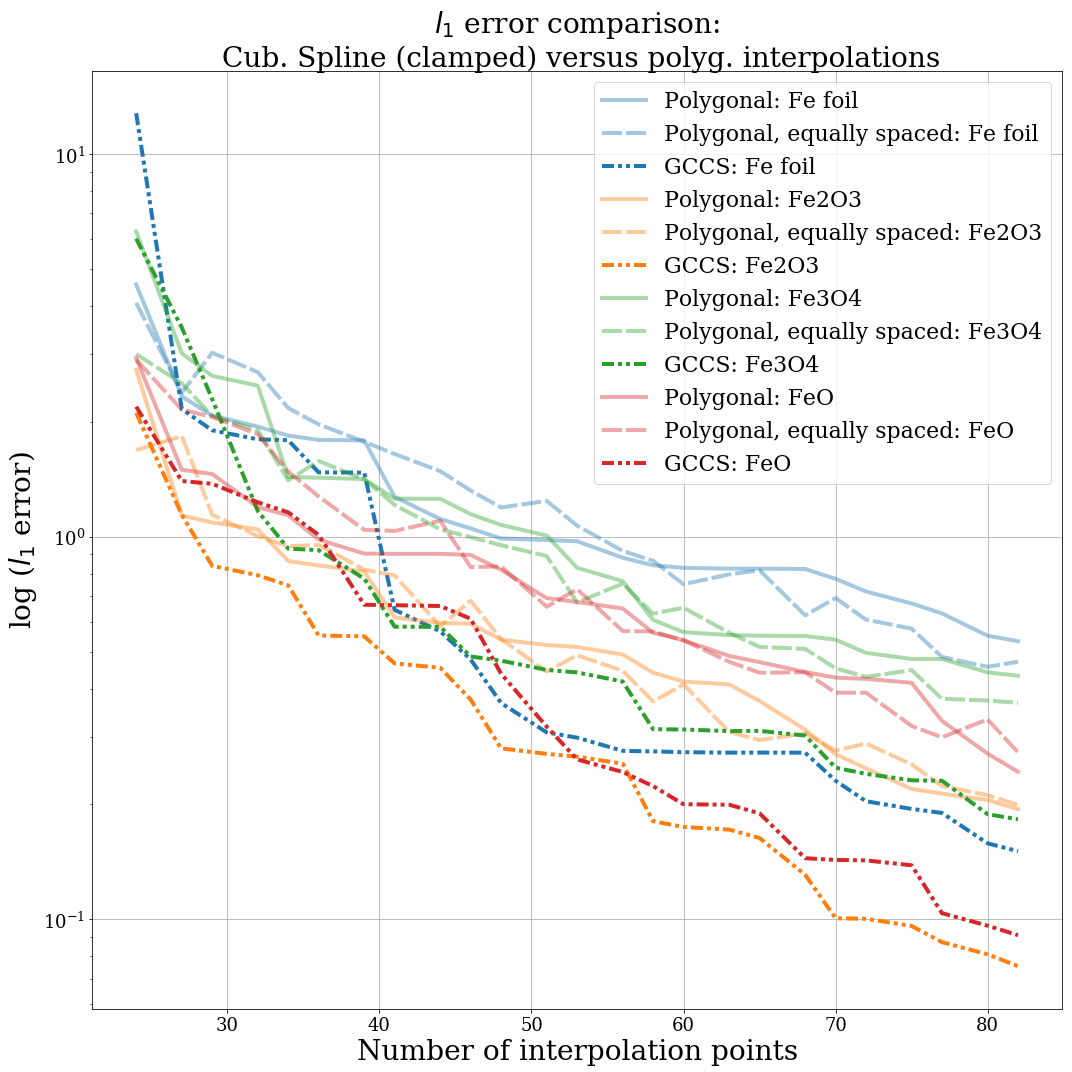

In [83]:
S = 25
errors_lin= np.zeros([len(names),S])
errors_eq_lin = np.zeros([len(names),S])
errors_eq_clamped = np.zeros([len(names),S])
Norm_number_before = np.zeros([S])

for i in range(S):
    breakpts, Norm_number_before[i] = normalize_points(parameters, names, decompositions,k=1+0.1*i,printing=False)
    type_interp_1 = 'linear'
    _,_, l_1_errors=interpolate_same_size(parameters,breakpts,names,type_interp_1,"allxanes",bdry='padded',bdry_add=4,printing=False)

    type_interp_2 = 'equally_spaced_polygonal'
    _,_, l_1_errors_eq_lin=interpolate_same_size(parameters,breakpts,names,type_interp_2,"allxanes",bdry='padded',bdry_add=4,printing=False)
    
    type_interp_3 = 'Clamped splines'
    clamped_outcome=clamped_interpolation(parameters,breakpts,decompositions,names,printing=False,derivative=[0])
    for j in range(len(names)):
        errors_lin[j,i] = l_1_errors[names[j]]
        errors_eq_lin[j,i] = l_1_errors_eq_lin[names[j]]
        errors_eq_clamped[j,i] = clamped_outcome[names[j]]['l_1']

plt.figure(figsize=(15,15))    
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

for i in range(len(names)): 
    plt.plot(
        Norm_number_before,errors_lin[i,:],linestyle='-',color= 'C'+str(i),\
        label='Polygonal: '+names[i],lw=4,alpha=.4
    )
    plt.plot(
        Norm_number_before,errors_eq_lin[i,:],linestyle=(0, (5,1)),color= 'C'+str(i),\
        label='Polygonal, equally spaced: '+names[i],lw=4,alpha=.4
    )
    plt.plot(
        Norm_number_before,errors_eq_clamped[i,:],linestyle=(0, (3, 1, 1, 1, 1, 1)),color= 'C'+str(i),\
        label='GCCS: '+names[i],lw=4
    )
    
    plt.grid(True)

plt.title('$l_{1}$ error comparison:\n Cub. Spline (clamped) versus polyg. interpolations',size=28)
plt.legend(loc=1,prop={'size':22})
plt.xlabel('Number of interpolation points',size=28)
plt.ylabel('log ($l_{1}$ error)',size=28)

plt.yscale('log')
figure_save("l_1_interp_error_comparison_all_spline_types")
plt.show()

Saving figure as  l_1_interp_errorcubicsplineequally_spaced_splinesClamped_splines


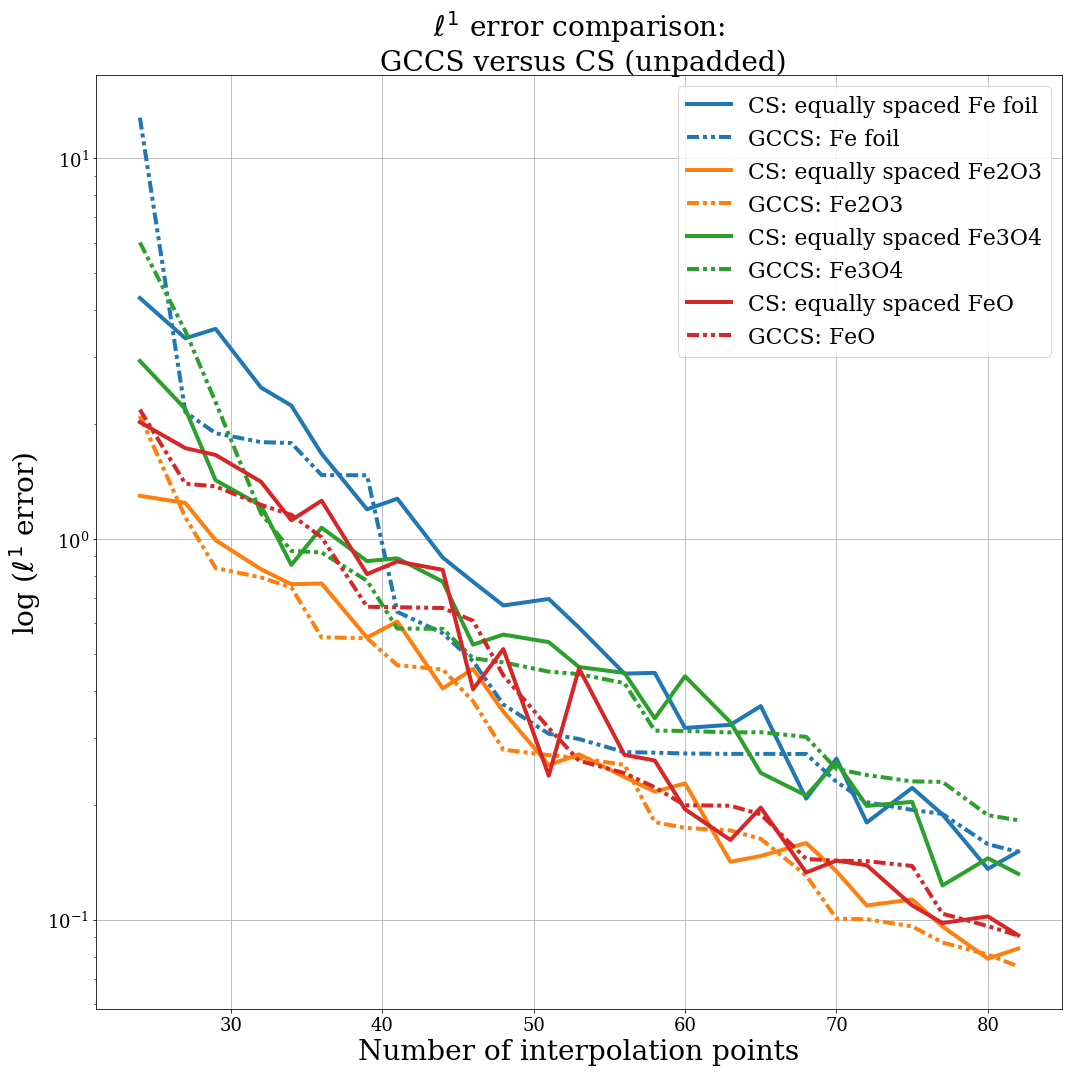

In [84]:
S = 25
errors_lin= np.zeros([len(names),S])
errors_eq_lin = np.zeros([len(names),S])
errors_eq_clamped = np.zeros([len(names),S])
Norm_number_before = np.zeros([S])

for i in range(S):
    breakpts, Norm_number_before[i] = normalize_points(parameters, names, decompositions,k=1+0.1*i,printing=False)
    type_interp_1 = 'cubicspline'
    _,_, l_1_errors=interpolate_same_size(parameters,breakpts,names,type_interp_1,"allxanes",bdry='unpadded',bdry_add=0,printing=False)
    
    type_interp_2 = 'equally_spaced_splines'
    _,_, l_1_errors_eq_lin=interpolate_same_size(parameters,breakpts,names,type_interp_2,"allxanes",bdry='unpadded',bdry_add=0,printing=False)
    
    type_interp_3 = 'Clamped splines'
    clamped_outcome=clamped_interpolation(parameters,breakpts,decompositions,names,printing=False,derivative=[0])
    for j in range(len(names)):
        errors_lin[j,i] = l_1_errors[names[j]]
        errors_eq_lin[j,i] = l_1_errors_eq_lin[names[j]]
        errors_eq_clamped[j,i] = clamped_outcome[names[j]]['l_1']

plt.figure(figsize=(15,15))    
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

for i in range(len(names)):    #color='C'+str(i)
    '''
    plt.plot(
        Norm_number_before,errors_lin[i,:],linestyle='-',color= 'C'+str(i),\
        label='CS: '+names[i],lw=4,alpha=1
    )
    '''
    plt.plot(
        Norm_number_before,errors_eq_lin[i,:],linestyle='-',color= 'C'+str(i),\
        label='CS: equally spaced '+names[i],lw=4,alpha=1
    )
    plt.plot(
        Norm_number_before,errors_eq_clamped[i,:],linestyle=(0, (3, 1, 1, 1, 1, 1)),color= 'C'+str(i),\
        label='GCCS: '+names[i],lw=4,alpha=1
    )
   
    plt.grid(True)

plt.title('$\ell^{1}$ error comparison:\n GCCS versus CS (unpadded)',size=28)
plt.legend(loc=1,prop={'size':22})
plt.yscale('log')
plt.xlabel('Number of interpolation points',size=28)
plt.ylabel('log ($\ell^{1}$ error)',size=28)
figure_save("l_1_interp_error"+type_interp_1+type_interp_2+type_interp_3)

plt.show()

# Comparison between finite differences derivative and spline derivative

Number of breakpoints is: 23.0
Number of breakpoints is: 26.0
Number of breakpoints is: 28.0
Number of breakpoints is: 30.0
Number of breakpoints is: 33.0
Number of breakpoints is: 35.0
Number of breakpoints is: 37.0
Number of breakpoints is: 40.0
Number of breakpoints is: 42.0
Number of breakpoints is: 44.0
Number of breakpoints is: 46.0
Number of breakpoints is: 49.0
Number of breakpoints is: 51.0
Number of breakpoints is: 53.0
Number of breakpoints is: 56.0
Number of breakpoints is: 58.0
Number of breakpoints is: 60.0
Number of breakpoints is: 63.0
Number of breakpoints is: 65.0
Number of breakpoints is: 67.0
Number of breakpoints is: 69.0
Number of breakpoints is: 72.0
Number of breakpoints is: 74.0
Number of breakpoints is: 76.0
Number of breakpoints is: 79.0
Number of breakpoints is: 81.0
Number of breakpoints is: 83.0
Number of breakpoints is: 86.0
Number of breakpoints is: 88.0
Number of breakpoints is: 90.0
Number of breakpoints is: 92.0
Number of breakpoints is: 95.0
Number o

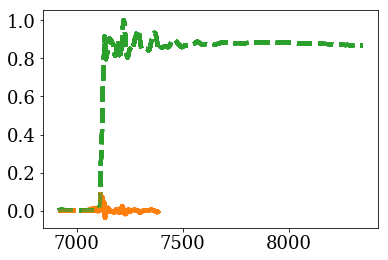

In [85]:
S = 40
errors_lin= np.zeros([len(names),S])
errors_eq_lin = np.zeros([len(names),S])
errors_eq_clamped = np.zeros([len(names),S])
Norm_number_before = np.zeros([S])
name= names[0]

## Unpacking...
# ...parameters
E_now = parameters[name]['energy']
start=0
stop = parameters[name]['stop']

for i in range(S):
    breakpts_only_before, Norm_number_before[i] = normalize_points(
        parameters, {name}, decompositions,k=1+0.1*i,printing=False
    )
    type_interp_1 = 'cubicspline'
    approx, l_infty_errors_lin,_=\
    interpolate_same_size(
        parameters,breakpts,{name},type_interp_1,"allxanes",bdry='padded',bdry_add=4,printing=False
    )
    cs = approx[name]
    ##compute the firs derivative
    y = splev(E_now[0,start:stop], cs, der=1)           
    
    ## Now the clamped spline
    breakpts,N = normalize_points(parameters,{name},decompositions,k=1+0.1*i,kind='middle_domain')
    clamped_outcome=clamped_interpolation(parameters,breakpts,decompositions,{name},printing=False,derivative=[1])
    
    for name in {name}:
        Number_intervals = len(clamped_outcome[name]['vector_peak_loc'])-1
        
        clamped_now = clamped_outcome[name]
        for i in range(Number_intervals):
                # Unpacking....
                ### ....clamped_now
                cs_glue = clamped_now[str(i)+"cubic_spline"]
                x = clamped_now[str(i)+"x_interval"]
                d=1
                plt.plot(
                    x.T,cs_glue(x,d).T,color='C'+str(d),lw=4,linestyle='--'
                )
    
    x=E[name][0,0:stop]
    y=materials[name][0,0:stop]
   
    #cs = approx[name]
    plt.plot(
        x,y,'--',label ="Cubic splines $\Vert\cdot \Vert_{\infty}}$:"+str(l_infty_errors_lin[name])+\
        ", Number of points:"+str(N),color='C'+str(2*i%10),alpha=.2+.5*i,lw=4
    )
    


Number of breakpoints is: 44.0
Number of breakpoints is: 28.0
Saving figure as  first_DerivativeFe_foilcubicspline


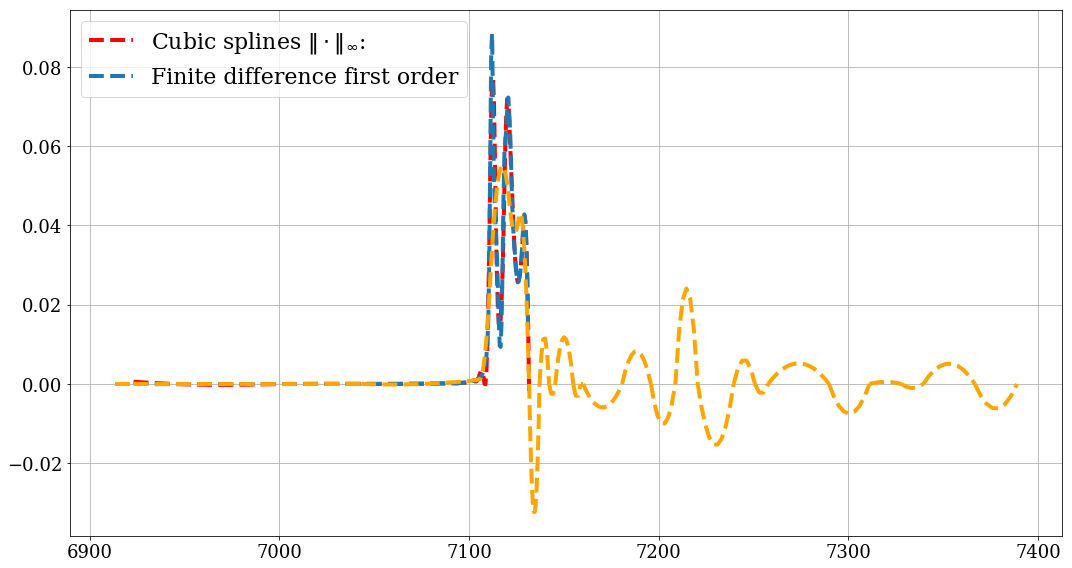

In [86]:
type_interp = 'cubicspline'
name = names[0]

## Unpacking...
# ...parameters
E_now = parameters[name]['energy']
start=0
xanes_now =parameters[name]['xanes']
stop = stop_at_main_peak[name]

plt.figure(figsize=(15,8))

L = stop
finite_difference_first= np.zeros([L])

##############################################################
for i in range(1,L):
    finite_difference_first[i]= (xanes_now[0,i+1]-xanes_now[0,i-1])/(E_now[0,i+1]-E_now[0,i-1])

for i in {2}:
    
    breakpts,N_pts = normalize_points(
        parameters,{name}, decompositions,k=1.9)
    type_interp_1 = 'cubicspline'
    approx, l_infty_errors_lin,_=\
    interpolate_same_size(
        parameters,breakpts,{name},type_interp_1,"allxanes",bdry='padded',bdry_add=4,printing=False
    )
    cs = approx[name]
    ##compute the firs derivative
    plt.plot(
        E_now[0,1:stop+1],splev(E_now[0,1:stop+1],cs,der=1),'--',label ="Cubic splines $\Vert\cdot \Vert_{\infty}}$:",\
        color='red',lw=4
    )
    plt.plot(
        E_now[0,1:stop],finite_difference_first[1:stop],'--',label ="Finite difference first order",\
        color='#1f77b4',lw=4
    )
## Now the clamped spline
breakpts,N = normalize_points(parameters,{name},decompositions,k=1+0.1*i,kind='middle_domain')
clamped_outcome=clamped_interpolation(parameters,breakpts,decompositions,{name},printing=False,derivative=[1])

Number_intervals = len(clamped_outcome[name]['vector_peak_loc'])-1

clamped_now = clamped_outcome[name]
for i in range(Number_intervals):
        # Unpacking....
        ### ....clamped_now
        cs_glue = clamped_now[str(i)+"cubic_spline"]
        x = clamped_now[str(i)+"x_interval"]
        d=1
        plt.plot(
            x.T,cs_glue(x,d).T,color='orange',lw=4,linestyle='--'
        )

        
plt.grid(True)
plt.legend(loc=2,prop={'size':22})
figure_save("first_Derivative"+name+type_interp)
plt.show()    

Now let's compare with the derivatives obtained through athena

Number of breakpoints is: 44.0
Number of breakpoints is: 28.0
Saving figure as  first_Derivative_comparisonFe_foilcubicspline


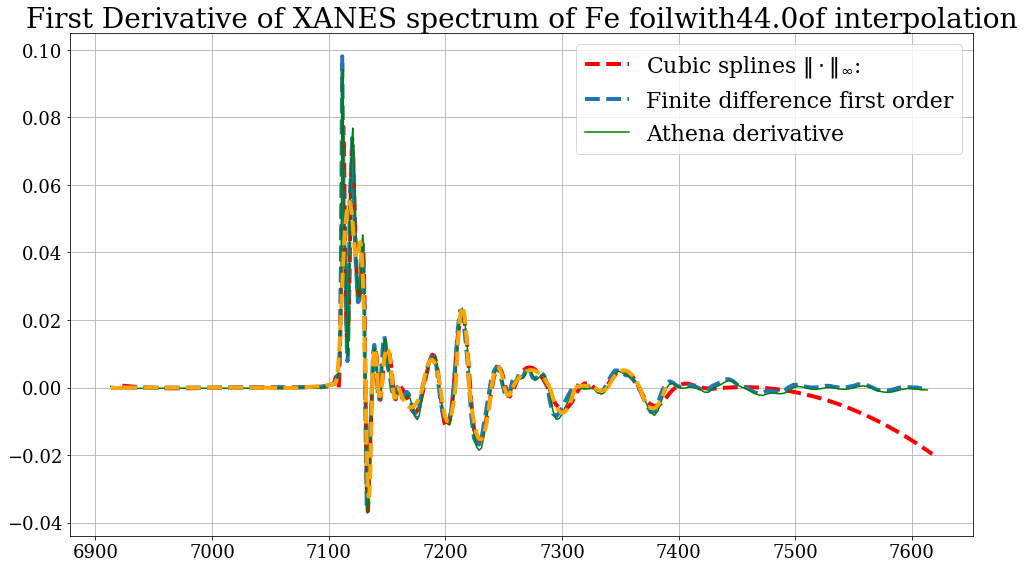

In [87]:
type_interp = 'cubicspline'
name = names[0]

# UNPACKING...
# ... parameters
xanes_now = parameters[name]['xanes']
E_now =parameters[name]['energy']
xanes_now_unpad = parameters[name]['raw_xanes']

# ... decomposition
decomposition_now = decompositions[name]
peak_loc = decomposition_now['peak_location']
number_splittings_before = decomposition_now['number_of_splittings_before']
number_splittings_after = decomposition_now['number_of_splittings_after']
start = peak_loc[str(-number_splittings_before)]
stop = peak_loc[str(number_splittings_after-1)]
            
start = peak_loc[str(-number_splittings_before)]
stop = peak_loc[str(number_splittings_after-1)]
        
plt.figure(figsize=(15,8))
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

L = stop
finite_difference_first= np.zeros([L])

xanes_now =np.array(xanes_now[0,start:stop],ndmin=2)
domain_now = np.array(E_now[0,start:stop],ndmin=2)
for i in range(2,L-1):
    finite_difference_first[i]= (xanes_now[0,i+1]-xanes_now[0,i])/(E_now[0,i+1]-E_now[0,i])

for i in {2}:
    
    breakpts,N_pts = normalize_points(
        parameters,{name}, decompositions,k=1.9)
    type_interp_1 = 'cubicspline'
    approx, l_infty_errors_lin,_=\
    interpolate_same_size(
        parameters,breakpts,{name},type_interp_1,"allxanes",bdry='padded',bdry_add=4,printing=False
    )
    cs = approx[name]
    ##compute the firs derivative
    plt.plot(
        E_now[0,1:stop+1],splev(E_now[0,1:stop+1],cs,der=1),'--',label ="Cubic splines $\Vert\cdot \Vert_{\infty}}$:",\
        color='red',lw=4
    )

    plt.plot(
        E_now[0,1:stop],finite_difference_first[1:stop],'--',label ="Finite difference first order",\
        color='#1f77b4',lw=4
    )
    
    plt.plot(
        E_derivatives[names_1st_derivatives[0]][0,start:stop].T,.3*raw_materials_1st_derivatives[names_1st_derivatives[0]][0,start:stop].T,color='green',label="Athena derivative"
    )
    y=materials[name][0,start:stop]
    
    plt.title("First Derivative of XANES spectrum of "+str(name)+"with"+str(N_pts)+"of interpolation",fontsize=28)
    plt.grid(True)
## Now the clamped spline
breakpts,N = normalize_points(parameters,{name},decompositions,k=1+0.1*i,kind='middle_domain')
clamped_outcome=clamped_interpolation(parameters,breakpts,decompositions,{name},printing=False,derivative=[1])

Number_intervals = len(clamped_outcome[name]['vector_peak_loc'])-1

clamped_now = clamped_outcome[name]
for i in range(Number_intervals):
        # Unpacking....
        ### ....clamped_now
        cs_glue = clamped_now[str(i)+"cubic_spline"]
        x = clamped_now[str(i)+"x_interval"]
        d=1
        plt.plot(
            x.T,cs_glue(x,d).T,color='orange',lw=4,linestyle='--'
        )

plt.grid(True)
plt.legend(fontsize=22)
figure_save("first_Derivative_comparison"+name+type_interp)
plt.show()    

Just the Athena and the clamped spline

No handles with labels found to put in legend.


Number of breakpoints is: 72.0
Number of breakpoints is: 28.0


No handles with labels found to put in legend.


Saving figure as  first_second_Derivative_comparisonFe_foilcubicspline


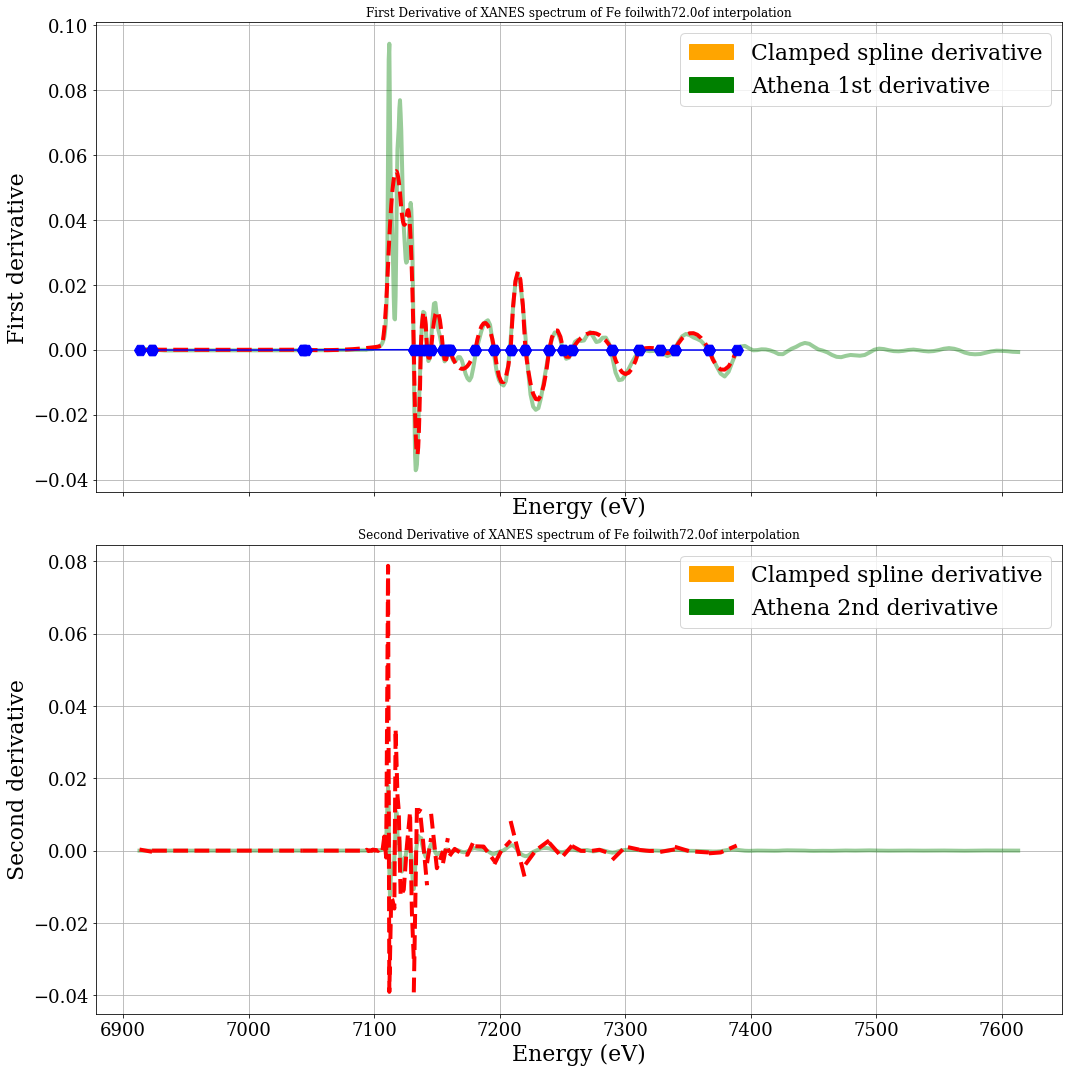

In [88]:
type_interp = 'cubicspline'
name = names[0]

# UNPACKING...
# ... parameters
xanes_now = parameters[name]['xanes']
E_now =parameters[name]['energy']
xanes_now_unpad = parameters[name]['raw_xanes']

# ... decomposition
decomposition_now = decompositions[name]
peak_loc = decomposition_now['peak_location']
number_splittings_before = decomposition_now['number_of_splittings_before']
number_splittings_after = decomposition_now['number_of_splittings_after']
start = peak_loc[str(-number_splittings_before)]
stop = peak_loc[str(number_splittings_after-1)]
            
start = peak_loc[str(-number_splittings_before)]
stop = peak_loc[str(number_splittings_after-1)]
        
L = stop
finite_difference_first= np.zeros([L])

xanes_now =np.array(xanes_now[0,start:stop],ndmin=2)
domain_now = np.array(E_now[0,start:stop],ndmin=2)

f,(ax1,ax2)= plt.subplots(2,1,sharex=True,figsize=(15,15))
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

################################
## SECOND DERIVATIVE

roots ={}
breakpts,N = normalize_points(parameters,{name},decompositions,k=1+0.1*i,kind='middle_domain')

for i in {2}:
    ax2.title.set_text("Second Derivative of XANES spectrum of "+str(name)+"with"+str(N)+"of interpolation")
    ax2.plot(
        E_derivatives[names_1st_derivatives[0]][0,start:stop].T,\
        .3*raw_materials_2nd_derivatives[names_1st_derivatives[0]][0,start:stop].T,\
        color='green',label=None,lw=4,alpha=.4
    )
    y=materials[name][0,start:stop]
    
    ax2.grid(True)
## Now the clamped spline
clamped_outcome=clamped_interpolation(parameters,breakpts,decompositions,{name},printing=False,derivative=[1])

Number_intervals = len(clamped_outcome[name]['vector_peak_loc'])-1

clamped_now = clamped_outcome[name]
for i in range(Number_intervals):
        # Unpacking....
        ### ....clamped_now
        cs_glue = clamped_now[str(i)+"cubic_spline"]
        x = clamped_now[str(i)+"x_interval"]
        
        ## Now find roots in that interval
        roots_aux = cs_glue.derivative().roots()
        truncate=np.where((roots_aux<=x[-1])*(roots_aux>=x[0]))
        roots[str(i)] =roots_aux[truncate]
        
        d=2
        ax2.plot(
            x.T,cs_glue(x,d).T,color='red',lw=4,linestyle='--'
        )

ax2.legend(fontsize=22)
orange_patch = mpatches.Patch(color='orange', label='Clamped spline derivative')
green_patch = mpatches.Patch(color='green', label="Athena 2nd derivative")

ax2.set_xlabel('Energy (eV)',fontsize=22) # X label
ax2.set_ylabel('Second derivative',fontsize=22) # Y label
ax2.legend(handles=[orange_patch, green_patch],fontsize=22)


################################
## FIRST DERIVATIVE

for i in {2}:
    ax1.title.set_text("First Derivative of XANES spectrum of "+str(name)+"with"+str(N)+"of interpolation")
    ax1.plot(
        E_derivatives[names_1st_derivatives[0]][0,start:stop].T,\
        .3*raw_materials_1st_derivatives[names_1st_derivatives[0]][0,start:stop].T,\
        color='green',label=None,lw=4,alpha=.4
    )
    y=materials[name][0,start:stop]
    
    ax1.grid(True)
## Now the clamped spline
breakpts,N = normalize_points(parameters,{name},decompositions,k=1+0.1*i,kind='middle_domain')
clamped_outcome=clamped_interpolation(parameters,breakpts,decompositions,{name},printing=False,derivative=[1])

Number_intervals = len(clamped_outcome[name]['vector_peak_loc'])-1

clamped_now = clamped_outcome[name]
for i in range(Number_intervals):
        # Unpacking....
        ### ....clamped_now
        cs_glue = clamped_now[str(i)+"cubic_spline"]
        x = clamped_now[str(i)+"x_interval"]
        d=1
        ax1.plot(
            x.T,cs_glue(x,d).T,color='red',lw=4,linestyle='--'
        )
        ### PLOT ROOTS
        ax1.plot(
            roots[str(i)],cs_glue(roots[str(i)],d).T,marker='H',markersize=12,color='b'
        )
        
ax1.legend(fontsize=22)
orange_patch = mpatches.Patch(color='orange', label='Clamped spline derivative')
green_patch = mpatches.Patch(color='green', label='Athena 1st derivative')
ax1.set_xlabel('Energy (eV)',fontsize=22) # X label
ax1.set_ylabel('First derivative',fontsize=22) # Y label
ax1.legend(handles=[orange_patch, green_patch],fontsize=22)
figure_save("first_second_Derivative_comparison"+name+type_interp,figure_extension='png')
plt.show()


Well... the graph of second dervatives look ugly, even though the roots are meaningful. We are going to plot it withouth the second derivative plot

No handles with labels found to put in legend.


Number of breakpoints is: 28.0
Number of breakpoints is: 28.0
Saving figure as  first_Derivative_comparisonFe_foilcubicspline


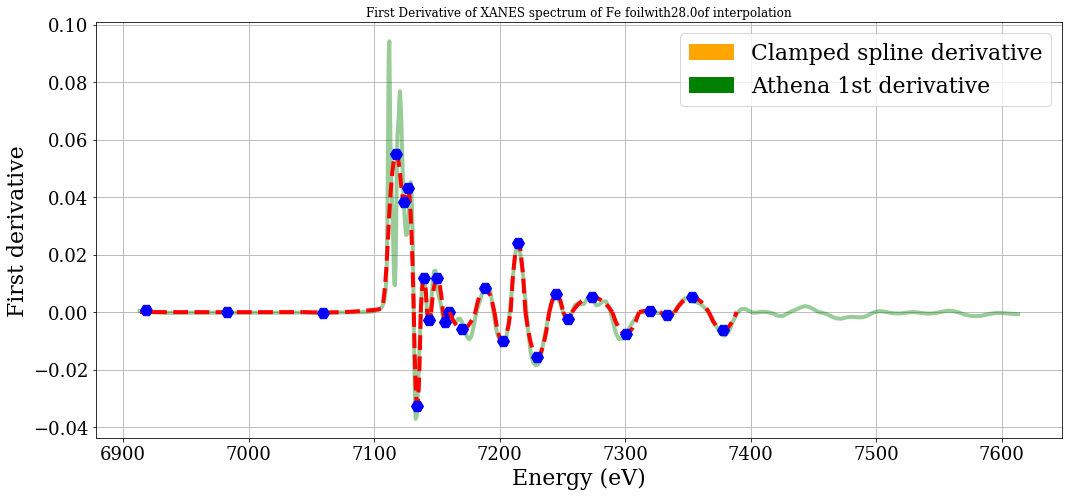

In [89]:
type_interp = 'cubicspline'
name = names[0]

# UNPACKING...
# ... parameters
xanes_now = parameters[name]['xanes']
E_now =parameters[name]['energy']
xanes_now_unpad = parameters[name]['raw_xanes']

# ... decomposition
decomposition_now = decompositions[name]
peak_loc = decomposition_now['peak_location']
number_splittings_before = decomposition_now['number_of_splittings_before']
number_splittings_after = decomposition_now['number_of_splittings_after']
start = peak_loc[str(-number_splittings_before)]
stop = peak_loc[str(number_splittings_after-1)]
            
start = peak_loc[str(-number_splittings_before)]
stop = peak_loc[str(number_splittings_after-1)]
        
L = stop
finite_difference_first= np.zeros([L])

xanes_now =np.array(xanes_now[0,start:stop],ndmin=2)
domain_now = np.array(E_now[0,start:stop],ndmin=2)

f,ax1= plt.subplots(figsize=(15,7))
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

################################
## SECOND DERIVATIVE

roots ={}
i =2
## Now the clamped spline
breakpts,N = normalize_points(parameters,{name},decompositions,k=1+0.1*i,kind='middle_domain')
clamped_outcome=clamped_interpolation(parameters,breakpts,decompositions,{name},printing=False,derivative=[1])

Number_intervals = len(clamped_outcome[name]['vector_peak_loc'])-1

clamped_now = clamped_outcome[name]
for i in range(Number_intervals):
        # Unpacking....
        ### ....clamped_now
        cs_glue = clamped_now[str(i)+"cubic_spline"]
        x = clamped_now[str(i)+"x_interval"]  
        
        ## Now find roots in that interval
        first_derivative = cs_glue.derivative()
        roots_aux = first_derivative.derivative().roots()
        truncate=np.where((roots_aux<=x[-1])*(roots_aux>=x[0]))
        roots[str(i)] =roots_aux[truncate]
        
################################
## FIRST DERIVATIVE

for i in {2}:
    ax1.title.set_text("First Derivative of XANES spectrum of "+str(name)+"with"+str(N)+"of interpolation")
    ax1.plot(
        E_derivatives[names_1st_derivatives[0]][0,start:stop].T,\
        .3*raw_materials_1st_derivatives[names_1st_derivatives[0]][0,start:stop].T,\
        color='green',label=None,lw=4,alpha=.4
    )
    y=materials[name][0,start:stop]
    
    ax1.grid(True)
## Now the clamped spline
breakpts,N = normalize_points(parameters,{name},decompositions,k=1+0.1*i,kind='middle_domain')
clamped_outcome=clamped_interpolation(parameters,breakpts,decompositions,{name},printing=False,derivative=[1])

Number_intervals = len(clamped_outcome[name]['vector_peak_loc'])-1

clamped_now = clamped_outcome[name]
for i in range(Number_intervals):
        # Unpacking....
        ### ....clamped_now
        cs_glue = clamped_now[str(i)+"cubic_spline"]
        x = clamped_now[str(i)+"x_interval"]
        d=1
        ax1.plot(
            x.T,cs_glue(x,d).T,color='red',lw=4,linestyle='--'
        )
        ### PLOT ROOTS
        ax1.plot(
            roots[str(i)],cs_glue(roots[str(i)],d).T,marker='H',markersize=12,color='b',linestyle=''
        )
        
ax1.legend(fontsize=22)
orange_patch = mpatches.Patch(color='orange', label='Clamped spline derivative')
green_patch = mpatches.Patch(color='green', label='Athena 1st derivative')
ax1.set_xlabel('Energy (eV)',fontsize=22) # X label
ax1.set_ylabel('First derivative',fontsize=22) # Y label
ax1.legend(handles=[orange_patch, green_patch],fontsize=22)
figure_save("first_Derivative_comparison"+name+type_interp,figure_extension='png')
plt.show()


Let's do different. Let's find the inflection points of the first derivative and compare that with the second derivative in Athena

No handles with labels found to put in legend.


Number of breakpoints is: 28.0
Number of breakpoints is: 28.0
Saving figure as  first_Derivative_comparison_withAthena_2ndFe_foilcubicspline


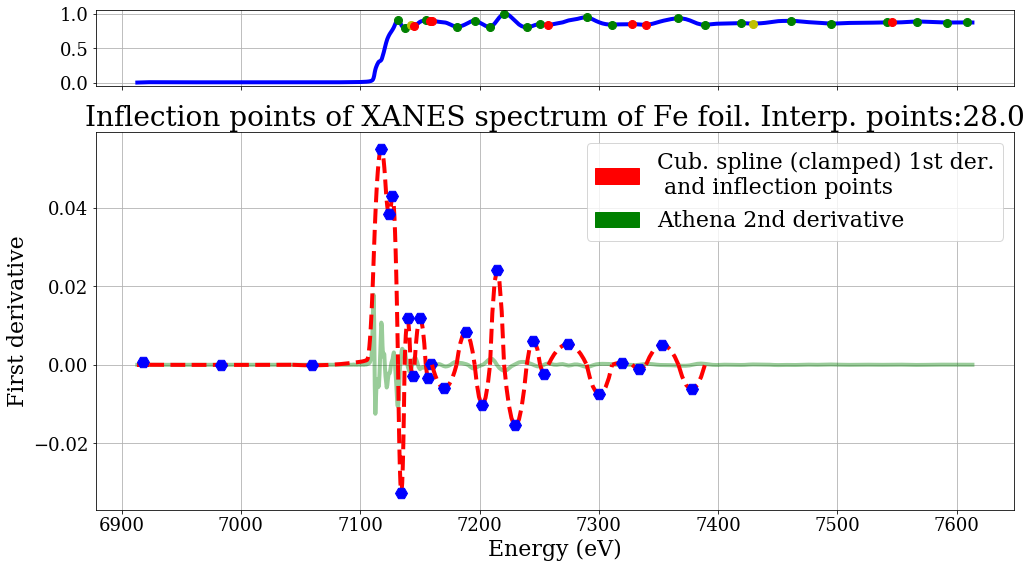

In [90]:
type_interp = 'cubicspline'
name = names[0]

# UNPACKING...
# ... parameters
xanes_now = parameters[name]['xanes']
E_now =parameters[name]['energy']
xanes_now_unpad = parameters[name]['raw_xanes']

# ... decomposition
decomposition_now = decompositions[name]
peak_loc = decomposition_now['peak_location']
jumps = decomposition_now['jumps']
number_splittings_before = decomposition_now['number_of_splittings_before']
number_splittings_after = decomposition_now['number_of_splittings_after']
start = peak_loc[str(-number_splittings_before)]
stop = peak_loc[str(number_splittings_after-1)]
        
L = stop
finite_difference_first= np.zeros([L])
jumps_after = jumps[number_splittings_before-1:]
    
xanes_now =np.array(xanes_now[0,start:stop],ndmin=2)
domain_now = np.array(E_now[0,start:stop],ndmin=2)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)


where_to_stop_plot = int(.8*peak_loc[str(number_splittings_after-1)]+.2*stop)

f,(ax1,ax2)= plt.subplots(2,1,sharex=True, gridspec_kw={'height_ratios': [1, 5]},figsize=(15,8))
ax1.set_yticks([0, .5, 1])
ax1.plot(E_now[0,:where_to_stop_plot].T,xanes_now[0,:where_to_stop_plot].T,color='blue',lw=4) # Plot xanes spectrum 
ax1.grid(True)


#To the right of the main peak
vector_proportion= []
"We shall plot the xanes measurement and the peak variations"
start_from =0

for i in range(start_from,number_splittings_after-1):
     ### Now we plot the h_threshold
    _,_,h_threshold =\
    oscillation_function(\
                         np.array(E_now[0,peak_loc[str(i)]:stop],ndmin=2),\
                         np.array(xanes_now[0,peak_loc[str(i)]:stop],ndmin=2),\
                         full_computation=False)
############################
    ### How much of the jump is noise?
    proportion_noise_jump=h_threshold/jumps_after[i]
    vector_proportion.append(proportion_noise_jump)
    #colors = plt.cm.coolwarm(proportion_noise_jump)
    colors = ['g','y','r']
    # Plot a marker
    ax1.plot(E_now[0,peak_loc[str(i)]],xanes_now[0,peak_loc[str(i)]],\
             color=colors[min(int(np.floor(proportion_noise_jump)),2)], marker='o',label=None,  markersize=8,alpha=1,lw=4)
 
 ################################
## SECOND DERIVATIVE

roots ={}
i =2
## Now the clamped spline
breakpts,N = normalize_points(parameters,{name},decompositions,k=1+0.1*i,kind='middle_domain')
clamped_outcome=clamped_interpolation(parameters,breakpts,decompositions,{name},printing=False,derivative=[1])

Number_intervals = len(clamped_outcome[name]['vector_peak_loc'])-1

clamped_now = clamped_outcome[name]
for i in range(Number_intervals):
        # Unpacking....
        ### ....clamped_now
        cs_glue = clamped_now[str(i)+"cubic_spline"]
        x = clamped_now[str(i)+"x_interval"]
        
        ## Now find roots in that interval
        first_derivative = cs_glue.derivative()
        roots_aux = first_derivative.derivative().roots()
        truncate=np.where((roots_aux<=x[-1])*(roots_aux>=x[0]))
        roots[str(i)] =roots_aux[truncate]
    
################################
## FIRST DERIVATIVE

for i in {2}:
    ax2.title.set_text("Inflection points of XANES spectrum of "+str(name)+". Interp. points:"+str(N))
    ax2.title.set_fontsize(28)
    ax2.plot(
        E_derivatives[names_1st_derivatives[0]][0,start:stop].T,\
        .3*raw_materials_2nd_derivatives[names_1st_derivatives[0]][0,start:stop].T,\
        color='green',label=None,lw=4,alpha=.4
    )
    y=materials[name][0,start:stop]
    
    ax2.grid(True)
## Now the clamped spline
breakpts,N = normalize_points(parameters,{name},decompositions,k=1+0.1*i,kind='middle_domain')
clamped_outcome=clamped_interpolation(parameters,breakpts,decompositions,{name},printing=False,derivative=[1])

Number_intervals = len(clamped_outcome[name]['vector_peak_loc'])-1

clamped_now = clamped_outcome[name]
for i in range(Number_intervals):
        # Unpacking....
        ### ....clamped_now
        cs_glue = clamped_now[str(i)+"cubic_spline"]
        x = clamped_now[str(i)+"x_interval"]
        d=1
        ax2.plot(
            x.T,cs_glue(x,d).T,color='red',lw=4,linestyle='--'
        )
        ### PLOT ROOTS
        ax2.plot(
            roots[str(i)],cs_glue(roots[str(i)],d).T,marker='H',markersize=12,color='b',linestyle=''
        )
        
ax2.legend(fontsize=22)
orange_patch = mpatches.Patch(color='red', label='Cub. spline (clamped) 1st der.\n and inflection points')
green_patch = mpatches.Patch(color='green', label='Athena 2nd derivative')

ax2.set_xlabel('Energy (eV)',fontsize=22) # X label
ax2.set_ylabel('First derivative',fontsize=22) # Y label
ax2.legend(handles=[orange_patch, green_patch],fontsize=22)
figure_save("first_Derivative_comparison_withAthena_2nd"+name+type_interp,figure_extension='png')
plt.show()

On the whole domain, we get

Number of breakpoints is: 28.0
Saving figure as  first_Derivative_comparisonFe_foilcubicspline


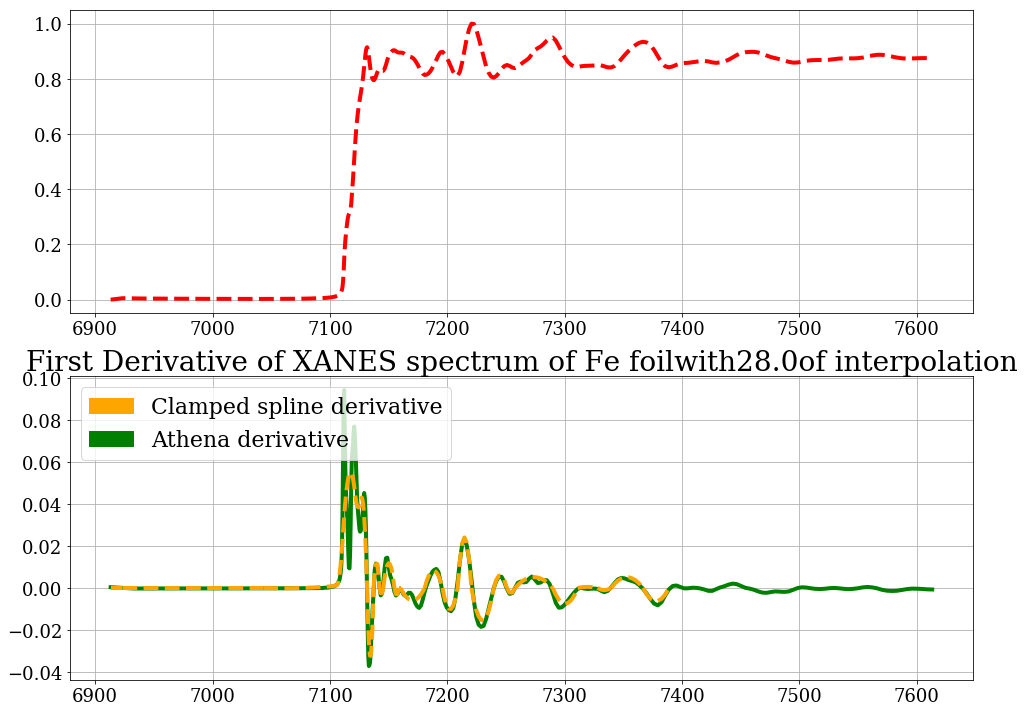

In [91]:
type_interp = 'cubicspline'
name = names[0]

# UNPACKING...
# ... parameters
xanes_now = parameters[name]['xanes']
E_now =parameters[name]['energy']
xanes_now_unpad = parameters[name]['raw_xanes']

# ... decomposition
decomposition_now = decompositions[name]
peak_loc = decomposition_now['peak_location']
number_splittings_before = decomposition_now['number_of_splittings_before']
number_splittings_after = decomposition_now['number_of_splittings_after']
start = peak_loc[str(-number_splittings_before)]
stop = peak_loc[str(number_splittings_after-1)]
            
start = peak_loc[str(-number_splittings_before)]
stop = peak_loc[str(number_splittings_after-1)]
        
plt.figure(figsize=(15,10))
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

L = stop
finite_difference_first= np.zeros([L])

xanes_now =np.array(xanes_now[0,start:stop],ndmin=2)
domain_now = np.array(E_now[0,start:stop],ndmin=2)
for i in range(2,L-1):
    finite_difference_first[i]= (xanes_now[0,i+1]-xanes_now[0,i])/(E_now[0,i+1]-E_now[0,i])

for i in {2}:
    
    ## Now the clamped spline
    breakpts,N = normalize_points(parameters,{name},decompositions,k=1+0.1*i,kind='middle_domain')
    clamped_outcome=clamped_interpolation(parameters,breakpts,decompositions,{name},printing=False,derivative=[1])

    plt.subplot(211)
    
    ##compute the firs derivative
    #y = splev(E_now[0,start:stop], cs, der=1)           
    plt.plot(
        E_now[0,0:stop],xanes_now[0,0:stop],'--',label ="Cubic splines $\Vert\cdot \Vert_{\infty}}$:",\
        color='red',lw=4
    )
    plt.grid(True)
    
    
    ax = plt.subplot(212)
   
    ax.plot(
        E_derivatives[names_1st_derivatives[0]][0,start:stop].T,.3*raw_materials_1st_derivatives[names_1st_derivatives[0]][0,start:stop].T,color='green',label=None,lw=4
    )
    y=materials[name][0,start:stop]
    plt.title("First Derivative of XANES spectrum of "+str(name)+"with"+str(N)+"of interpolation",fontsize=28)
    plt.grid(True)

Number_intervals = len(clamped_outcome[name]['vector_peak_loc'])-1

clamped_now = clamped_outcome[name]
for i in range(Number_intervals):
        # Unpacking....
        ### ....clamped_now
        cs_glue = clamped_now[str(i)+"cubic_spline"]
        x = clamped_now[str(i)+"x_interval"]
        d=1
        ax.plot(
            x.T,cs_glue(x,d).T,color='orange',lw=4,linestyle='--'
        )

orange_patch = mpatches.Patch(color='orange', label='Clamped spline derivative')
green_patch = mpatches.Patch(color='green', label='Athena derivative')
ax.legend(handles=[orange_patch, green_patch],fontsize=22,loc=2)
plt.grid(True)
figure_save("first_Derivative_comparison"+name+type_interp)
plt.show()    

In [92]:
28/parameters[names[0]]['stop']

0.06698564593301436

And we are finaly done :)

<h1><center>Raman spectra </center></h1>

[https://en.wikipedia.org/wiki/Raman_spectroscopy]

In [93]:
PROJECT_DIR_raman =  os.getcwd()#os.path.dirname(os.path.realpath(__file__))
NOTEBOOK_raman = "Raman_figures"
IMAGES_raman = os.path.join(PROJECT_DIR_raman,"figures",NOTEBOOK_raman)

### List all the csv files in the directory
import glob
what_files_raman = glob.glob(PROJECT_DIR+"/RAMAN/*.csv")

df_raman=pd.DataFrame([])

for name_of_file in what_files_raman:
    # read  first row with name of components
    aux = pd.read_csv(name_of_file,delimiter=',') 
    #clean up data before 
    aux.dropna(inplace=True)
    
    ## Concatenate them all    
    df_raman = pd.concat([df_raman,aux],axis=1)

data_raman = df_raman.copy()
data_raman.dropna(inplace=True)

## Plot the data
## Getting the name.... I know, I'm doing it in a weird way:
names_raman = [str(read[::-1]) for read in what_files_raman]
names_raman = [read.partition("/")[0] for read in names_raman]
names_raman = [str(read[::-1]) for read in names_raman]
names_raman = [read.partition(".")[0] for read in names_raman]
names_raman = [read.partition("_")[0] for read in names_raman]

In [94]:
## A save figures function
def figure_save(figure_name, tight_layout=True, figure_extension="eps",resolution=300):
    path = os.path.join(IMAGES_raman,figure_name.replace(" ", "_")+"."+figure_extension)
    print("Saving figure as ",figure_name.replace(" ", "_"))
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path,format=figure_extension,dpi=resolution)

In [95]:
names_raman

['Sulfur']

In [96]:
### These are the dictionaries where we will save numpy arrays
raw_materials_raman ={}
E_raman={}
A_raman={}
data_val_raman = data_raman.values
numb_files_raman = len(what_files_raman)

temp_plot= None

for i in range(numb_files_raman):
    now = data_raman.iloc[:,[2*i,2*i+1]]
    now =now.dropna(subset=now.columns)
    A_raman[str(i)]= now[now.isnull().any(axis=1)].head()    
    E_raman[names_raman[i]] = np.reshape(data_val_raman[:,2*i],(1,-1))
    raw_materials_raman[names_raman[i]] = np.reshape(data_val_raman[:,2*i+1],(1,-1))

Let's plot the graphs

Saving figure as  Raman_some_examplesSulfur


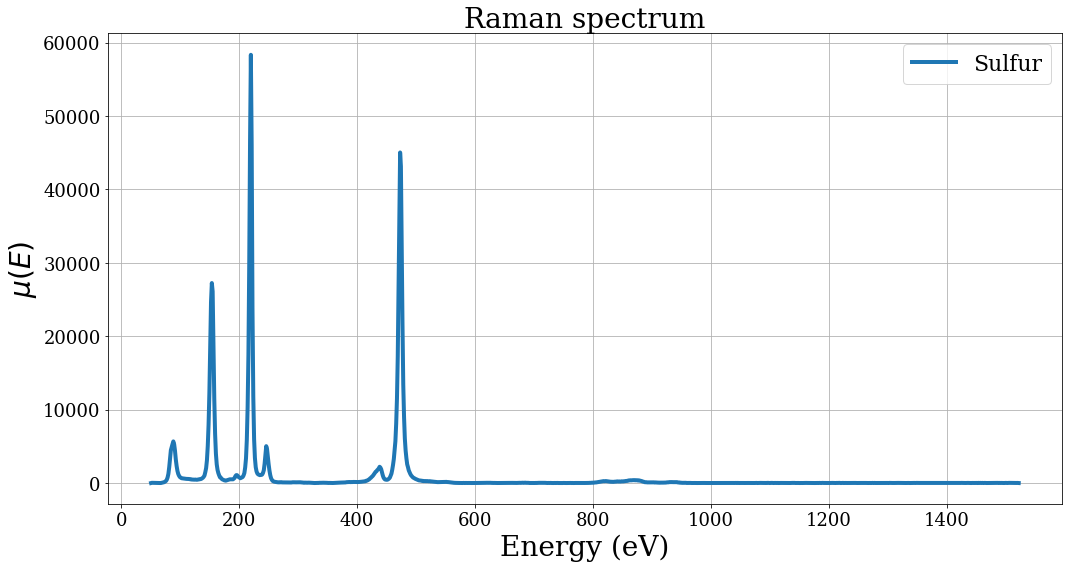

In [97]:
### I'm gonna change the value of the variable 
L = len(names)
plt.figure(figsize=(15,8))
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
#ax = fig.add_subplot(1, 1, 1)

#plt.rc('text', usetex=True)
for name in names_raman:
    plt.plot(
        E_raman[name].T,raw_materials_raman[name].T, label = name,lw=4,linestyle='-'
    )

plt.title('Raman spectrum',size=28)
plt.ylabel('$\mu(E)$',size=28)
plt.xlabel("Energy (eV)", size=28)
plt.legend(loc=1,prop={'size':22})
plt.grid(True)
figure_save("Raman_some_examples"+names_raman[0])
plt.show()    

<h2><center> Normalization and setup of parameters and hyperparameters </h2></center>

In [98]:
### I'm gonna change the value of the variable 

materials_raman, shift_height_raman, normalizer_shift_raman =normalization(raw_materials_raman,names_raman,normalizeheight=True)
E_padded_raman,materials_raman, stopping_raman = padded_spectra(E_raman,materials_raman,names_raman)


In [99]:
parameters_raman ={}

for name in names_raman:
    parameters_raman[name]={
        # The non-normalized xanes
        'raw_xanes': raw_materials_raman[name],
        'raw_energy': E_raman[name],
   
        # The normalized xanes and embedded xanes
        'xanes': materials_raman[name],
        'energy': E_padded_raman[name],

        # The normalization and emebdding info
        'stop': stopping_raman[name],
        'shift_height': shift_height_raman[name],
        'normalizer_shift': normalizer_shift_raman[name]
    }

In [100]:
hyperparameters_raman={
    ## These hyperparameters will be used in 
    'lambda_h':1,
    'lambda_d':1,
    
    ## These hyperparameters will be used in find_first_peak
    'lambda_h_find_1st':4,
    'lambda_d_find_1st':1/4,
    
    ## These hyperparameters will be used in 
    'lambda_d_shrink_1st':1/5, 
    'initial_oscillation_guess_parameter':10,
    
    ## These hyperparameters will be used in 
    'stretching_factor':3,
    'iteration_decay':.9,
    
    ## Type of decay_rate
    'decay_rate_type': 'learn_to_trust'
}


search_conditions_raman = {
    'move':'backstep',#'middle_step',
    'printing':True,
    'polite_guess':{},
    'forward':True
}

In [101]:
N_split_after_raman, N_split_before_raman=10,10

decompositions_raman =\
write_material_peak_properties(
    parameters_raman,hyperparameters_raman,search_conditions_raman,names_raman,\
    N_split_after_raman , N_split_before_raman
)

************************************** 

Material: Sulfur 

************************************** 

	 Going for 0th breakpoint. 

	 Peak 0 located at: 74
	 Peak height:0.46699331441424463
	 Distance between successive crests and peaks:  [-9] 

	 Jumps:  0.16653640594363273 

	 ***************************** 

	 Going for 1th breakpoint. 

	 Peak 1 located at: 91
	 Peak height:0.005548859958974814
	 Distance between successive crests and peaks:  [-9 17] 

	 Jumps:  [0.16653641 0.46144445] 

	 ***************************** 

	 Going for 2th breakpoint. 

	 Peak 2 located at: 122
	 Peak height:1.0
	 Distance between successive crests and peaks:  [-9 17 31] 

	 Jumps:  [0.16653641 0.46144445 0.99445114] 

	 ***************************** 

	 Going for 3th breakpoint. 

	 Peak 3 located at: 133
	 Peak height:0.018407199511362014
	 Distance between successive crests and peaks:  [-9 17 31 11] 

	 Jumps:  [0.16653641 0.46144445 0.99445114 0.9815928 ] 

	 ***************************** 

	 Going 

Saving figure as  SulfurRaman_with_marked_peaks_average-middle_step


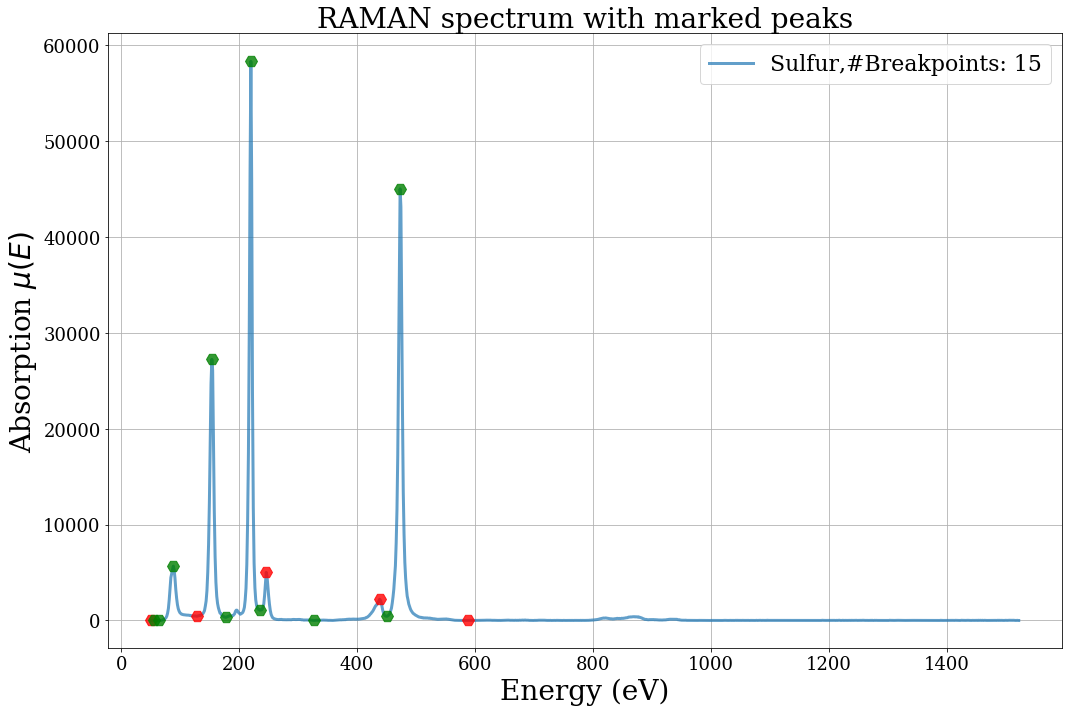

In [102]:
plot_marked_peak_spectrum(
    parameters_raman,names_raman,decompositions_raman,\
    save_as=names_raman[0]+"Raman_with_marked_peaks_average-middle_step",\
    plot_type='raw',loc=1,
    title="RAMAN spectrum with marked peaks"
    #figure_extension="png"
)

<h1><center>EELS spectra </center></h1>



[https://en.wikipedia.org/wiki/Electron_energy_loss_spectroscopy]

In [103]:
NOTEBOOK_eels = "EELS_figures"
IMAGES = os.path.join(PROJECT_DIR,"figures",NOTEBOOK)

### List all the csv files in the directory
what_files_eels = glob.glob(PROJECT_DIR+"/EELS/*.csv")

data_eels=pd.DataFrame([])

for name_of_file in what_files_eels:
    aux = pd.read_csv(name_of_file,delimiter=',') 
    ## Concatenate them all
    aux.dropna(inplace=True)
    data_eels = pd.concat([data_eels,aux],axis=1)
    
data_eels.dropna(inplace=True)

## Plot the data
## Getting the name.... I know, I'm doing it in a weird way:
names_eels = [str(read[::-1]) for read in what_files_eels]
names_eels = [read.partition("/")[0] for read in names_eels]
names_eels = [str(read[::-1]) for read in names_eels]
names_eels = [read.partition(".")[0] for read in names_eels]

name_in_csv_eels = list(data.columns)
### These are the dictionaries where we will save numpy arrays
raw_materials_eels ={}
E_eels={}
A_eels={}
data_val_eels = data_eels.values
numb_files_eels = len(what_files_eels)

for i in range(numb_files_eels):
    now = data_eels.iloc[:,[2*i,2*i+1]]
    now =now.dropna(subset=now.columns)
    A_eels[str(i)]= now[now.isnull().any(axis=1)].head()    
    E_eels[names_eels[i]] = np.reshape(data_val_eels[:,2*i],(1,-1))
    raw_materials_eels[names_eels[i]] = np.reshape(data_val_eels[:,2*i+1],(1,-1))

Saving figure as  EELS_some_examplesIron_Oxide


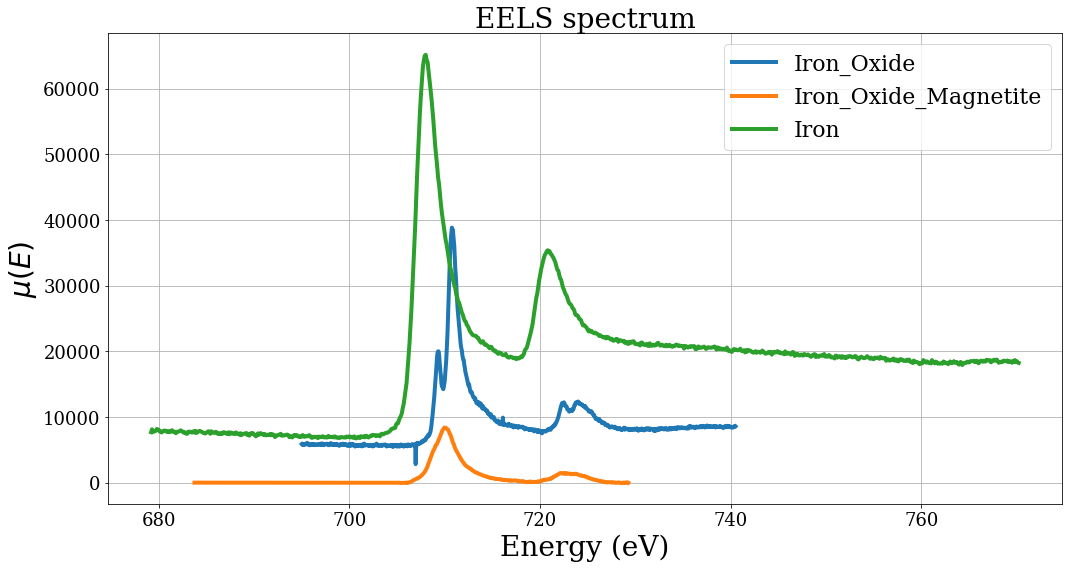

In [104]:
### I'm gonna change the value of the variable 
L = len(names)
plt.figure(figsize=(15,8))
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
#ax = fig.add_subplot(1, 1, 1)

#plt.rc('text', usetex=True)
for name in names_eels:
    plt.plot(
        E_eels[name].T,raw_materials_eels[name].T, label = name,lw=4,linestyle='-'
    )

plt.title('EELS spectrum',size=28)
plt.ylabel('$\mu(E)$',size=28)
plt.xlabel("Energy (eV)", size=28)
plt.legend(loc=1,prop={'size':22})
plt.grid(True)
figure_save("EELS_some_examples"+names_eels[0])
plt.show()    

In [105]:
materials_eels, shift_height_eels, normalizer_shift_eels =normalization(raw_materials_eels,names_eels,normalizeheight=True)
E_padded_eels,materials_eels, stopping_eels = padded_spectra(E_eels,materials_eels,names_eels)

In [106]:
parameters_eels ={}

for name in names_eels:
    parameters_eels[name]={
        # The non-normalized xanes
        'raw_xanes': raw_materials_eels[name],
        'raw_energy': E_eels[name],
   
        # The normalized xanes and embedded xanes
        'xanes': materials_eels[name],
        'energy': E_padded_eels[name],

        # The normalization and emebdding info
        'stop': stopping_eels[name],
        'shift_height': shift_height_eels[name],
        'normalizer_shift': normalizer_shift_eels[name]
    }
    
hyperparameters_eels={
    ## These hyperparameters will be used in 
    'lambda_h':1,
    'lambda_d':1/2,
    
    ## These hyperparameters will be used in find_first_peak
    'lambda_h_find_1st':4,
    'lambda_d_find_1st':1/4,
    
    ## These hyperparameters will be used in 
    'lambda_d_shrink_1st':1/2, 
    'initial_oscillation_guess_parameter':10,
    
    ## These hyperparameters will be used in 
    'stretching_factor':3,
    'iteration_decay':.9,
    
    ## Type of decay_rate
    'decay_rate_type': 'min_max'
}


search_conditions_eels = {
    'move':'backstep',#'middle_step',
    'printing':True,
    'polite_guess':{},
    'forward':True
}

In [107]:
names_eels

['Iron_Oxide', 'Iron_Oxide_Magnetite', 'Iron']

In [108]:
E_eels.keys()

dict_keys(['Iron', 'Iron_Oxide', 'Iron_Oxide_Magnetite'])

In [109]:
N_split_after_eels, N_split_before_eels=10,10

decompositions_eels =\
write_material_peak_properties(
    parameters_eels,hyperparameters_eels,search_conditions_eels,names_eels,\
     N_split_before_eels,N_split_after_eels
)

************************************** 

Material: Iron_Oxide 

************************************** 

	 Going for 0th breakpoint. 

	 Peak 0 located at: 315
	 Peak height:1.0
	 Distance between successive crests and peaks:  [21] 

	 Jumps:  0.9169816843291548 

	 ***************************** 

	 Going for 1th breakpoint. 

	 Peak 1 located at: 504
	 Peak height:0.04976764344136594
	 Distance between successive crests and peaks:  [ 21 189] 

	 Jumps:  [0.91698168 0.95023236] 

	 ***************************** 

	 Going for 2th breakpoint. 

	 Peak 2 located at: 580
	 Peak height:0.1966147071317151
	 Distance between successive crests and peaks:  [ 21 189  76] 

	 Jumps:  [0.91698168 0.95023236 0.14684706] 

	 ***************************** 

	 Going for 3th breakpoint. 

	 Peak 3 located at: 741
	 Peak height:0.060361617199949175
	 Distance between successive crests and peaks:  [ 21 189  76 161] 

	 Jumps:  [0.91698168 0.95023236 0.14684706 0.13625309] 

	 ****************************

Saving figure as  EELS_with_marked_peaks_average-middle_step


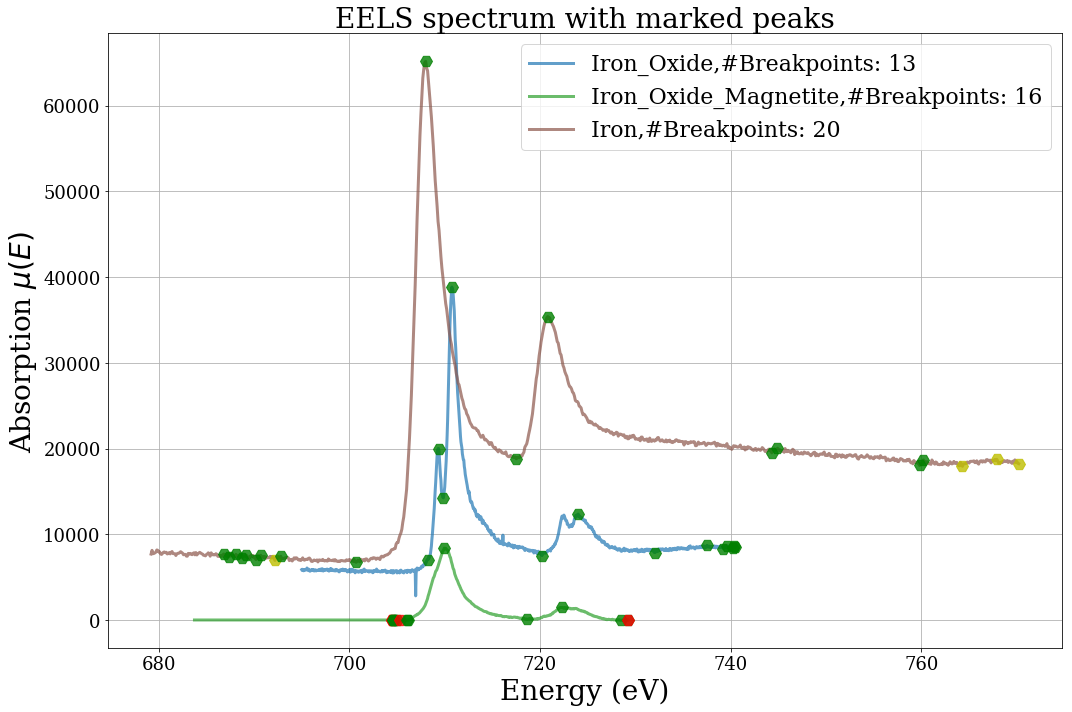

In [110]:
plot_marked_peak_spectrum(
    parameters_eels,names_eels,decompositions_eels,\
    save_as="EELS_with_marked_peaks_average-middle_step",\
    plot_type='raw',\
    title="EELS spectrum with marked peaks",loc=1
)
